In [1]:
import os
import h5py
import numpy as np
import cv2
from kymatio import Scattering2D
from PIL import Image
import matplotlib.pyplot as plt
#from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp
from astropy.cosmology import Planck15 as cosmo
import scipy
from scipy.ndimage import gaussian_filter1d

try:
    xrange(1)
except NameError:
    xrange = range

In [2]:
sim_res= 100

def get_mean_flux_scale(tau, desired_mean_flux, nbins, tol):
    newscale =1
    scale=0
    while np.abs(newscale-scale) > (tol*newscale):
        
        scale= newscale
        mean_flux =0
        tau_mean_flux =0
        nbins_used=0
        tau_mean=[]
        for i in range(0, 32000):
            tau_mean.append(np.mean(tau[i]))
        
       
        for i in range(0, nbins):
            temp= np.exp(-scale*tau_mean[i])
            mean_flux= mean_flux+temp
            tau_mean_flux = tau_mean_flux+temp*tau_mean[i]
            nbins_used=nbins_used+1
        
        newscale=scale+(mean_flux- desired_mean_flux * nbins_used)/tau_mean_flux

        if newscale <= 0:
            newscale=1e-10
            
    return newscale

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def _powerspectrum(inarray, axis=-1):
    """Compute the power spectrum of the input using np.fft"""
    rfftd = np.fft.rfft(inarray, axis=axis)
    # Want P(k)= F(k).re*F(k).re+F(k).im*F(k).im
    power = np.abs(rfftd)**2
    #Normalise the FFT so it is independent of input size.
    power /= np.shape(inarray)[axis]**2
    return power


def add_noise(snr, flux, spec_num=-1):
        """Compute a Gaussian noise vector from the flux variance and the SNR, as computed from optical depth
        Parameters:
        snr : an array of signal to noise ratio (constant along each sightine)
        flux : an array of spectra (flux)  we want to add noise to
        spec_num : the index to spectra we want to add nose to. Leave it as -1 to add the noise to all spectra.
        """
        nbins=flux.shape[1]
        noise_array = np.array([])
        if np.size(np.shape(flux)) == 1:
            lines = 1
        else:
            lines = np.shape(flux)[0]
        #This is to get around the type rules.
        if lines == 1:
            #This ensures that we always get the same noise for the same spectrum
            np.random.seed(spec_num)
            flux += np.random.normal(0, 1./snr[spec_num], nbins)
        else:
            for ii in xrange(lines):
                np.random.seed(ii)
                noise = np.random.normal(0, 1./snr[ii], nbins)
                noise_array = np.append(noise_array, noise)
                flux[ii]+= noise
        return (flux, noise_array)


    
def obs_mean_tau(redshift):
    return 0.0023*(1.0+redshift)**3.65



def scale_factor_to_redshift(scale_factor):
    return (1 / scale_factor) - 1


In [3]:
lya_file = h5py.File('/Users/Hurum/Documents/z=2/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5', 'r')
all_tau = lya_file['tau']['H']['1']['1215'][:]
rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))
        
## adjusting for mean flux and smoothing the data
rescaled_tau = rescale_factor*all_tau
all_flux = np.exp(-rescaled_tau)
boxsize = lya_file['Header'].attrs['box']/1000
z= scale_factor_to_redshift(.29)
res_in_cmp = (sim_res /cosmo.H(z).value)*(1+z) * cosmo.h
num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
all_flux= coarse_flux

In [4]:
from kymatio.numpy import Scattering1D

J= 5
T= 370
Q= 1
scattering = Scattering1D(J, T, Q)

scat=[]
for i in range(0,32000):
    Sx = scattering(all_flux[i])
    scat.append(Sx)
scat=np.array(scat)
scat= scat.mean(axis=0)    
print(np.shape(scat))

(19, 11)


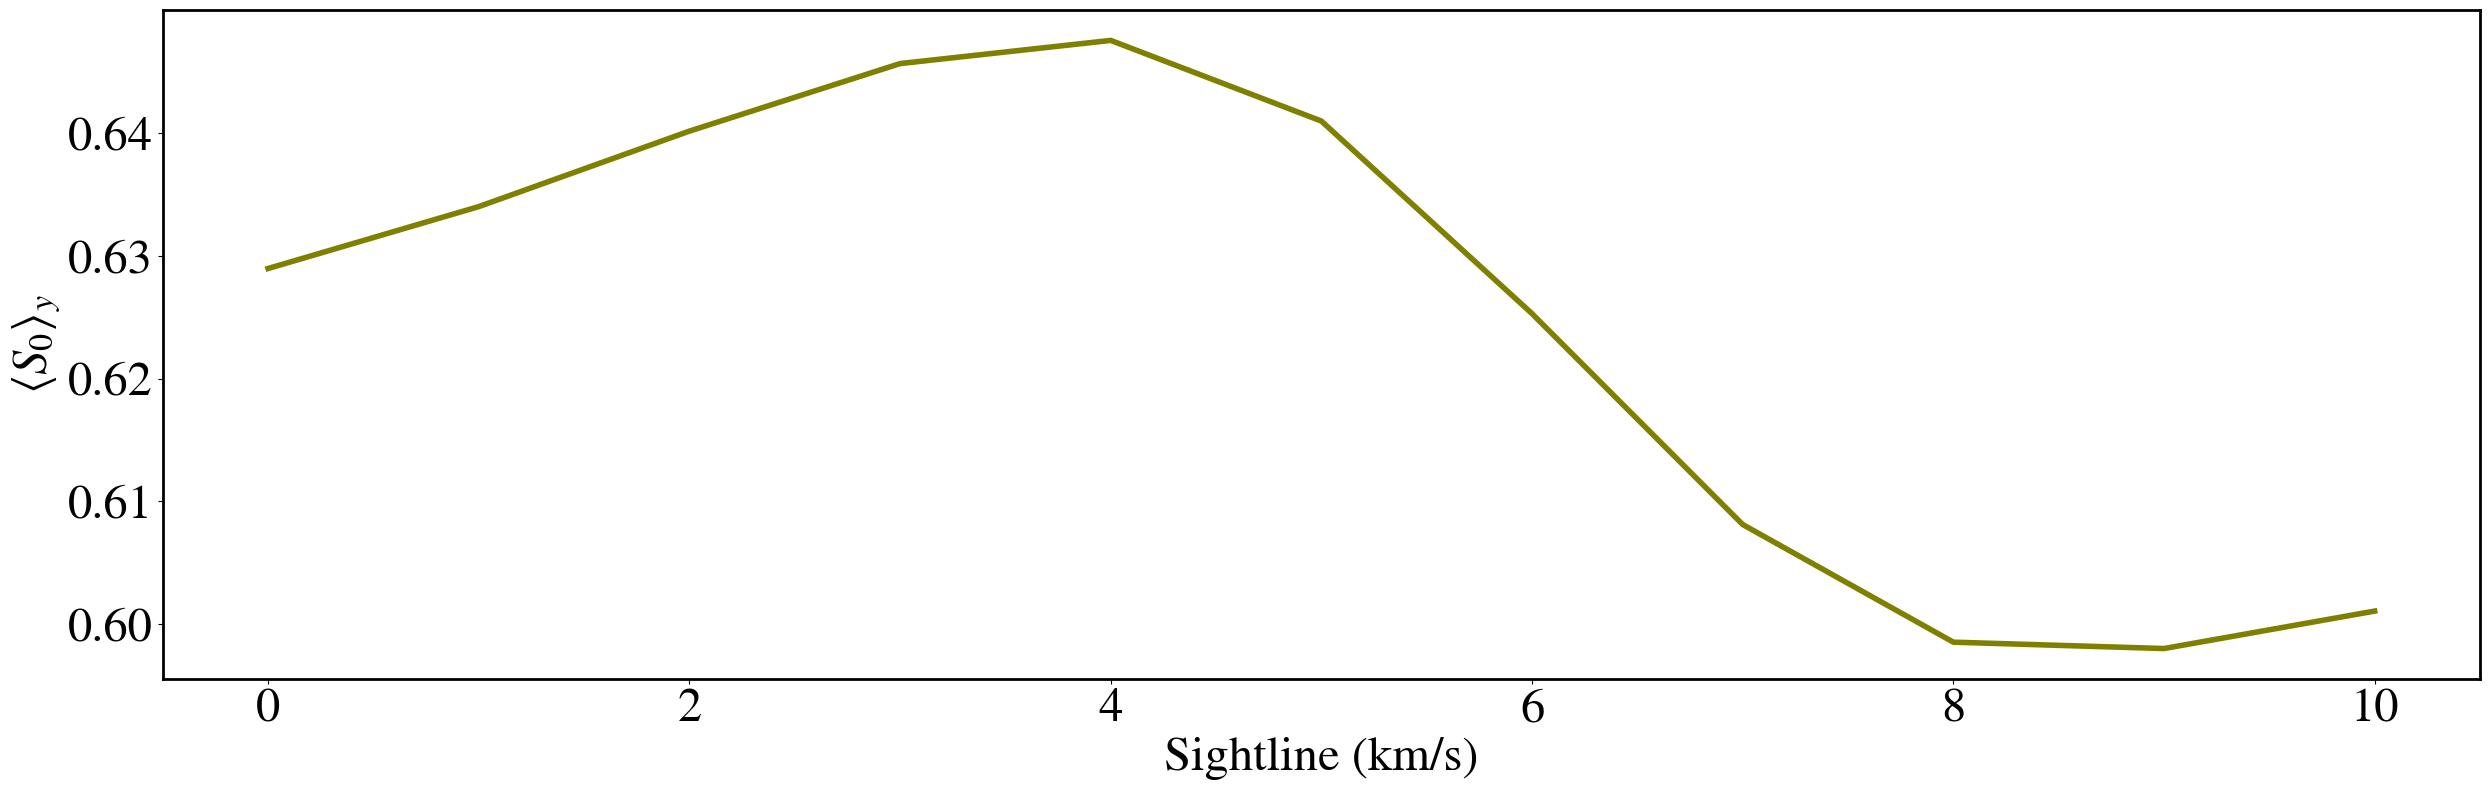

In [116]:
plt.rcParams["figure.figsize"] = [25,8]
plt.rc("axes", linewidth=2.0)
plt.rc("lines", markeredgewidth=3)
plt.rc('axes', labelsize=35)
plt.rc('xtick', labelsize=35)
plt.rc('ytick', labelsize=35)

plt.plot(scat[0], color='olive', linewidth = 4)
plt.xlabel(r'Sightline (km/s)', fontsize=35)
plt.ylabel(r'$\langle S_0 \rangle_y$' , fontsize=35)
plt.tight_layout()
plt.savefig('zeroth_1d.pdf')

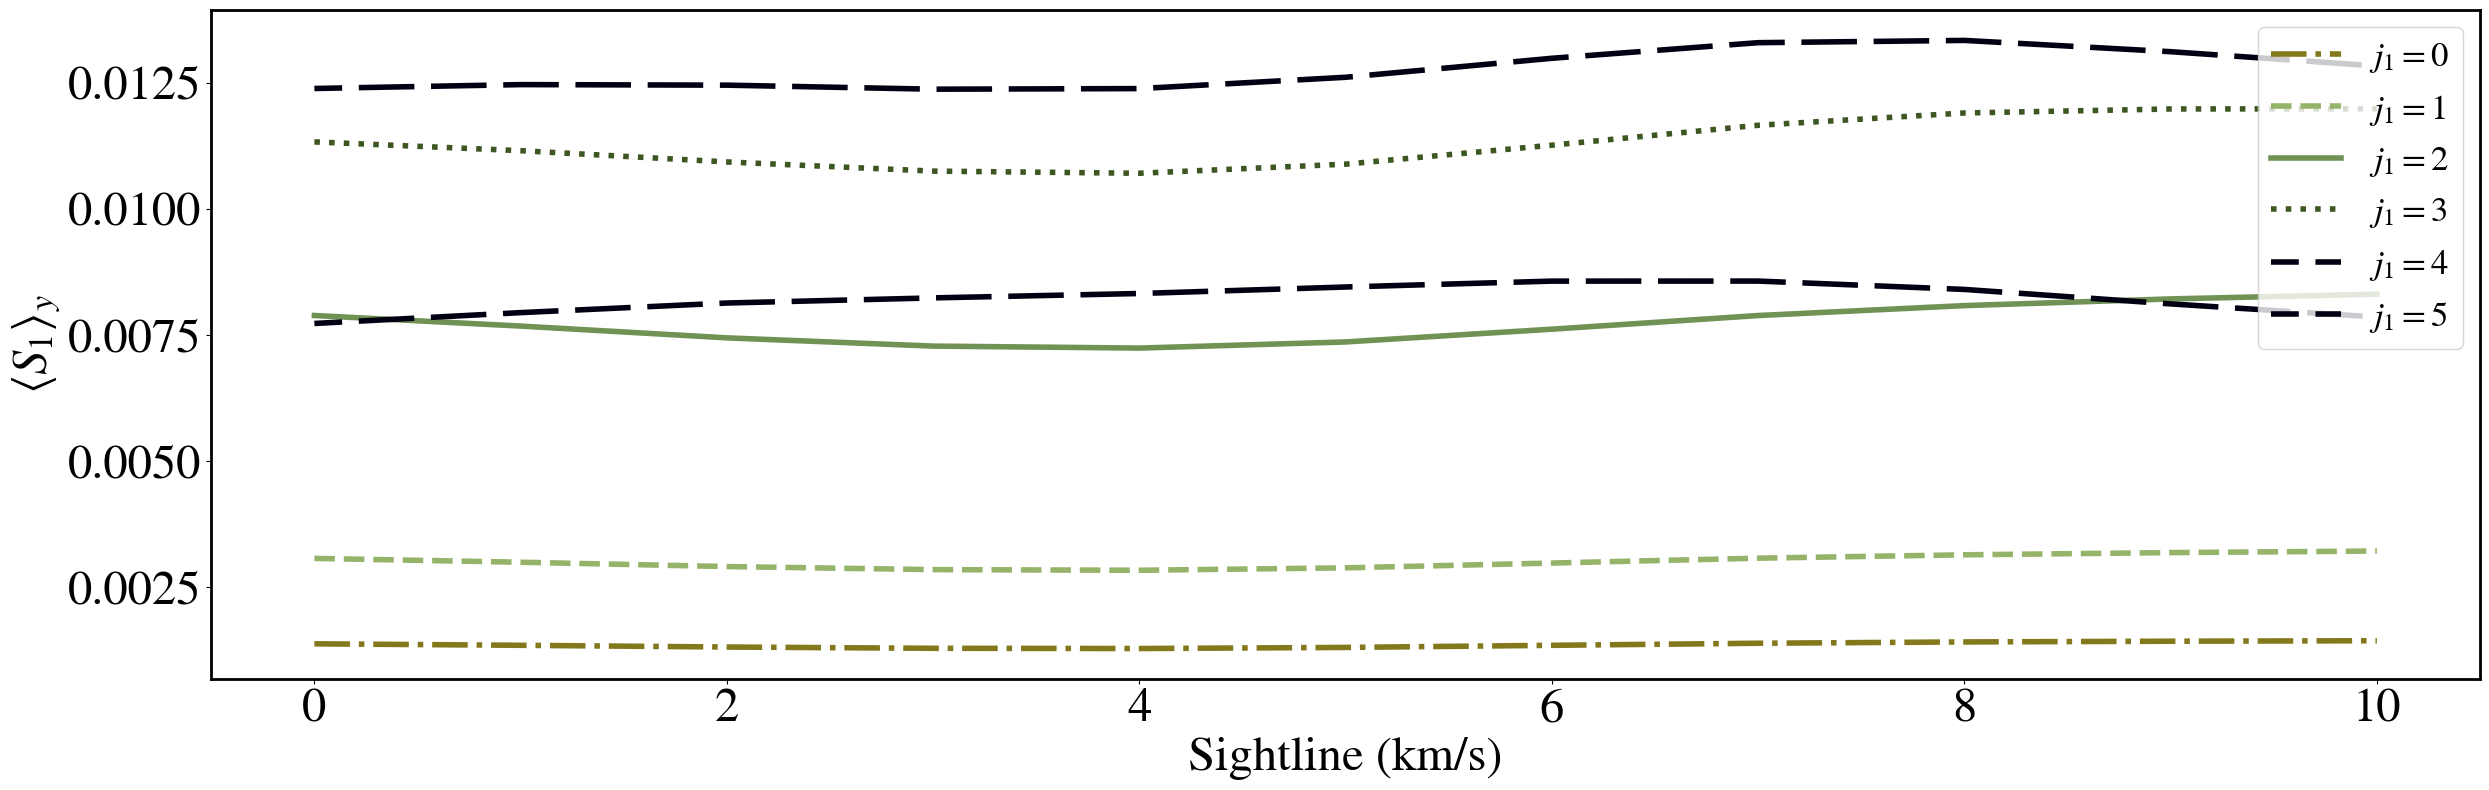

In [115]:
plt.rcParams["figure.figsize"] = [25,8]
plt.rc("axes", linewidth=2.0)
plt.rc("lines", markeredgewidth=3)
plt.rc('axes', labelsize=35)
plt.rc('xtick', labelsize=35)
plt.rc('ytick', labelsize=35)

plt.plot(scat[1], label = r'$j_1 =0$',color='#83781B',linestyle='-.', linewidth = 4)
plt.plot(scat[2], label = r'$j_1 =1$',color='#95B46A',linestyle='dashed', linewidth = 4)
plt.plot(scat[3], label = r'$j_1 =2$',color='#709255',linestyle ='solid', linewidth = 4)
plt.plot(scat[4], label = r'$j_1 =3$',color='#3E5622',linestyle='dotted', linewidth = 4)
plt.plot(scat[5], label = r'$j_1 =4$', color = '#010012',linestyle=(5, (10, 3)), linewidth = 4)
plt.plot(scat[6], label = r'$j_1 =5$', color = '#010012',linestyle=(5, (10, 3)), linewidth = 4)

plt.legend(loc= 'upper right',fontsize=25)
plt.xlabel(r'Sightline (km/s)', fontsize=35)
plt.ylabel(r'$\langle S_1 \rangle_y$' , fontsize=35)
plt.tight_layout()
plt.savefig('first_1d.pdf')

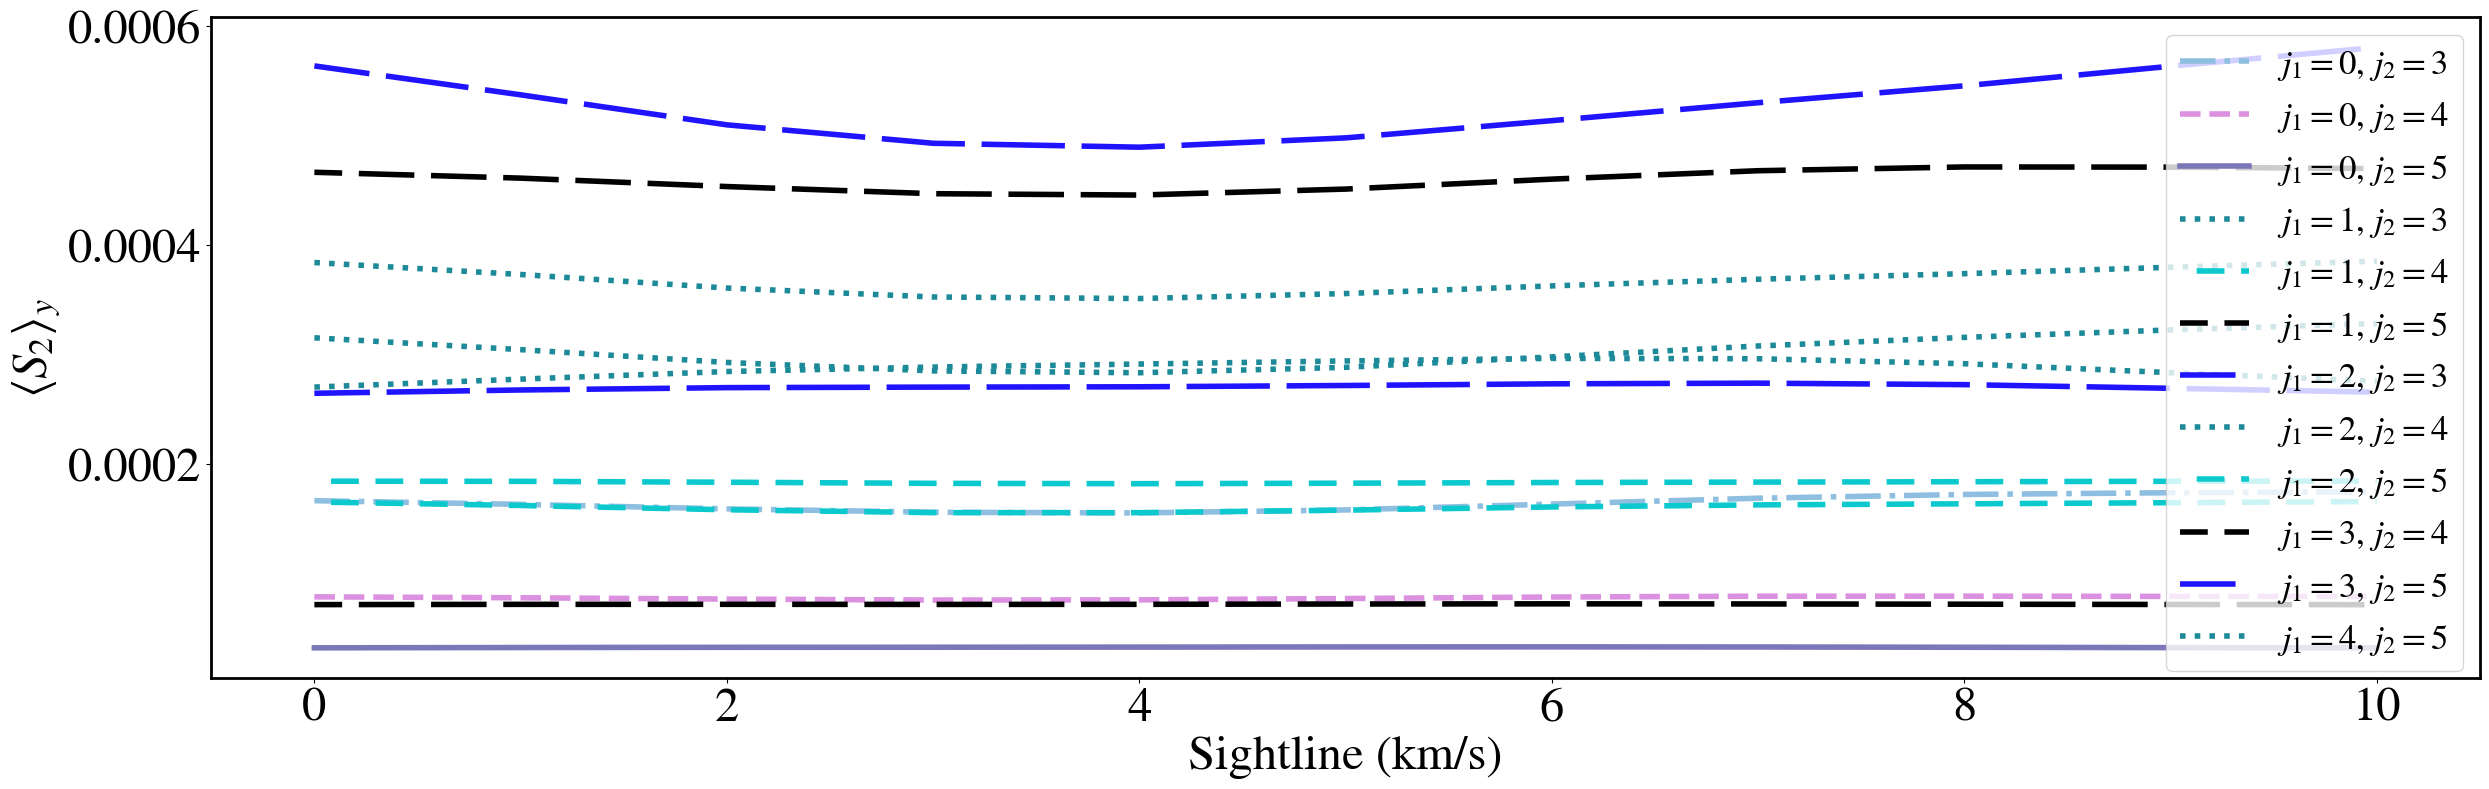

In [114]:
plt.rcParams["figure.figsize"] = [25,8]
plt.rc("axes", linewidth=2.0)
plt.rc("lines", markeredgewidth=3)
plt.rc('axes', labelsize=35)
plt.rc('xtick', labelsize=35)
plt.rc('ytick', labelsize=35)

plt.plot(scat[7], label = r'$j_1 =0$, $j_2 = 3$',color='#8FBFE0',linestyle='-.', linewidth = 4)
plt.plot(scat[8], label = r'$j_1 =0$, $j_2 = 4 $',color='#DB90E0',linestyle='dashed', linewidth = 4)
plt.plot(scat[9], label = r'$j_1 =0$, $j_2 = 5$',color='#7C77B9',linestyle ='solid', linewidth = 4)
plt.plot(scat[10], label = r'$j_1 =1$, $j_2 = 3$',color='#1D8A99',linestyle='dotted', linewidth = 4)
plt.plot(scat[11], label = r'$j_1 =1$, $j_2 = 4$', color = '#0BC9CD',linestyle=(5, (5, 3)), linewidth = 4)
plt.plot(scat[12], label = r'$j_1 =1$, $j_2 = 5$', color = 'black',linestyle=(5, (10, 3)), linewidth = 4)
plt.plot(scat[13], label = r'$j_1 =2$, $j_2 = 3$', color = '#2014FF',linestyle=(5, (15, 3)), linewidth = 4)
plt.plot(scat[14], label = r'$j_1 =2$, $j_2 = 4$',color='#1D8A99',linestyle='dotted', linewidth = 4)
plt.plot(scat[15], label = r'$j_1 =2$, $j_2 = 5$', color = '#0BC9CD',linestyle=(5, (5, 3)), linewidth = 4)
plt.plot(scat[16], label = r'$j_1 =3$, $j_2 = 4$', color = 'black',linestyle=(5, (10, 3)), linewidth = 4)
plt.plot(scat[17], label = r'$j_1 =3$, $j_2 = 5$', color = '#2014FF',linestyle=(5, (15, 3)), linewidth = 4)
plt.plot(scat[18], label = r'$j_1 =4$, $j_2 = 5$',color='#1D8A99',linestyle='dotted', linewidth = 4)

plt.legend(loc= 'upper right',fontsize=25)
plt.xlabel(r'Sightline (km/s)', fontsize=35)
plt.ylabel(r'$\langle S_2 \rangle_y$' , fontsize=35)

plt.tight_layout()
plt.savefig('sec_1d.pdf')

### Fiducial model

In [5]:
lya_file = h5py.File('/Users/Hurum/Documents/z=2/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5', 'r')
all_tau = lya_file['tau']['H']['1']['1215'][:]
rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))
rescaled_tau = rescale_factor*all_tau
all_flux = np.exp(-rescaled_tau)
    
boxsize = lya_file['Header'].attrs['box']/1000
z= 2.4
res_in_cmp = (100 /cosmo.H(z).value)*(1+z) * cosmo.h
num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
all_flux= coarse_flux
all_flux= coarse_flux/np.mean(all_flux)
    
scat_fid=[]
for i in range(0,32000):
    Sx = scattering(all_flux[i])
    scat_fid.append(Sx)
scat_fid = np.array(scat_fid)
scat_fid = scat_fid.mean(axis=0) 


print(np.shape(scat_fid))

first_ord_fid= scat_fid[1:7]
print(np.shape(first_ord_fid))
first_ord_fid = np.array(first_ord_fid)
ord_1_fid = first_ord_fid.mean(axis=1)
print(np.shape(ord_1_fid))


sec_ord_fid= scat_fid[7:19]
print(np.shape(sec_ord_fid))
sec_ord_fid = np.array(sec_ord_fid)
ord_2_fid = sec_ord_fid.mean(axis=1)
print(np.shape(ord_2_fid))


(19, 11)
(6, 11)
(6,)
(12, 11)
(12,)


In [6]:
sim_list=['/Users/Hurum/Documents/z=2/ns0.8As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=2/ns0.849As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
          '/Users/Hurum/Documents/simulation_new/ns0.946_z_2/lya_forest_spectra.hdf5']

scat_21=[]
for i in range(0,3):
    
    lya_file = h5py.File(sim_list[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))
    rescaled_tau = rescale_factor*all_tau
    all_flux = np.exp(-rescaled_tau)
    
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.29)
    res_in_cmp = (100 /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    all_flux= coarse_flux/np.mean(all_flux)
    
    scat=[]
    for i in range(0,32000):
        Sx = scattering(all_flux[i])
        Sx = Sx.mean(axis=1)
        scat.append(Sx)

    print(np.shape(scat))
    scat_21.append(scat)

scat_21 = np.array(scat_21)
scat_21 = scat_21.mean(axis=1)    
    
print(np.shape(scat_21))
first_ord= [scat_21[0][1:7],scat_21[1][1:7],scat_21[2][1:7]]
print(np.shape(first_ord))

sec_ord= [scat_21[0][7:19],scat_21[1][7:19],scat_21[2][7:19]]
print(np.shape(sec_ord))


(32000, 19)
(32000, 19)
(32000, 19)
(3, 19)
(3, 6)
(3, 12)


In [7]:
coeff=[r'$(0,3)$',r'$(0,4)$',r'$(0,5)$',r'$(1,3)$',r'$(1,4)$',r'$(1,5)$',r'$(2,3)$',r'$(2,4)$',r'$(2,5)$',r'$(3,4)$',r'$(3,5)$',r'$(4,5)$']
print(np.shape(coeff))

(12,)


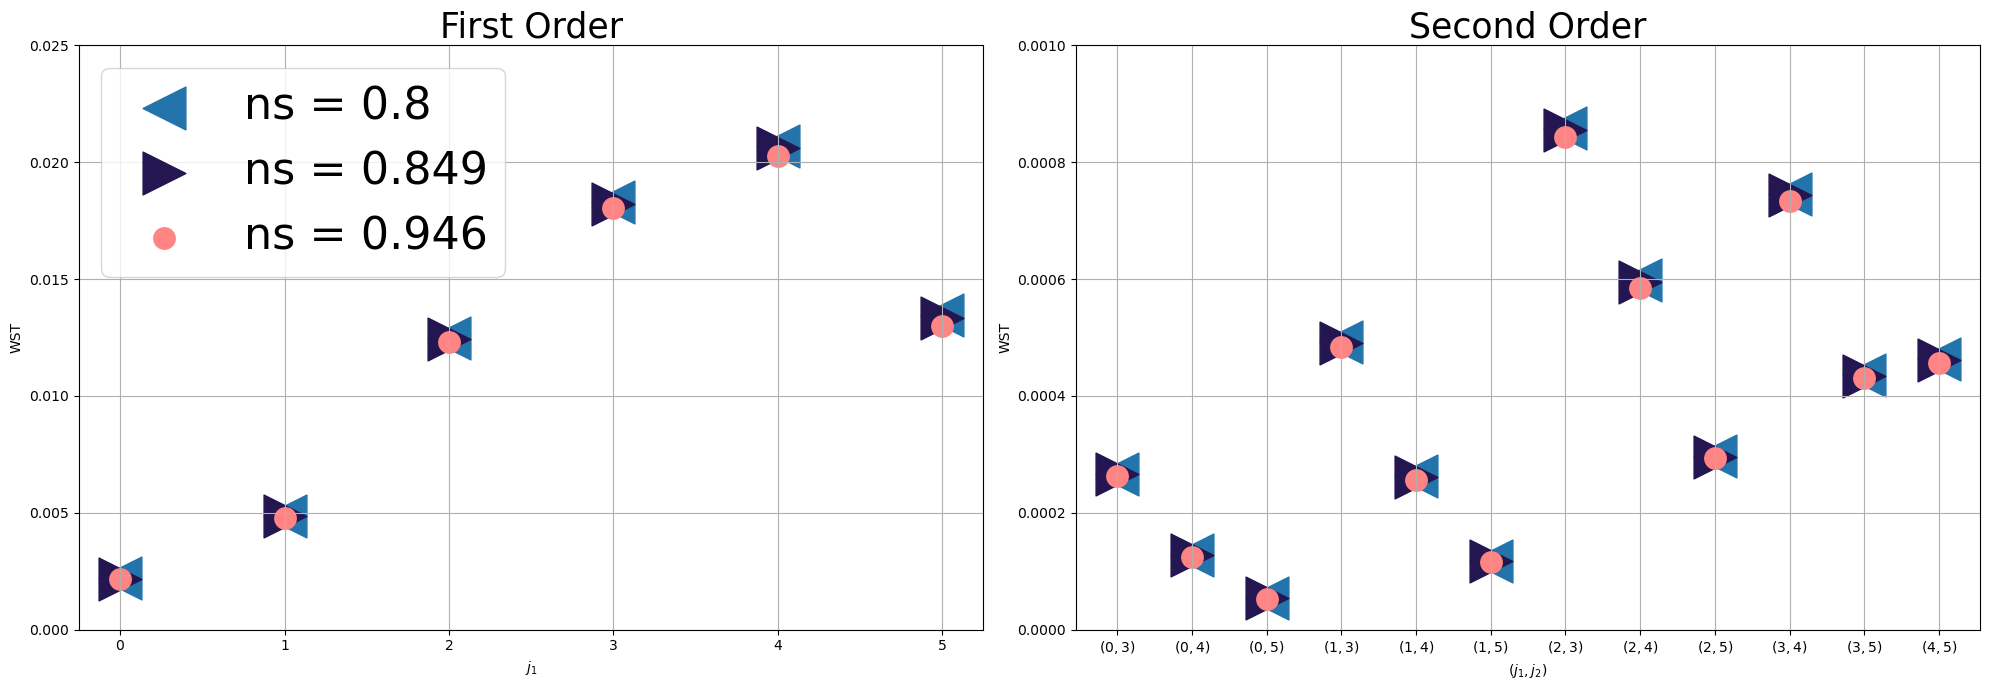

In [8]:
plt.rcParams["figure.figsize"] = [20.0,7.0]


ord_1_ns= np.array(first_ord)
fig, axs = plt.subplots(nrows=1, ncols=2)
coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$',r'$5$']


plt.subplots_adjust(wspace=0.4, hspace=0.4)

axs[0].scatter(coeff , ord_1_ns[0], marker = '<',color='#2374AB', s= 950, label ='ns = 0.8')
axs[0].scatter(coeff , ord_1_ns[1], marker = '>',color='#231651', s= 950, label ='ns = 0.849')
axs[0].scatter(coeff , ord_1_ns[2], marker='.', s=950, color='#FF8484', label ='ns = 0.946')
axs[0].grid('true')
axs[0].set_ylabel('WST')
axs[0].set_xlabel(r'$j_1$')



coeff=[r'$(0,3)$',r'$(0,4)$',r'$(0,5)$',r'$(1,3)$',r'$(1,4)$',r'$(1,5)$',r'$(2,3)$',r'$(2,4)$',r'$(2,5)$',r'$(3,4)$',r'$(3,5)$',r'$(4,5)$']
ord_2_ns= np.array(sec_ord)


axs[1].scatter(coeff , ord_2_ns[0], marker = '<',color='#2374AB', s= 950, label ='ns = 0.8')
axs[1].scatter(coeff , ord_2_ns[1], marker = '>',color='#231651', s= 950, label ='ns = 0.849')
axs[1].scatter(coeff , ord_2_ns[2], marker='.', s=950,color='#FF8484', label ='ns = 0.897')
axs[1].grid('true')
axs[1].set_ylabel('WST')
axs[1].set_xlabel(r'$(j_1,j_2)$')



axs[0].legend(loc='upper left', fontsize = 32)

axs[0].set_ylim([0,0.025])
axs[1].set_ylim([0,0.001])
#axs[2].set_ylim([0.065,0.085])

axs[0].set_title('First Order', size = 25)
axs[1].set_title('Second Order', size = 25)
#axs[2].set_title('Second Order', size = 25)
plt.tight_layout()
plt.savefig('ns1d.pdf')

In [9]:
sim_list=['/Users/Hurum/Documents/z=2/ns0.897As1.9e-09heat_slope-0.7heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=2/ns0.897As1.9e-09heat_slope-0.5heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=2/ns0.897As1.9e-09heat_slope-0.1heat_amp0.9hub0.7/lya_forest_spectra.hdf5']


scat_21=[]
for i in range(0,3):
    
    lya_file = h5py.File(sim_list[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))
    rescaled_tau = rescale_factor*all_tau
    all_flux = np.exp(-rescaled_tau)
    
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.29)
    res_in_cmp = (100 /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    all_flux= coarse_flux/np.mean(all_flux)
    
    scat=[]
    for i in range(0,32000):
        Sx = scattering(all_flux[i])
        Sx = Sx.mean(axis=1)
        scat.append(Sx)

    print(np.shape(scat))
    scat_21.append(scat)

scat_21 = np.array(scat_21)
scat_21 = scat_21.mean(axis=1)    
    
print(np.shape(scat_21))
first_ord= [scat_21[0][1:7],scat_21[1][1:7],scat_21[2][1:7]]
print(np.shape(first_ord))

sec_ord= [scat_21[0][7:19],scat_21[1][7:19],scat_21[2][7:19]]
print(np.shape(sec_ord))


(32000, 19)
(32000, 19)
(32000, 19)
(3, 19)
(3, 6)
(3, 12)


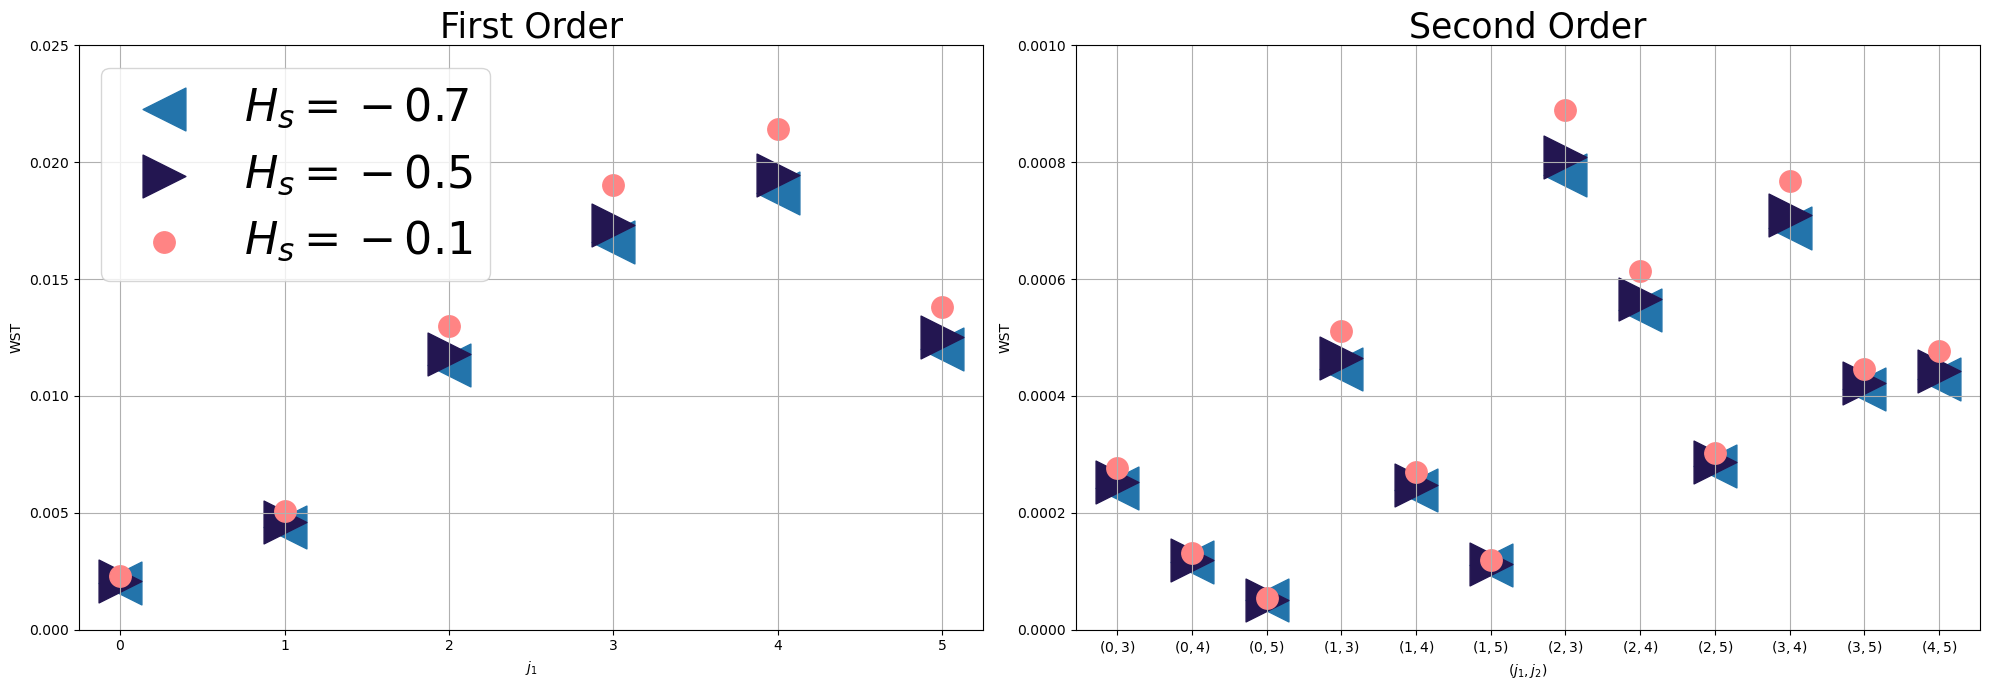

In [10]:
plt.rcParams["figure.figsize"] = [20.0,7.0]

ord_1_hs= np.array(first_ord)


fig, axs = plt.subplots(nrows=1, ncols=2)
coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$',r'$5$']




plt.subplots_adjust(wspace=0.4, hspace=0.4)

axs[0].scatter(coeff , ord_1_hs[0], marker='<', s=950, color='#2374AB', label =r'$H_s = -0.7$')
axs[0].scatter(coeff , ord_1_hs[1], marker = '>',color='#231651', s= 950, label =r'$H_s = -0.5$')
axs[0].scatter(coeff , ord_1_hs[2], marker = '.',color='#FF8484', s= 950, label =r'$H_s = -0.1$')


axs[0].grid('true')
axs[0].set_ylabel('WST')
axs[0].set_xlabel(r'$j_1$')


coeff=[r'$(0,3)$',r'$(0,4)$',r'$(0,5)$',r'$(1,3)$',r'$(1,4)$',r'$(1,5)$',r'$(2,3)$',r'$(2,4)$',r'$(2,5)$',r'$(3,4)$',r'$(3,5)$',r'$(4,5)$']
ord_2_hs= np.array(sec_ord)

axs[1].scatter(coeff , ord_2_hs[0], marker = '<',color='#2374AB', s= 950, label ='ns = 0.8')
axs[1].scatter(coeff , ord_2_hs[1], marker = '>',color='#231651', s= 950, label ='ns = 0.849')
axs[1].scatter(coeff , ord_2_hs[2], marker='.', s=950,color='#FF8484', label ='ns = 0.897')
axs[1].grid('true')
axs[1].set_ylabel('WST')
axs[1].set_xlabel(r'$(j_1,j_2)$')



axs[0].legend(loc='upper left', fontsize = 32)

axs[0].set_ylim([0,0.025])
axs[1].set_ylim([0,0.001])
#axs[2].set_ylim([0.065,0.085])

axs[0].set_title('First Order', size = 25)
axs[1].set_title('Second Order', size = 25)
#axs[2].set_title('Second Order', size = 25)
plt.tight_layout()
plt.savefig('hs1d.pdf')

In [11]:
sim_list=['/Users/Hurum/Documents/z=2/ns0.897As1.2e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
          '/Users/Hurum/Documents/z=2/ns0.897As1.55e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=2/ns0.897As2.25e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5' ]




scat_21=[]
for i in range(0,3):
    
    lya_file = h5py.File(sim_list[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))
    rescaled_tau = rescale_factor*all_tau
    all_flux = np.exp(-rescaled_tau)
    
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.29)
    res_in_cmp = (100 /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    all_flux= coarse_flux/np.mean(all_flux)
    
    scat=[]
    for i in range(0,32000):
        Sx = scattering(all_flux[i])
        Sx = Sx.mean(axis=1)
        scat.append(Sx)

    print(np.shape(scat))
    scat_21.append(scat)

scat_21 = np.array(scat_21)
scat_21 = scat_21.mean(axis=1)    
    
print(np.shape(scat_21))
first_ord= [scat_21[0][1:7],scat_21[1][1:7],scat_21[2][1:7]]
print(np.shape(first_ord))

sec_ord= [scat_21[0][7:19],scat_21[1][7:19],scat_21[2][7:19]]
print(np.shape(sec_ord))


(32000, 19)
(32000, 19)
(32000, 19)
(3, 19)
(3, 6)
(3, 12)


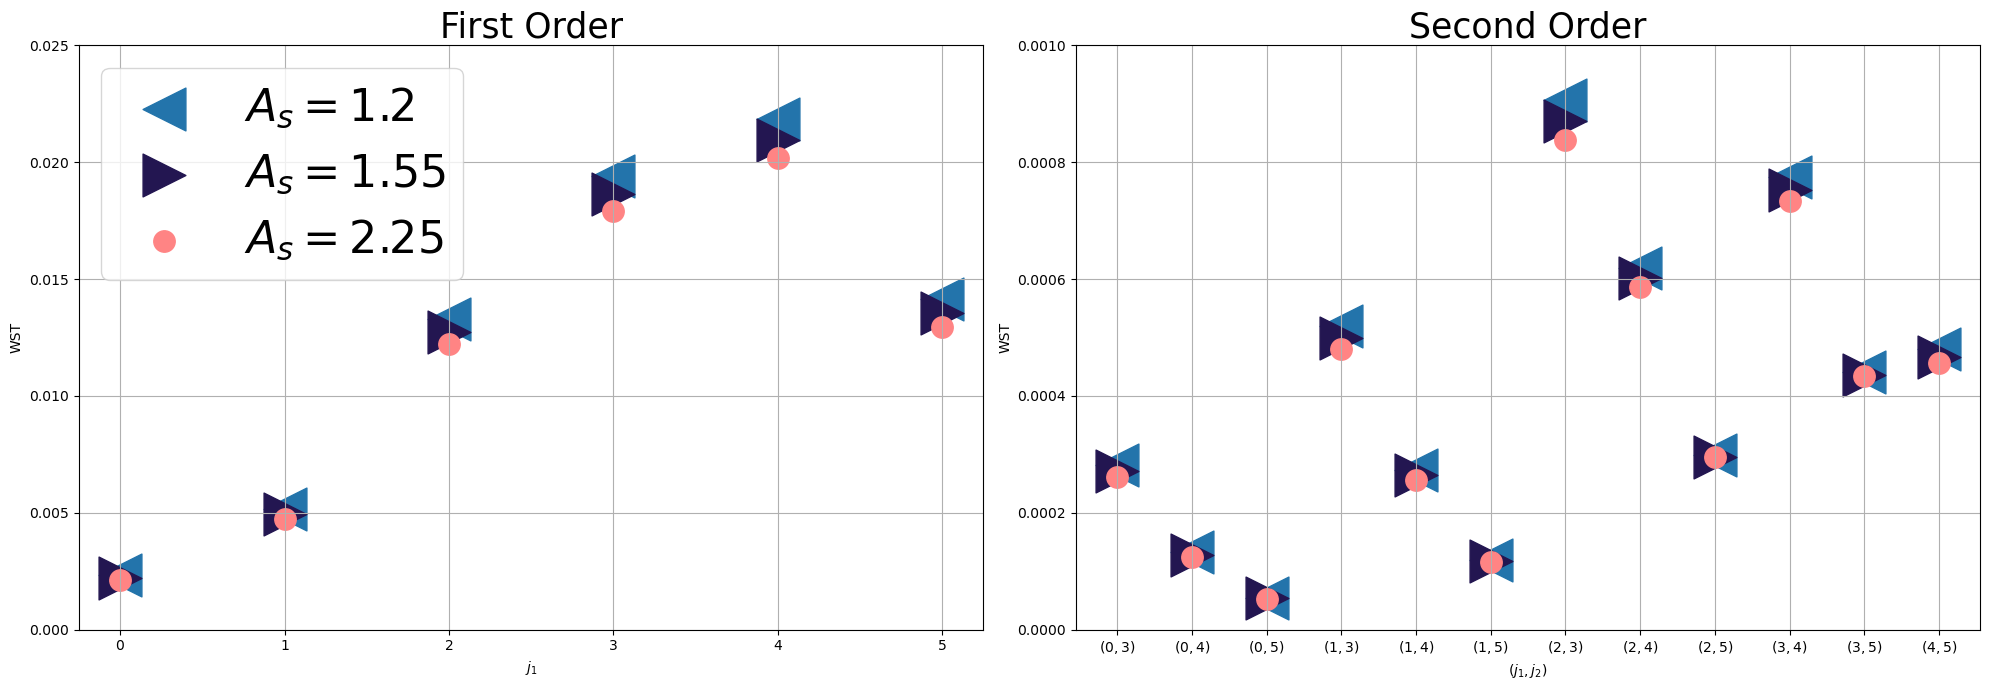

In [12]:
plt.rcParams["figure.figsize"] = [20.0,7.0]

ord_1_as= np.array(first_ord)


fig, axs = plt.subplots(nrows=1, ncols=2)
coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$',r'$5$']




plt.subplots_adjust(wspace=0.4, hspace=0.4)


axs[0].scatter(coeff , ord_1_as[0], marker = '<',color='#2374AB', s= 950, label =r'$A_s = 1.2$')
axs[0].scatter(coeff , ord_1_as[1], marker='>', s=950, color='#231651', label =r'$A_s = 1.55$')
axs[0].scatter(coeff , ord_1_as[2], marker = '.',color='#FF8484', s= 950, label =r'$A_s = 2.25$')
axs[0].grid('true')
axs[0].set_ylabel('WST')
axs[0].set_xlabel(r'$j_1$')

coeff=[r'$(0,3)$',r'$(0,4)$',r'$(0,5)$',r'$(1,3)$',r'$(1,4)$',r'$(1,5)$',r'$(2,3)$',r'$(2,4)$',r'$(2,5)$',r'$(3,4)$',r'$(3,5)$',r'$(4,5)$']

ord_2_as= np.array(sec_ord)

axs[1].scatter(coeff , ord_2_as[0], marker = '<',color='#2374AB', s= 950, label ='ns = 0.8')
axs[1].scatter(coeff , ord_2_as[1], marker = '>',color='#231651', s= 950, label ='ns = 0.849')
axs[1].scatter(coeff , ord_2_as[2], marker='.', s=950,color='#FF8484', label ='ns = 0.897')
axs[1].grid('true')
axs[1].set_ylabel('WST')
axs[1].set_xlabel(r'$(j_1,j_2)$')



axs[0].legend(loc='upper left', fontsize = 32)

axs[0].set_ylim([0,0.025])
axs[1].set_ylim([0,0.001])
#axs[2].set_ylim([0.065,0.085])

axs[0].set_title('First Order', size = 25)
axs[1].set_title('Second Order', size = 25)
#axs[2].set_title('Second Order', size = 25)
plt.tight_layout()
plt.savefig('as1d.pdf')

In [13]:
sim_list=['/Users/Hurum/Documents/z=2/ns0.897As1.9e-09heat_slope-0.3heat_amp0.65hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=2/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5',
'/Users/Hurum/Documents/z=2/ns0.897As1.9e-09heat_slope-0.3heat_amp1.4hub0.7/lya_forest_spectra.hdf5' ]


scat_21=[]
for i in range(0,3):
    
    lya_file = h5py.File(sim_list[i], 'r')
    all_tau = lya_file['tau']['H']['1']['1215'][:]
    rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))
    rescaled_tau = rescale_factor*all_tau
    all_flux = np.exp(-rescaled_tau)
    
    boxsize = lya_file['Header'].attrs['box']/1000
    z= scale_factor_to_redshift(.29)
    res_in_cmp = (100 /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    all_flux= coarse_flux/np.mean(all_flux)
    
    scat=[]
    for i in range(0,32000):
        Sx = scattering(all_flux[i])
        Sx = Sx.mean(axis=1)
        scat.append(Sx)

    print(np.shape(scat))
    scat_21.append(scat)

scat_21 = np.array(scat_21)
scat_21 = scat_21.mean(axis=1)    
    
print(np.shape(scat_21))
first_ord= [scat_21[0][1:7],scat_21[1][1:7],scat_21[2][1:7]]
print(np.shape(first_ord))

sec_ord= [scat_21[0][7:19],scat_21[1][7:19],scat_21[2][7:19]]
print(np.shape(sec_ord))


(32000, 19)
(32000, 19)
(32000, 19)
(3, 19)
(3, 6)
(3, 12)


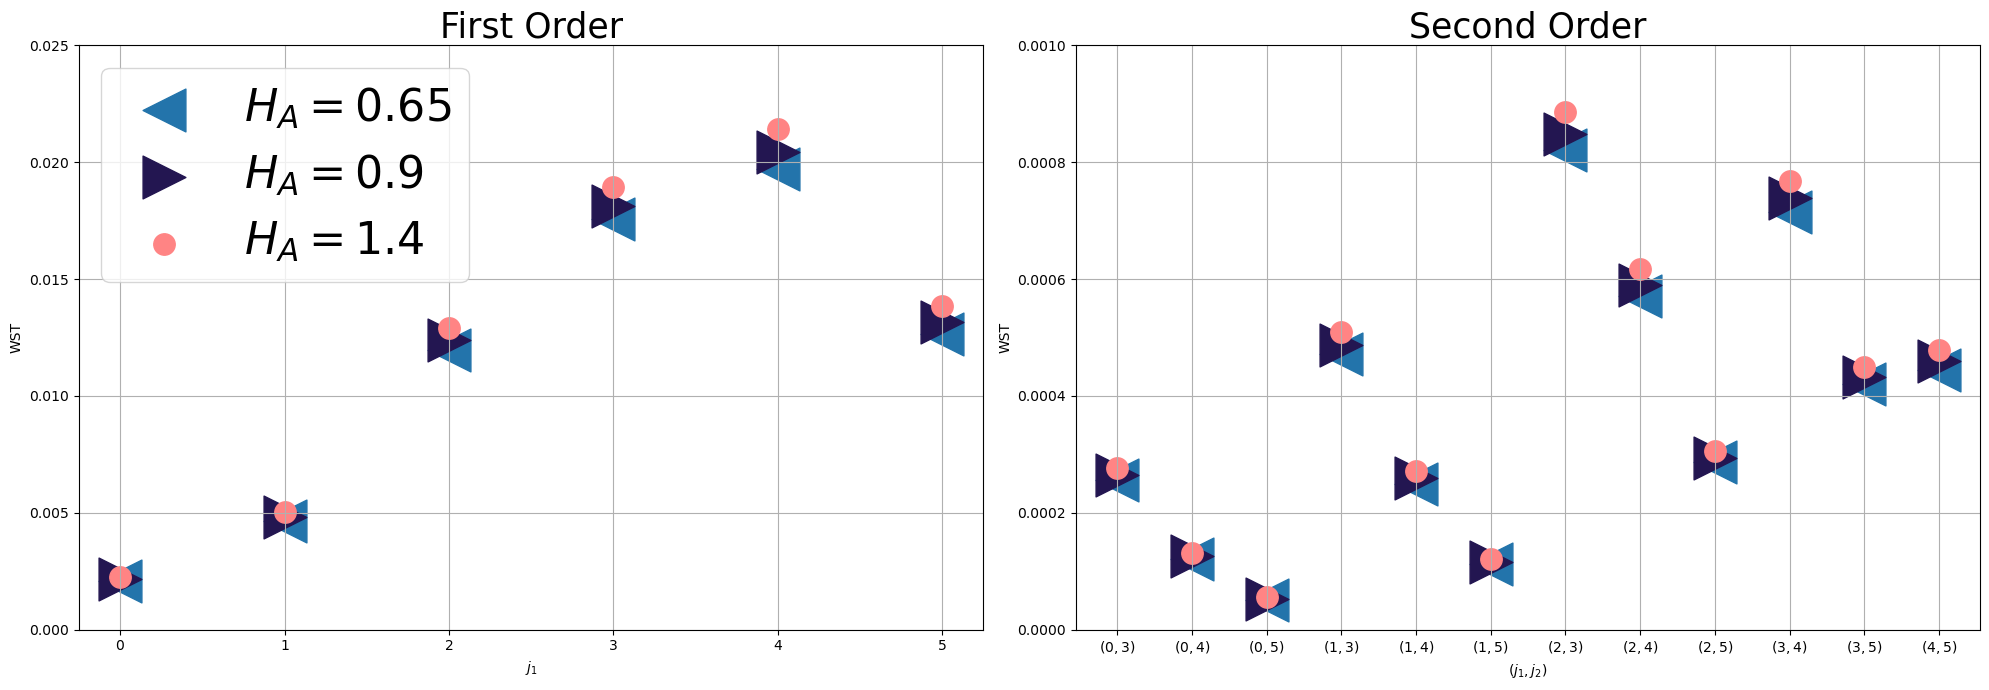

In [14]:
plt.rcParams["figure.figsize"] = [20.0,7.0]


ord_1_ha= np.array(first_ord)


fig, axs = plt.subplots(nrows=1, ncols=2)
coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$',r'$5$']


plt.subplots_adjust(wspace=0.4, hspace=0.4)

axs[0].scatter(coeff , ord_1_ha[0], marker = '<',color='#2374AB', s= 950, label =r'$H_A = 0.65$')
axs[0].scatter(coeff , ord_1_ha[1], marker = '>',color='#231651', s= 950, label =r'$H_A = 0.9$')
axs[0].scatter(coeff , ord_1_ha[2], marker='.', s=950, color='#FF8484', label =r'$H_A = 1.4$')
axs[0].grid('true')
axs[0].set_ylabel('WST')
axs[0].set_xlabel(r'$j_1$')


coeff=[r'$(0,3)$',r'$(0,4)$',r'$(0,5)$',r'$(1,3)$',r'$(1,4)$',r'$(1,5)$',r'$(2,3)$',r'$(2,4)$',r'$(2,5)$',r'$(3,4)$',r'$(3,5)$',r'$(4,5)$']
ord_2_ha= np.array(sec_ord)

axs[1].scatter(coeff , ord_2_ha[0], marker = '<',color='#2374AB', s= 950, label ='ns = 0.8')
axs[1].scatter(coeff , ord_2_ha[1], marker = '>',color='#231651', s= 950, label ='ns = 0.849')
axs[1].scatter(coeff , ord_2_ha[2], marker='.', s=950,color='#FF8484', label ='ns = 0.897')
axs[1].grid('true')
axs[1].set_ylabel('WST')
axs[1].set_xlabel(r'$(j_1,j_2)$')



axs[0].legend(loc='upper left', fontsize = 32)

axs[0].set_ylim([0,0.025])
axs[1].set_ylim([0,0.001])
#axs[2].set_ylim([0.065,0.085])

axs[0].set_title('First Order', size = 25)
axs[1].set_title('Second Order', size = 25)
#axs[2].set_title('Second Order', size = 25)
plt.tight_layout()
plt.savefig('ha1d.pdf')

In [15]:
print(np.shape(ord_2_ns))

(3, 12)


/Users/Hurum/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


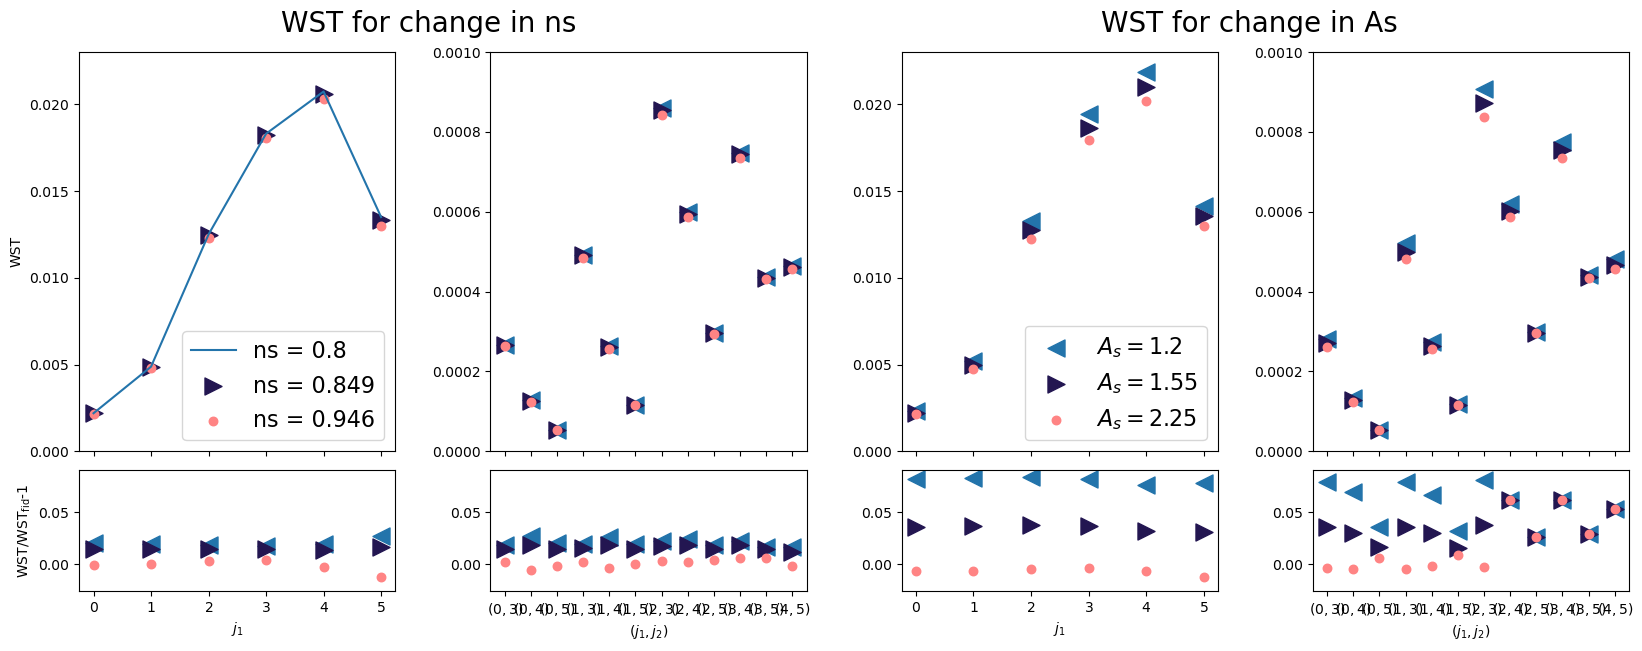

In [16]:
coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$', r'$5$']


fig = plt.figure(figsize=(20, 7))
grid = plt.GridSpec(4, 4, hspace=0.15, wspace=0.3)


big_ax = fig.add_subplot(grid[0:3, 0])
big_ax.plot(coeff , ord_1_ns[0], color='#2374AB', label ='ns = 0.8')
big_ax.scatter(coeff , ord_1_ns[1], marker = '>',color='#231651', s= 150, label ='ns = 0.849')
big_ax.scatter(coeff , ord_1_ns[2], marker='.', s=150, color='#FF8484', label ='ns = 0.946')
big_ax.set_ylim([0,0.023])
big_ax.legend(loc='lower right', fontsize=16)
big_ax.xaxis.set_tick_params(labelbottom=False)
big_ax.set_ylabel('WST')

small_ax = fig.add_subplot(grid[3, 0], sharex=big_ax)
small_ax.scatter(coeff , [ord_1_ns[0][0]/ord_1_fid[0]-1 ,ord_1_ns[0][1]/ord_1_fid[1]-1 , ord_1_ns[0][2]/ord_1_fid[2]-1, ord_1_ns[0][3]/ord_1_fid[3]-1 ,ord_1_ns[0][4]/ord_1_fid[4]-1 ,ord_1_ns[0][5]/ord_1_fid[5]-1], marker = '<',color='#2374AB', s= 150, label ='ns = 0.8')
small_ax.scatter(coeff , [ord_1_ns[1][0]/ord_1_fid[0]-1 ,ord_1_ns[1][1]/ord_1_fid[1]-1 , ord_1_ns[1][2]/ord_1_fid[2]-1, ord_1_ns[1][3]/ord_1_fid[3]-1 ,ord_1_ns[1][4]/ord_1_fid[4]-1 ,ord_1_ns[1][5]/ord_1_fid[5]-1], marker = '>',color='#231651', s= 150, label ='ns = 0.849')
small_ax.scatter(coeff , [ord_1_ns[2][0]/ord_1_fid[0]-1 ,ord_1_ns[2][1]/ord_1_fid[1]-1 , ord_1_ns[2][2]/ord_1_fid[2]-1, ord_1_ns[2][3]/ord_1_fid[3]-1 ,ord_1_ns[2][4]/ord_1_fid[4]-1 ,ord_1_ns[2][5]/ord_1_fid[5]-1], marker='.', s=150, color='#FF8484', label ='ns = 0.897')

small_ax.set_xlabel(r'$j_1$')
small_ax.set_ylim([-0.025,0.09])
small_ax.set_ylabel(r'WST/WST$_{\mathrm{fid}}$-1')

coeff=[r'$(0,3)$',r'$(0,4)$',r'$(0,5)$',r'$(1,3)$',r'$(1,4)$',r'$(1,5)$',r'$(2,3)$',r'$(2,4)$',r'$(2,5)$',r'$(3,4)$',r'$(3,5)$',r'$(4,5)$']


big_ax = fig.add_subplot(grid[0:3, 1])
big_ax.scatter(coeff , ord_2_ns[0], marker = '<',color='#2374AB', s= 150, label ='ns = 0.8')
big_ax.scatter(coeff , ord_2_ns[1], marker = '>',color='#231651', s= 150, label ='ns = 0.849')
big_ax.scatter(coeff , ord_2_ns[2], marker='.', s=150, color='#FF8484', label ='ns = 0.946')
big_ax.set_ylim([0,0.001])
big_ax.xaxis.set_tick_params(labelbottom=False)
    
small_ax = fig.add_subplot(grid[3, 1], sharex=big_ax)
small_ax.scatter(coeff , [ord_2_ns[0][0]/ord_2_fid[0]-1 ,ord_2_ns[0][1]/ord_2_fid[1]-1 , ord_2_ns[0][2]/ord_2_fid[2]-1, ord_2_ns[0][3]/ord_2_fid[3]-1 ,ord_2_ns[0][4]/ord_2_fid[4]-1,ord_2_ns[0][5]/ord_2_fid[5]-1,ord_2_ns[0][6]/ord_2_fid[6]-1,ord_2_ns[0][7]/ord_2_fid[7]-1,ord_2_ns[0][8]/ord_2_fid[8]-1,ord_2_ns[0][9]/ord_2_fid[9]-1,ord_2_ns[0][10]/ord_2_fid[10]-1,ord_2_ns[0][11]/ord_2_fid[11]-1], marker = '<',color='#2374AB', s= 150, label ='ns = 0.8')
small_ax.scatter(coeff , [ord_2_ns[1][0]/ord_2_fid[0]-1 ,ord_2_ns[1][1]/ord_2_fid[1]-1 , ord_2_ns[1][2]/ord_2_fid[2]-1, ord_2_ns[1][3]/ord_2_fid[3]-1 ,ord_2_ns[1][4]/ord_2_fid[4]-1,ord_2_ns[1][5]/ord_2_fid[5]-1,ord_2_ns[1][6]/ord_2_fid[6]-1,ord_2_ns[1][7]/ord_2_fid[7]-1,ord_2_ns[1][8]/ord_2_fid[8]-1,ord_2_ns[1][9]/ord_2_fid[9]-1,ord_2_ns[1][10]/ord_2_fid[10]-1,ord_2_ns[1][11]/ord_2_fid[11]-1], marker = '>',color='#231651', s= 150, label ='ns = 0.849')
small_ax.scatter(coeff , [ord_2_ns[2][0]/ord_2_fid[0]-1 ,ord_2_ns[2][1]/ord_2_fid[1]-1 , ord_2_ns[2][2]/ord_2_fid[2]-1, ord_2_ns[2][3]/ord_2_fid[3]-1 ,ord_2_ns[2][4]/ord_2_fid[4]-1,ord_2_ns[2][5]/ord_2_fid[5]-1,ord_2_ns[2][6]/ord_2_fid[6]-1,ord_2_ns[2][7]/ord_2_fid[7]-1,ord_2_ns[2][8]/ord_2_fid[8]-1,ord_2_ns[2][9]/ord_2_fid[9]-1,ord_2_ns[2][10]/ord_2_fid[10]-1,ord_2_ns[2][11]/ord_2_fid[11]-1], marker='.', s=150, color='#FF8484', label ='ns = 0.897')
small_ax.set_ylim([-0.025,0.09])
small_ax.set_xlabel(r'$(j_1,j_2)$')


coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$',r'$5$']
big_ax = fig.add_subplot(grid[0:3, 2])
big_ax.scatter(coeff , ord_1_as[0], marker = '<',color='#2374AB', s= 150, label =r'$A_s = 1.2$')
big_ax.scatter(coeff , ord_1_as[1], marker='>', s=150, color='#231651', label =r'$A_s = 1.55$')
big_ax.scatter(coeff , ord_1_as[2], marker = '.',color='#FF8484', s= 150, label =r'$A_s = 2.25$')
big_ax.set_ylim([0,0.023])
big_ax.legend(loc='lower right', fontsize=16)
big_ax.xaxis.set_tick_params(labelbottom=False)

small_ax = fig.add_subplot(grid[3, 2], sharex=big_ax)

small_ax.scatter(coeff , [ord_1_as[0][0]/ord_1_fid[0]-1 ,ord_1_as[0][1]/ord_1_fid[1]-1 , ord_1_as[0][2]/ord_1_fid[2]-1, ord_1_as[0][3]/ord_1_fid[3]-1 ,ord_1_as[0][4]/ord_1_fid[4]-1,ord_1_as[0][5]/ord_1_fid[5]-1], marker = '<',color='#2374AB', s= 150, label =r'$A_s = 1.2$')
small_ax.scatter(coeff , [ord_1_as[1][0]/ord_1_fid[0]-1 ,ord_1_as[1][1]/ord_1_fid[1]-1 , ord_1_as[1][2]/ord_1_fid[2]-1, ord_1_as[1][3]/ord_1_fid[3]-1 ,ord_1_as[1][4]/ord_1_fid[4]-1,ord_1_as[1][5]/ord_1_fid[5]-1], marker='>', s=150, color='#231651', label =r'$A_s = 1.55$')
small_ax.scatter(coeff , [ord_1_as[2][0]/ord_1_fid[0]-1 ,ord_1_as[2][1]/ord_1_fid[1]-1 , ord_1_as[2][2]/ord_1_fid[2]-1, ord_1_as[2][3]/ord_1_fid[3]-1 ,ord_1_as[2][4]/ord_1_fid[4]-1,ord_1_as[2][5]/ord_1_fid[5]-1], marker = '.',color='#FF8484', s= 150, label =r'$A_s = 2.25$')
small_ax.set_ylim([-0.025,0.09])
small_ax.set_xlabel(r'$j_1$')

coeff=[r'$(0,3)$',r'$(0,4)$',r'$(0,5)$',r'$(1,3)$',r'$(1,4)$',r'$(1,5)$',r'$(2,3)$',r'$(2,4)$',r'$(2,5)$',r'$(3,4)$',r'$(3,5)$',r'$(4,5)$']

big_ax = fig.add_subplot(grid[0:3, 3])
big_ax.scatter(coeff , ord_2_as[0], marker = '<',color='#2374AB', s= 150, label ='ns = 0.8')
big_ax.scatter(coeff , ord_2_as[1], marker = '>',color='#231651', s= 150, label ='ns = 0.849')
big_ax.scatter(coeff , ord_2_as[2], marker='.', s=150, color='#FF8484', label ='ns = 0.897')
big_ax.set_ylim([0,0.001])

big_ax.xaxis.set_tick_params(labelbottom=False)
    
small_ax = fig.add_subplot(grid[3, 3], sharex=big_ax)
small_ax.scatter(coeff , [ord_2_as[0][0]/ord_2_fid[0]-1 ,ord_2_as[0][1]/ord_2_fid[1]-1 , ord_2_as[0][2]/ord_2_fid[2]-1, ord_2_as[0][3]/ord_2_fid[3]-1 ,ord_2_as[0][4]/ord_2_fid[4]-1,ord_2_as[0][5]/ord_2_fid[5]-1,ord_2_as[0][6]/ord_2_fid[6]-1,ord_2_as[0][7]/ord_2_fid[7]-1,ord_2_as[0][8]/ord_2_fid[8]-1,ord_2_as[0][9]/ord_2_fid[9]-1,ord_2_as[0][10]/ord_2_fid[10]-1,ord_2_as[0][11]/ord_2_fid[11]-1], marker = '<',color='#2374AB', s= 150, label =r'$A_s = 1.2$')
small_ax.scatter(coeff , [ord_2_as[1][0]/ord_2_fid[0]-1 ,ord_2_as[1][1]/ord_2_fid[1]-1 , ord_2_as[1][2]/ord_2_fid[2]-1, ord_2_as[1][3]/ord_2_fid[3]-1 ,ord_2_as[1][4]/ord_2_fid[4]-1,ord_2_as[1][5]/ord_2_fid[5]-1,ord_2_as[1][6]/ord_2_fid[6]-1,ord_2_as[0][7]/ord_2_fid[7]-1,ord_2_as[0][8]/ord_2_fid[8]-1,ord_2_as[0][9]/ord_2_fid[9]-1,ord_2_as[0][10]/ord_2_fid[10]-1,ord_2_as[0][11]/ord_2_fid[11]-1], marker='>', s=150, color='#231651', label =r'$A_s = 1.55$')
small_ax.scatter(coeff , [ord_2_as[2][0]/ord_2_fid[0]-1 ,ord_2_as[2][1]/ord_2_fid[1]-1 , ord_2_as[2][2]/ord_2_fid[2]-1, ord_2_as[2][3]/ord_2_fid[3]-1 ,ord_2_as[2][4]/ord_2_fid[4]-1,ord_2_as[2][5]/ord_2_fid[5]-1,ord_2_as[2][6]/ord_2_fid[6]-1,ord_2_as[0][7]/ord_2_fid[7]-1,ord_2_as[0][8]/ord_2_fid[8]-1,ord_2_as[0][9]/ord_2_fid[9]-1,ord_2_as[0][10]/ord_2_fid[10]-1,ord_2_as[0][11]/ord_2_fid[11]-1], marker = '.',color='#FF8484', s= 150, label =r'$A_s = 2.25$')
small_ax.set_xlabel(r'$(j_1,j_2)$')
small_ax.set_ylim([-0.025,0.09])



    
fig.text(0.3, 0.92, "WST for change in ns", ha='center', va='center', fontsize=20)
fig.text(0.71, 0.92, "WST for change in As", ha='center', va='center', fontsize=20)

plt.tight_layout()
#plt.savefig('ns_as_with_zoom_in.pdf')
plt.show()


/Users/Hurum/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


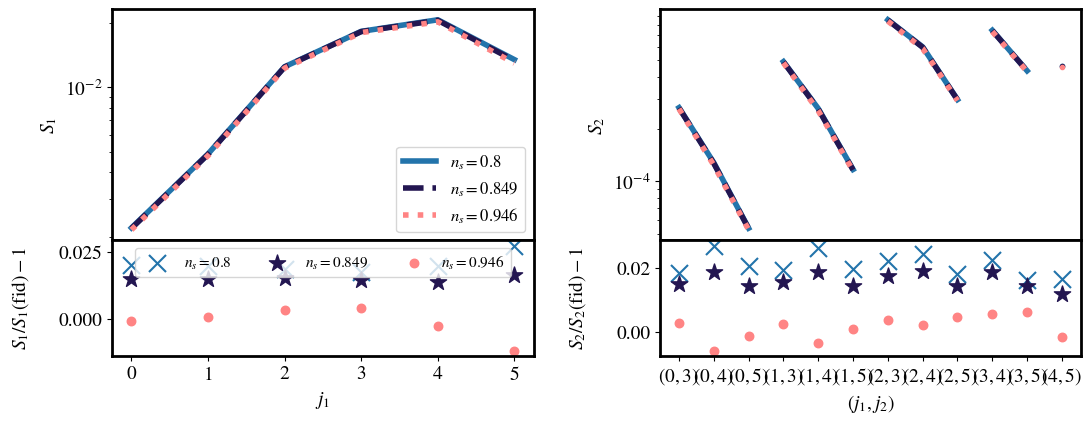

In [41]:
coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$', r'$5$']


fig = plt.figure(figsize=(12.5,9))
grid = plt.GridSpec(4, 2, hspace=0, wspace=0.3, height_ratios=[2, 1, 2, 1])


big_ax = fig.add_subplot(grid[0:1, 0])
big_ax.plot(coeff , ord_1_ns[0] , color='#2374AB', label =r'$n_s = 0.8$', linewidth =4)
big_ax.plot(coeff , ord_1_ns[1], color='#231651', linestyle='dashed',  label =r'$n_s = 0.849$', linewidth =4)
big_ax.plot(coeff , ord_1_ns[2],   color='#FF8484',  linestyle='dotted', label =r'$n_s = 0.946$', linewidth =4)
#big_ax.set_ylim([0,0.023])
big_ax.set_yscale('log')
big_ax.legend(loc='lower right', fontsize=12)
big_ax.xaxis.set_tick_params(labelbottom=False)
big_ax.set_ylabel(r'$S_1$')

small_ax = fig.add_subplot(grid[1, 0], sharex=big_ax)
small_ax.scatter(coeff , [ord_1_ns[0][0]/ord_1_fid[0]-1 ,ord_1_ns[0][1]/ord_1_fid[1]-1 , ord_1_ns[0][2]/ord_1_fid[2]-1, ord_1_ns[0][3]/ord_1_fid[3]-1 ,ord_1_ns[0][4]/ord_1_fid[4]-1 ,ord_1_ns[0][5]/ord_1_fid[5]-1], marker = 'x',color='#2374AB', s= 150, label =r'$n_s = 0.8$')
small_ax.scatter(coeff , [ord_1_ns[1][0]/ord_1_fid[0]-1 ,ord_1_ns[1][1]/ord_1_fid[1]-1 , ord_1_ns[1][2]/ord_1_fid[2]-1, ord_1_ns[1][3]/ord_1_fid[3]-1 ,ord_1_ns[1][4]/ord_1_fid[4]-1 ,ord_1_ns[1][5]/ord_1_fid[5]-1], marker = '*',color='#231651', s= 150, label =r'$n_s = 0.849$')
small_ax.scatter(coeff , [ord_1_ns[2][0]/ord_1_fid[0]-1 ,ord_1_ns[2][1]/ord_1_fid[1]-1 , ord_1_ns[2][2]/ord_1_fid[2]-1, ord_1_ns[2][3]/ord_1_fid[3]-1 ,ord_1_ns[2][4]/ord_1_fid[4]-1 ,ord_1_ns[2][5]/ord_1_fid[5]-1], marker='.', s=150, color='#FF8484', label =r'$n_s = 0.946$')

small_ax.set_xlabel(r'$j_1$')
small_ax.legend( ncol=3, loc='upper center', fontsize=11)

small_ax.set_ylabel(r'$S_1$/${S_1}{\mathrm{(fid)}}-1$', labelpad=20)

coeff=[r'$(0,3)$',r'$(0,4)$',r'$(0,5)$',r'$(1,3)$',r'$(1,4)$',r'$(1,5)$',r'$(2,3)$',r'$(2,4)$',r'$(2,5)$',r'$(3,4)$',r'$(3,5)$',r'$(4,5)$']


big_ax = fig.add_subplot(grid[0:1, 1])
big_ax.plot([coeff[0],coeff[1],coeff[2]] , [ord_2_ns[0][0],ord_2_ns[0][1],ord_2_ns[0][2]],color='#2374AB', label ='$n_s = 0.8$', linewidth =4)
big_ax.plot([coeff[3],coeff[4],coeff[5]] , [ord_2_ns[0][3],ord_2_ns[0][4],ord_2_ns[0][5]],color='#2374AB',  label ='$n_s = 0.8$', linewidth =4)
big_ax.plot([coeff[6],coeff[7],coeff[8]] , [ord_2_ns[0][6],ord_2_ns[0][7],ord_2_ns[0][8]],color='#2374AB', label ='$n_s = 0.8$', linewidth =4)
big_ax.plot([coeff[9],coeff[10]] , [ord_2_ns[0][9],ord_2_ns[0][10]],color='#2374AB', label ='$n_s = 0.8$', linewidth =4)
big_ax.scatter([coeff[11]] , [ord_2_ns[0][11]],color='#2374AB', marker='.', label ='$n_s = 0.8$')


big_ax.plot([coeff[0],coeff[1],coeff[2]], [ord_2_ns[1][0],ord_2_ns[1][1],ord_2_ns[1][2]],color='#231651',linestyle='dashed', label ='$n_s = 0.849$', linewidth =4)
big_ax.plot([coeff[3],coeff[4],coeff[5]], [ord_2_ns[1][3],ord_2_ns[1][4],ord_2_ns[1][5]],color='#231651', linestyle='dashed', label ='$n_s = 0.849$', linewidth =4)
big_ax.plot([coeff[6],coeff[7],coeff[8]], [ord_2_ns[1][6],ord_2_ns[1][7],ord_2_ns[1][8]],color='#231651', linestyle='dashed', label ='$n_s = 0.849$', linewidth =4)
big_ax.plot([coeff[9],coeff[10]] ,  [ord_2_ns[1][9],ord_2_ns[1][10]],color='#231651',linestyle='dashed', label ='$n_s = 0.849$', linewidth =4)
big_ax.scatter([coeff[11]] ,[ord_2_ns[1][11]],color='#231651',marker='.', label ='$n_s = 0.849$')

big_ax.plot([coeff[0],coeff[1],coeff[2]] , [ord_2_ns[2][0],ord_2_ns[2][1],ord_2_ns[2][2]], color='#FF8484', linestyle='dotted',label ='$n_s = 0.946$', linewidth =4)
big_ax.plot([coeff[3],coeff[4],coeff[5]], [ord_2_ns[2][3],ord_2_ns[2][4],ord_2_ns[2][5]], color='#FF8484', linestyle='dotted', label ='$n_s = 0.946$', linewidth =4)
big_ax.plot([coeff[6],coeff[7],coeff[8]] ,[ord_2_ns[2][6],ord_2_ns[2][7],ord_2_ns[2][8]], color='#FF8484',linestyle='dotted', label ='$n_s = 0.946$', linewidth =4)                          
big_ax.plot([coeff[9],coeff[10]], [ord_2_ns[2][9],ord_2_ns[2][10]], color='#FF8484', linestyle='dotted', label ='$n_s = 0.946$', linewidth =4)
big_ax.scatter([coeff[11]] ,[ord_2_ns[2][11]], color='#FF8484',marker='.', label ='$n_s = 0.946$')
big_ax.set_ylabel(r'$S_2$')                          
                          
big_ax.set_yscale('log')

big_ax.xaxis.set_tick_params(labelbottom=False)
    
small_ax = fig.add_subplot(grid[1, 1], sharex=big_ax)
small_ax.scatter(coeff , [ord_2_ns[0][0]/ord_2_fid[0]-1 ,ord_2_ns[0][1]/ord_2_fid[1]-1 , ord_2_ns[0][2]/ord_2_fid[2]-1, ord_2_ns[0][3]/ord_2_fid[3]-1 ,ord_2_ns[0][4]/ord_2_fid[4]-1,ord_2_ns[0][5]/ord_2_fid[5]-1,ord_2_ns[0][6]/ord_2_fid[6]-1,ord_2_ns[0][7]/ord_2_fid[7]-1,ord_2_ns[0][8]/ord_2_fid[8]-1,ord_2_ns[0][9]/ord_2_fid[9]-1,ord_2_ns[0][10]/ord_2_fid[10]-1,ord_2_ns[0][11]/ord_2_fid[11]-1], marker = 'x',color='#2374AB', s= 150, label ='ns = 0.8')
small_ax.scatter(coeff , [ord_2_ns[1][0]/ord_2_fid[0]-1 ,ord_2_ns[1][1]/ord_2_fid[1]-1 , ord_2_ns[1][2]/ord_2_fid[2]-1, ord_2_ns[1][3]/ord_2_fid[3]-1 ,ord_2_ns[1][4]/ord_2_fid[4]-1,ord_2_ns[1][5]/ord_2_fid[5]-1,ord_2_ns[1][6]/ord_2_fid[6]-1,ord_2_ns[1][7]/ord_2_fid[7]-1,ord_2_ns[1][8]/ord_2_fid[8]-1,ord_2_ns[1][9]/ord_2_fid[9]-1,ord_2_ns[1][10]/ord_2_fid[10]-1,ord_2_ns[1][11]/ord_2_fid[11]-1], marker = '*',color='#231651', s= 150, label ='ns = 0.849')
small_ax.scatter(coeff , [ord_2_ns[2][0]/ord_2_fid[0]-1 ,ord_2_ns[2][1]/ord_2_fid[1]-1 , ord_2_ns[2][2]/ord_2_fid[2]-1, ord_2_ns[2][3]/ord_2_fid[3]-1 ,ord_2_ns[2][4]/ord_2_fid[4]-1,ord_2_ns[2][5]/ord_2_fid[5]-1,ord_2_ns[2][6]/ord_2_fid[6]-1,ord_2_ns[2][7]/ord_2_fid[7]-1,ord_2_ns[2][8]/ord_2_fid[8]-1,ord_2_ns[2][9]/ord_2_fid[9]-1,ord_2_ns[2][10]/ord_2_fid[10]-1,ord_2_ns[2][11]/ord_2_fid[11]-1], marker='.', s=150, color='#FF8484', label ='ns = 0.897')


small_ax.set_ylabel(r'$S_2$/${S_2}{\mathrm{(fid)}}-1$', labelpad=20)
small_ax.set_xlabel(r'$(j_1,j_2)$')
plt.tight_layout()
plt.savefig('ns_1d_.pdf',bbox_inches='tight')

/Users/Hurum/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


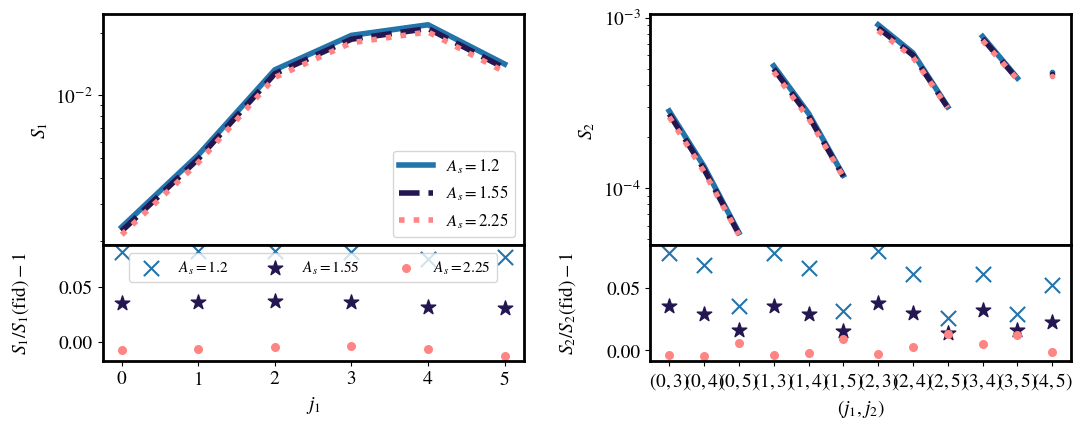

In [40]:
coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$', r'$5$']


fig = plt.figure(figsize=(12.5,9))
grid = plt.GridSpec(4, 2, hspace=0, wspace=0.3, height_ratios=[2, 1, 2, 1])


big_ax = fig.add_subplot(grid[0:1, 0])
big_ax.plot(coeff , ord_1_as[0] , color='#2374AB', label =r'$A_s = 1.2$', linewidth =4)
big_ax.plot(coeff , ord_1_as[1], color='#231651', linestyle='dashed',  label =r'$A_s = 1.55$', linewidth =4)
big_ax.plot(coeff , ord_1_as[2],   color='#FF8484',  linestyle='dotted', label =r'$A_s = 2.25$', linewidth =4)
#big_ax.set_ylim([0,0.023])
big_ax.set_yscale('log')
big_ax.legend(loc='lower right', fontsize=12)
big_ax.xaxis.set_tick_params(labelbottom=False)
big_ax.set_ylabel('WST')
big_ax.set_ylabel(r'$S_1$')

small_ax = fig.add_subplot(grid[1, 0], sharex=big_ax)
small_ax.scatter(coeff , [ord_1_as[0][0]/ord_1_fid[0]-1 ,ord_1_as[0][1]/ord_1_fid[1]-1 , ord_1_as[0][2]/ord_1_fid[2]-1, ord_1_as[0][3]/ord_1_fid[3]-1 ,ord_1_as[0][4]/ord_1_fid[4]-1 ,ord_1_as[0][5]/ord_1_fid[5]-1], marker = 'x',color='#2374AB', s= 120, label =r'$A_s = 1.2$')
small_ax.scatter(coeff , [ord_1_as[1][0]/ord_1_fid[0]-1 ,ord_1_as[1][1]/ord_1_fid[1]-1 , ord_1_as[1][2]/ord_1_fid[2]-1, ord_1_as[1][3]/ord_1_fid[3]-1 ,ord_1_as[1][4]/ord_1_fid[4]-1 ,ord_1_as[1][5]/ord_1_fid[5]-1], marker = '*',color='#231651', s= 120, label =r'$A_s = 1.55$')
small_ax.scatter(coeff , [ord_1_as[2][0]/ord_1_fid[0]-1 ,ord_1_as[2][1]/ord_1_fid[1]-1 , ord_1_as[2][2]/ord_1_fid[2]-1, ord_1_as[2][3]/ord_1_fid[3]-1 ,ord_1_as[2][4]/ord_1_fid[4]-1 ,ord_1_as[2][5]/ord_1_fid[5]-1], marker='.', s=120, color='#FF8484', label =r'$A_s = 2.25$')

small_ax.set_ylabel(r'$S_1$/${S_1}{\mathrm{(fid)}}-1$', labelpad=20)
small_ax.set_xlabel(r'$j_1$')
small_ax.legend( ncol=3, loc='upper center', fontsize=11)


coeff=[r'$(0,3)$',r'$(0,4)$',r'$(0,5)$',r'$(1,3)$',r'$(1,4)$',r'$(1,5)$',r'$(2,3)$',r'$(2,4)$',r'$(2,5)$',r'$(3,4)$',r'$(3,5)$',r'$(4,5)$']


big_ax = fig.add_subplot(grid[0:1, 1])
big_ax.plot([coeff[0],coeff[1],coeff[2]] , [ord_2_as[0][0],ord_2_as[0][1],ord_2_as[0][2]],color='#2374AB', label ='$n_s = 0.8$', linewidth =4)
big_ax.plot([coeff[3],coeff[4],coeff[5]] , [ord_2_as[0][3],ord_2_as[0][4],ord_2_as[0][5]],color='#2374AB',  label ='$n_s = 0.8$', linewidth =4)
big_ax.plot([coeff[6],coeff[7],coeff[8]] , [ord_2_as[0][6],ord_2_as[0][7],ord_2_as[0][8]],color='#2374AB', label ='$n_s = 0.8$', linewidth =4)
big_ax.plot([coeff[9],coeff[10]] , [ord_2_as[0][9],ord_2_as[0][10]],color='#2374AB', label ='$n_s = 0.8$', linewidth =4)
big_ax.scatter([coeff[11]] , [ord_2_as[0][11]],color='#2374AB', marker='.', label ='$n_s = 0.8$')


big_ax.plot([coeff[0],coeff[1],coeff[2]], [ord_2_as[1][0],ord_2_as[1][1],ord_2_as[1][2]],color='#231651',linestyle='dashed', label ='$n_s = 0.849$', linewidth =4)
big_ax.plot([coeff[3],coeff[4],coeff[5]], [ord_2_as[1][3],ord_2_as[1][4],ord_2_as[1][5]],color='#231651', linestyle='dashed', label ='$n_s = 0.849$', linewidth =4)
big_ax.plot([coeff[6],coeff[7],coeff[8]], [ord_2_as[1][6],ord_2_as[1][7],ord_2_as[1][8]],color='#231651', linestyle='dashed', label ='$n_s = 0.849$', linewidth =4)
big_ax.plot([coeff[9],coeff[10]] ,  [ord_2_as[1][9],ord_2_as[1][10]],color='#231651',linestyle='dashed', label ='$n_s = 0.849$', linewidth =4)
big_ax.scatter([coeff[11]] ,[ord_2_as[1][11]],color='#231651',marker='.', label ='$n_s = 0.849$')

big_ax.plot([coeff[0],coeff[1],coeff[2]] , [ord_2_as[2][0],ord_2_as[2][1],ord_2_as[2][2]], color='#FF8484', linestyle='dotted',label ='$n_s = 0.946$', linewidth =4)
big_ax.plot([coeff[3],coeff[4],coeff[5]], [ord_2_as[2][3],ord_2_as[2][4],ord_2_as[2][5]], color='#FF8484', linestyle='dotted', label ='$n_s = 0.946$', linewidth =4)
big_ax.plot([coeff[6],coeff[7],coeff[8]] ,[ord_2_as[2][6],ord_2_as[2][7],ord_2_as[2][8]], color='#FF8484',linestyle='dotted', label ='$n_s = 0.946$', linewidth =4)                          
big_ax.plot([coeff[9],coeff[10]], [ord_2_as[2][9],ord_2_as[2][10]], color='#FF8484', linestyle='dotted', label ='$n_s = 0.946$', linewidth =4)
big_ax.scatter([coeff[11]] ,[ord_2_as[2][11]], color='#FF8484',marker='.', label ='$n_s = 0.946$')
                          
big_ax.set_ylabel(r'$S_2$')                           
big_ax.set_yscale('log')

big_ax.xaxis.set_tick_params(labelbottom=False)
    
small_ax = fig.add_subplot(grid[1, 1], sharex=big_ax)
small_ax.scatter(coeff , [ord_2_as[0][0]/ord_2_fid[0]-1 ,ord_2_as[0][1]/ord_2_fid[1]-1 , ord_2_as[0][2]/ord_2_fid[2]-1, ord_2_as[0][3]/ord_2_fid[3]-1 ,ord_2_as[0][4]/ord_2_fid[4]-1,ord_2_as[0][5]/ord_2_fid[5]-1,ord_2_as[0][6]/ord_2_fid[6]-1,ord_2_as[0][7]/ord_2_fid[7]-1,ord_2_as[0][8]/ord_2_fid[8]-1,ord_2_as[0][9]/ord_2_fid[9]-1,ord_2_as[0][10]/ord_2_fid[10]-1,ord_2_as[0][11]/ord_2_fid[11]-1], marker = 'x',color='#2374AB', s= 120, label ='ns = 0.8')
small_ax.scatter(coeff , [ord_2_as[1][0]/ord_2_fid[0]-1 ,ord_2_as[1][1]/ord_2_fid[1]-1 , ord_2_as[1][2]/ord_2_fid[2]-1, ord_2_as[1][3]/ord_2_fid[3]-1 ,ord_2_as[1][4]/ord_2_fid[4]-1,ord_2_as[1][5]/ord_2_fid[5]-1,ord_2_as[1][6]/ord_2_fid[6]-1,ord_2_as[1][7]/ord_2_fid[7]-1,ord_2_as[1][8]/ord_2_fid[8]-1,ord_2_as[1][9]/ord_2_fid[9]-1,ord_2_as[1][10]/ord_2_fid[10]-1,ord_2_as[1][11]/ord_2_fid[11]-1], marker = '*',color='#231651', s= 120, label ='ns = 0.849')
small_ax.scatter(coeff , [ord_2_as[2][0]/ord_2_fid[0]-1 ,ord_2_as[2][1]/ord_2_fid[1]-1 , ord_2_as[2][2]/ord_2_fid[2]-1, ord_2_as[2][3]/ord_2_fid[3]-1 ,ord_2_as[2][4]/ord_2_fid[4]-1,ord_2_as[2][5]/ord_2_fid[5]-1,ord_2_as[2][6]/ord_2_fid[6]-1,ord_2_as[2][7]/ord_2_fid[7]-1,ord_2_as[2][8]/ord_2_fid[8]-1,ord_2_as[2][9]/ord_2_fid[9]-1,ord_2_as[2][10]/ord_2_fid[10]-1,ord_2_as[2][11]/ord_2_fid[11]-1], marker='.', s=120, color='#FF8484', label ='ns = 0.897')

small_ax.set_ylabel(r'$S_2$/${S_2}{\mathrm{(fid)}}-1$', labelpad=20)
small_ax.set_xlabel(r'$(j_1,j_2)$')
plt.tight_layout()
plt.savefig('as_1d_.pdf',bbox_inches='tight')

/Users/Hurum/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


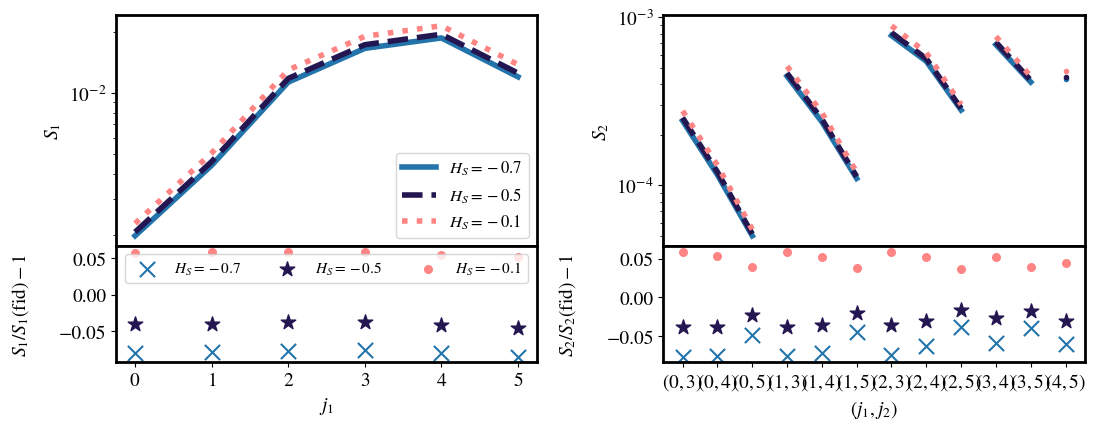

In [39]:
coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$', r'$5$']


fig = plt.figure(figsize=(12.5,9))
grid = plt.GridSpec(4, 2, hspace=0, wspace=0.3, height_ratios=[2, 1, 2, 1])


big_ax = fig.add_subplot(grid[0:1, 0])
big_ax.plot(coeff , ord_1_hs[0] , color='#2374AB', label =r'$H_S = -0.7$', linewidth =4)
big_ax.plot(coeff , ord_1_hs[1], color='#231651', linestyle='dashed',  label =r'$H_S = -0.5$', linewidth =4)
big_ax.plot(coeff , ord_1_hs[2],   color='#FF8484',  linestyle='dotted', label =r'$H_S = -0.1$', linewidth =4)
#big_ax.set_ylim([0,0.023])
big_ax.set_yscale('log')
big_ax.legend(loc='lower right', fontsize=12)
big_ax.xaxis.set_tick_params(labelbottom=False)
big_ax.set_ylabel('WST')
big_ax.set_ylabel(r'$S_1$')
small_ax = fig.add_subplot(grid[1, 0], sharex=big_ax)
small_ax.scatter(coeff , [ord_1_hs[0][0]/ord_1_fid[0]-1 ,ord_1_hs[0][1]/ord_1_fid[1]-1 , ord_1_hs[0][2]/ord_1_fid[2]-1, ord_1_hs[0][3]/ord_1_fid[3]-1 ,ord_1_hs[0][4]/ord_1_fid[4]-1 ,ord_1_hs[0][5]/ord_1_fid[5]-1], marker = 'x',color='#2374AB', s= 120, label =r'$H_S = -0.7$')
small_ax.scatter(coeff , [ord_1_hs[1][0]/ord_1_fid[0]-1 ,ord_1_hs[1][1]/ord_1_fid[1]-1 , ord_1_hs[1][2]/ord_1_fid[2]-1, ord_1_hs[1][3]/ord_1_fid[3]-1 ,ord_1_hs[1][4]/ord_1_fid[4]-1 ,ord_1_hs[1][5]/ord_1_fid[5]-1], marker = '*',color='#231651', s= 120, label =r'$H_S = -0.5$')
small_ax.scatter(coeff , [ord_1_hs[2][0]/ord_1_fid[0]-1 ,ord_1_hs[2][1]/ord_1_fid[1]-1 , ord_1_hs[2][2]/ord_1_fid[2]-1, ord_1_hs[2][3]/ord_1_fid[3]-1 ,ord_1_hs[2][4]/ord_1_fid[4]-1 ,ord_1_hs[2][5]/ord_1_fid[5]-1], marker='.', s=120, color='#FF8484', label =r'$H_S = -0.1$')

small_ax.set_xlabel(r'$j_1$')
small_ax.legend( ncol=3, loc='upper center', fontsize=11)

small_ax.set_ylabel(r'$S_1$/${S_1}{\mathrm{(fid)}}-1$', labelpad=20)
coeff=[r'$(0,3)$',r'$(0,4)$',r'$(0,5)$',r'$(1,3)$',r'$(1,4)$',r'$(1,5)$',r'$(2,3)$',r'$(2,4)$',r'$(2,5)$',r'$(3,4)$',r'$(3,5)$',r'$(4,5)$']


big_ax = fig.add_subplot(grid[0:1, 1])
big_ax.plot([coeff[0],coeff[1],coeff[2]] , [ord_2_hs[0][0],ord_2_hs[0][1],ord_2_hs[0][2]],color='#2374AB', label ='$n_s = 0.8$', linewidth =4)
big_ax.plot([coeff[3],coeff[4],coeff[5]] , [ord_2_hs[0][3],ord_2_hs[0][4],ord_2_hs[0][5]],color='#2374AB',  label ='$n_s = 0.8$', linewidth =4)
big_ax.plot([coeff[6],coeff[7],coeff[8]] , [ord_2_hs[0][6],ord_2_hs[0][7],ord_2_hs[0][8]],color='#2374AB', label ='$n_s = 0.8$', linewidth =4)
big_ax.plot([coeff[9],coeff[10]] , [ord_2_hs[0][9],ord_2_hs[0][10]],color='#2374AB', label ='$n_s = 0.8$', linewidth =4)
big_ax.scatter([coeff[11]] , [ord_2_hs[0][11]],color='#2374AB', marker='.', label ='$n_s = 0.8$')


big_ax.plot([coeff[0],coeff[1],coeff[2]], [ord_2_hs[1][0],ord_2_hs[1][1],ord_2_hs[1][2]],color='#231651',linestyle='dashed', label ='$n_s = 0.849$', linewidth =4)
big_ax.plot([coeff[3],coeff[4],coeff[5]], [ord_2_hs[1][3],ord_2_hs[1][4],ord_2_hs[1][5]],color='#231651', linestyle='dashed', label ='$n_s = 0.849$', linewidth =4)
big_ax.plot([coeff[6],coeff[7],coeff[8]], [ord_2_hs[1][6],ord_2_hs[1][7],ord_2_hs[1][8]],color='#231651', linestyle='dashed', label ='$n_s = 0.849$', linewidth =4)
big_ax.plot([coeff[9],coeff[10]] ,  [ord_2_hs[1][9],ord_2_hs[1][10]],color='#231651',linestyle='dashed', label ='$n_s = 0.849$', linewidth =4)
big_ax.scatter([coeff[11]] ,[ord_2_hs[1][11]],color='#231651',marker='.', label ='$n_s = 0.849$')

big_ax.plot([coeff[0],coeff[1],coeff[2]] , [ord_2_hs[2][0],ord_2_hs[2][1],ord_2_hs[2][2]], color='#FF8484', linestyle='dotted',label ='$n_s = 0.946$', linewidth =4)
big_ax.plot([coeff[3],coeff[4],coeff[5]], [ord_2_hs[2][3],ord_2_hs[2][4],ord_2_hs[2][5]], color='#FF8484', linestyle='dotted', label ='$n_s = 0.946$', linewidth =4)
big_ax.plot([coeff[6],coeff[7],coeff[8]] ,[ord_2_hs[2][6],ord_2_hs[2][7],ord_2_hs[2][8]], color='#FF8484',linestyle='dotted', label ='$n_s = 0.946$', linewidth =4)                          
big_ax.plot([coeff[9],coeff[10]], [ord_2_hs[2][9],ord_2_hs[2][10]], color='#FF8484', linestyle='dotted', label ='$n_s = 0.946$', linewidth =4)
big_ax.scatter([coeff[11]] ,[ord_2_hs[2][11]], color='#FF8484',marker='.', label ='$n_s = 0.946$')
big_ax.set_ylabel(r'$S_2$')                          
                          
big_ax.set_yscale('log')

big_ax.xaxis.set_tick_params(labelbottom=False)
    
small_ax = fig.add_subplot(grid[1, 1], sharex=big_ax)
small_ax.scatter(coeff , [ord_2_hs[0][0]/ord_2_fid[0]-1 ,ord_2_hs[0][1]/ord_2_fid[1]-1 , ord_2_hs[0][2]/ord_2_fid[2]-1, ord_2_hs[0][3]/ord_2_fid[3]-1 ,ord_2_hs[0][4]/ord_2_fid[4]-1,ord_2_hs[0][5]/ord_2_fid[5]-1,ord_2_hs[0][6]/ord_2_fid[6]-1,ord_2_hs[0][7]/ord_2_fid[7]-1,ord_2_hs[0][8]/ord_2_fid[8]-1,ord_2_hs[0][9]/ord_2_fid[9]-1,ord_2_hs[0][10]/ord_2_fid[10]-1,ord_2_hs[0][11]/ord_2_fid[11]-1], marker = 'x',color='#2374AB', s= 120, label ='ns = 0.8')
small_ax.scatter(coeff , [ord_2_hs[1][0]/ord_2_fid[0]-1 ,ord_2_hs[1][1]/ord_2_fid[1]-1 , ord_2_hs[1][2]/ord_2_fid[2]-1, ord_2_hs[1][3]/ord_2_fid[3]-1 ,ord_2_hs[1][4]/ord_2_fid[4]-1,ord_2_hs[1][5]/ord_2_fid[5]-1,ord_2_hs[1][6]/ord_2_fid[6]-1,ord_2_hs[1][7]/ord_2_fid[7]-1,ord_2_hs[1][8]/ord_2_fid[8]-1,ord_2_hs[1][9]/ord_2_fid[9]-1,ord_2_hs[1][10]/ord_2_fid[10]-1,ord_2_hs[1][11]/ord_2_fid[11]-1], marker = '*',color='#231651', s= 120, label ='ns = 0.849')
small_ax.scatter(coeff , [ord_2_hs[2][0]/ord_2_fid[0]-1 ,ord_2_hs[2][1]/ord_2_fid[1]-1 , ord_2_hs[2][2]/ord_2_fid[2]-1, ord_2_hs[2][3]/ord_2_fid[3]-1 ,ord_2_hs[2][4]/ord_2_fid[4]-1,ord_2_hs[2][5]/ord_2_fid[5]-1,ord_2_hs[2][6]/ord_2_fid[6]-1,ord_2_hs[2][7]/ord_2_fid[7]-1,ord_2_hs[2][8]/ord_2_fid[8]-1,ord_2_hs[2][9]/ord_2_fid[9]-1,ord_2_hs[2][10]/ord_2_fid[10]-1,ord_2_hs[2][11]/ord_2_fid[11]-1], marker='.', s=120, color='#FF8484', label ='ns = 0.897')

small_ax.set_ylabel(r'$S_2$/${S_2}{\mathrm{(fid)}}-1$', labelpad=20)
small_ax.set_xlabel(r'$(j_1,j_2)$')
plt.tight_layout()
plt.savefig('hs_1d_.pdf',bbox_inches='tight')

/Users/Hurum/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


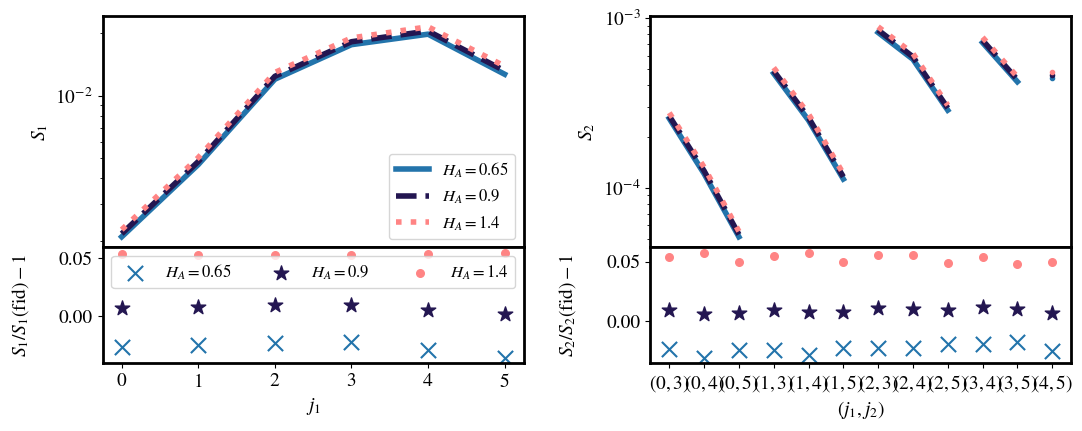

In [42]:
coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$', r'$5$']


fig = plt.figure(figsize=(12.5,9))
grid = plt.GridSpec(4, 2, hspace=0, wspace=0.3, height_ratios=[2, 1, 2, 1])


big_ax = fig.add_subplot(grid[0:1, 0])
big_ax.plot(coeff , ord_1_ha[0] , color='#2374AB', label =r'$H_A = 0.65$', linewidth =4)
big_ax.plot(coeff , ord_1_ha[1], color='#231651', linestyle='dashed',  label =r'$H_A = 0.9$', linewidth =4)
big_ax.plot(coeff , ord_1_ha[2],   color='#FF8484',  linestyle='dotted', label =r'$H_A = 1.4$', linewidth =4)
#big_ax.set_ylim([0,0.023])
big_ax.set_yscale('log')
big_ax.legend(loc='lower right', fontsize=12)
big_ax.xaxis.set_tick_params(labelbottom=False)
big_ax.set_ylabel('WST')
big_ax.set_ylabel(r'$S_1$')
small_ax = fig.add_subplot(grid[1, 0], sharex=big_ax)
small_ax.scatter(coeff , [ord_1_ha[0][0]/ord_1_fid[0]-1 ,ord_1_ha[0][1]/ord_1_fid[1]-1 , ord_1_ha[0][2]/ord_1_fid[2]-1, ord_1_ha[0][3]/ord_1_fid[3]-1 ,ord_1_ha[0][4]/ord_1_fid[4]-1 ,ord_1_ha[0][5]/ord_1_fid[5]-1], marker = 'x',color='#2374AB', s= 120, label =r'$H_A = 0.65$')
small_ax.scatter(coeff , [ord_1_ha[1][0]/ord_1_fid[0]-1 ,ord_1_ha[1][1]/ord_1_fid[1]-1 , ord_1_ha[1][2]/ord_1_fid[2]-1, ord_1_ha[1][3]/ord_1_fid[3]-1 ,ord_1_ha[1][4]/ord_1_fid[4]-1 ,ord_1_ha[1][5]/ord_1_fid[5]-1], marker = '*',color='#231651', s= 120, label =r'$H_A = 0.9$')
small_ax.scatter(coeff , [ord_1_ha[2][0]/ord_1_fid[0]-1 ,ord_1_ha[2][1]/ord_1_fid[1]-1 , ord_1_ha[2][2]/ord_1_fid[2]-1, ord_1_ha[2][3]/ord_1_fid[3]-1 ,ord_1_ha[2][4]/ord_1_fid[4]-1 ,ord_1_ha[2][5]/ord_1_fid[5]-1], marker='.', s=120, color='#FF8484', label =r'$H_A = 1.4$')

small_ax.set_xlabel(r'$j_1$')
small_ax.legend( ncol=3, loc='upper center', fontsize=12)

small_ax.set_ylabel(r'$S_1$/${S_1}{\mathrm{(fid)}}-1$', labelpad=20)

coeff=[r'$(0,3)$',r'$(0,4)$',r'$(0,5)$',r'$(1,3)$',r'$(1,4)$',r'$(1,5)$',r'$(2,3)$',r'$(2,4)$',r'$(2,5)$',r'$(3,4)$',r'$(3,5)$',r'$(4,5)$']


big_ax = fig.add_subplot(grid[0:1, 1])
big_ax.plot([coeff[0],coeff[1],coeff[2]] , [ord_2_ha[0][0],ord_2_ha[0][1],ord_2_ha[0][2]],color='#2374AB', label ='$n_s = 0.8$', linewidth =4)
big_ax.plot([coeff[3],coeff[4],coeff[5]] , [ord_2_ha[0][3],ord_2_ha[0][4],ord_2_ha[0][5]],color='#2374AB',  label ='$n_s = 0.8$', linewidth =4)
big_ax.plot([coeff[6],coeff[7],coeff[8]] , [ord_2_ha[0][6],ord_2_ha[0][7],ord_2_ha[0][8]],color='#2374AB', label ='$n_s = 0.8$', linewidth =4)
big_ax.plot([coeff[9],coeff[10]] , [ord_2_ha[0][9],ord_2_ha[0][10]],color='#2374AB', label ='$n_s = 0.8$', linewidth =4)
big_ax.scatter([coeff[11]] , [ord_2_ha[0][11]],color='#2374AB', marker='.', label ='$n_s = 0.8$')


big_ax.plot([coeff[0],coeff[1],coeff[2]], [ord_2_ha[1][0],ord_2_ha[1][1],ord_2_ha[1][2]],color='#231651',linestyle='dashed', label ='$n_s = 0.849$', linewidth =4)
big_ax.plot([coeff[3],coeff[4],coeff[5]], [ord_2_ha[1][3],ord_2_ha[1][4],ord_2_ha[1][5]],color='#231651', linestyle='dashed', label ='$n_s = 0.849$', linewidth =4)
big_ax.plot([coeff[6],coeff[7],coeff[8]], [ord_2_ha[1][6],ord_2_ha[1][7],ord_2_ha[1][8]],color='#231651', linestyle='dashed', label ='$n_s = 0.849$', linewidth =4)
big_ax.plot([coeff[9],coeff[10]] ,  [ord_2_ha[1][9],ord_2_ha[1][10]],color='#231651',linestyle='dashed', label ='$n_s = 0.849$', linewidth =4)
big_ax.scatter([coeff[11]] ,[ord_2_ha[1][11]],color='#231651',marker='.', label ='$n_s = 0.849$')

big_ax.plot([coeff[0],coeff[1],coeff[2]] , [ord_2_ha[2][0],ord_2_ha[2][1],ord_2_ha[2][2]], color='#FF8484', linestyle='dotted',label ='$n_s = 0.946$', linewidth =4)
big_ax.plot([coeff[3],coeff[4],coeff[5]], [ord_2_ha[2][3],ord_2_ha[2][4],ord_2_ha[2][5]], color='#FF8484', linestyle='dotted', label ='$n_s = 0.946$', linewidth =4)
big_ax.plot([coeff[6],coeff[7],coeff[8]] ,[ord_2_ha[2][6],ord_2_ha[2][7],ord_2_ha[2][8]], color='#FF8484',linestyle='dotted', label ='$n_s = 0.946$', linewidth =4)                          
big_ax.plot([coeff[9],coeff[10]], [ord_2_ha[2][9],ord_2_ha[2][10]], color='#FF8484', linestyle='dotted', label ='$n_s = 0.946$', linewidth =4)
big_ax.scatter([coeff[11]] ,[ord_2_ha[2][11]], color='#FF8484',marker='.', label ='$n_s = 0.946$')
big_ax.set_ylabel(r'$S_2$')                          
                          
big_ax.set_yscale('log')

big_ax.xaxis.set_tick_params(labelbottom=False)
    
small_ax = fig.add_subplot(grid[1, 1], sharex=big_ax)
small_ax.scatter(coeff , [ord_2_ha[0][0]/ord_2_fid[0]-1 ,ord_2_ha[0][1]/ord_2_fid[1]-1 , ord_2_ha[0][2]/ord_2_fid[2]-1, ord_2_ha[0][3]/ord_2_fid[3]-1 ,ord_2_ha[0][4]/ord_2_fid[4]-1,ord_2_ha[0][5]/ord_2_fid[5]-1,ord_2_ha[0][6]/ord_2_fid[6]-1,ord_2_ha[0][7]/ord_2_fid[7]-1,ord_2_ha[0][8]/ord_2_fid[8]-1,ord_2_ha[0][9]/ord_2_fid[9]-1,ord_2_ha[0][10]/ord_2_fid[10]-1,ord_2_ha[0][11]/ord_2_fid[11]-1], marker = 'x',color='#2374AB', s= 120, label ='ns = 0.8')
small_ax.scatter(coeff , [ord_2_ha[1][0]/ord_2_fid[0]-1 ,ord_2_ha[1][1]/ord_2_fid[1]-1 , ord_2_ha[1][2]/ord_2_fid[2]-1, ord_2_ha[1][3]/ord_2_fid[3]-1 ,ord_2_ha[1][4]/ord_2_fid[4]-1,ord_2_ha[1][5]/ord_2_fid[5]-1,ord_2_ha[1][6]/ord_2_fid[6]-1,ord_2_ha[1][7]/ord_2_fid[7]-1,ord_2_ha[1][8]/ord_2_fid[8]-1,ord_2_ha[1][9]/ord_2_fid[9]-1,ord_2_ha[1][10]/ord_2_fid[10]-1,ord_2_ha[1][11]/ord_2_fid[11]-1], marker = '*',color='#231651', s= 120, label ='ns = 0.849')
small_ax.scatter(coeff , [ord_2_ha[2][0]/ord_2_fid[0]-1 ,ord_2_ha[2][1]/ord_2_fid[1]-1 , ord_2_ha[2][2]/ord_2_fid[2]-1, ord_2_ha[2][3]/ord_2_fid[3]-1 ,ord_2_ha[2][4]/ord_2_fid[4]-1,ord_2_ha[2][5]/ord_2_fid[5]-1,ord_2_ha[2][6]/ord_2_fid[6]-1,ord_2_ha[2][7]/ord_2_fid[7]-1,ord_2_ha[2][8]/ord_2_fid[8]-1,ord_2_ha[2][9]/ord_2_fid[9]-1,ord_2_ha[2][10]/ord_2_fid[10]-1,ord_2_ha[2][11]/ord_2_fid[11]-1], marker='.', s=120, color='#FF8484', label ='ns = 0.897')
small_ax.set_ylabel(r'$S_2$/${S_2}{\mathrm{(fid)}}-1$', labelpad=20)
small_ax.set_xlabel(r'$(j_1,j_2)$')
plt.tight_layout()
plt.savefig('ha_1d_.pdf',bbox_inches='tight')

/Users/Hurum/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


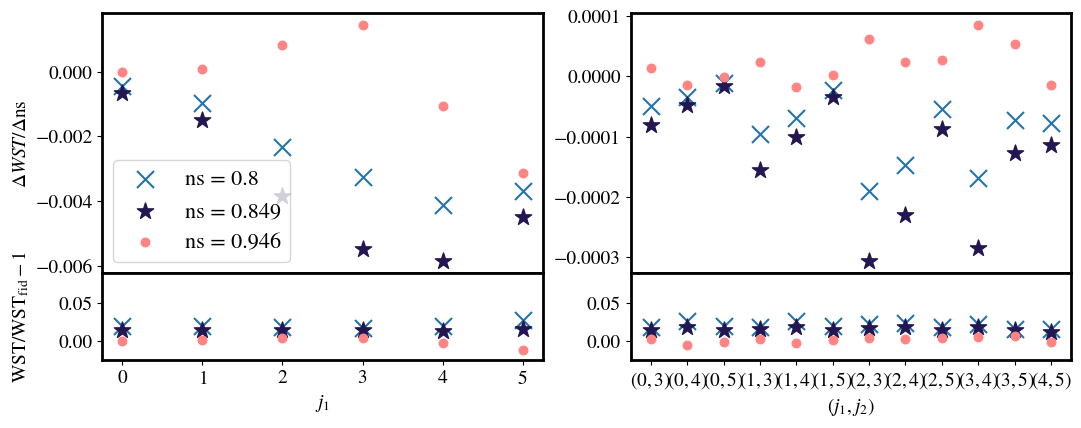

In [87]:
coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$', r'$5$']


fig = plt.figure(figsize=(12.5,9))
grid = plt.GridSpec(4, 2, hspace=0, wspace=0.2, height_ratios=[3, 1, 3, 1])


big_ax = fig.add_subplot(grid[0:1, 0])
big_ax.scatter(coeff , (ord_1_ns[0]-ord_1_fid)/(.8-.897) , marker = 'x',color='#2374AB', s= 150, label ='ns = 0.8')
big_ax.scatter(coeff , (ord_1_ns[1]-ord_1_fid)/(.849-.897), marker = '*',color='#231651', s= 150, label ='ns = 0.849')
big_ax.scatter(coeff , (ord_1_ns[2]-ord_1_fid)/(.946-.897), marker='.', s=150, color='#FF8484', label ='ns = 0.946')
#big_ax.set_ylim([0,0.023])
big_ax.legend(loc='lower left', fontsize=16)
big_ax.xaxis.set_tick_params(labelbottom=False)
big_ax.set_ylabel('$\Delta WST/ \Delta \mathrm{ns}$')

small_ax = fig.add_subplot(grid[1, 0], sharex=big_ax)
small_ax.scatter(coeff , [ord_1_ns[0][0]/ord_1_fid[0]-1 ,ord_1_ns[0][1]/ord_1_fid[1]-1 , ord_1_ns[0][2]/ord_1_fid[2]-1, ord_1_ns[0][3]/ord_1_fid[3]-1 ,ord_1_ns[0][4]/ord_1_fid[4]-1 ,ord_1_ns[0][5]/ord_1_fid[5]-1], marker = 'x',color='#2374AB', s= 150, label ='ns = 0.8')
small_ax.scatter(coeff , [ord_1_ns[1][0]/ord_1_fid[0]-1 ,ord_1_ns[1][1]/ord_1_fid[1]-1 , ord_1_ns[1][2]/ord_1_fid[2]-1, ord_1_ns[1][3]/ord_1_fid[3]-1 ,ord_1_ns[1][4]/ord_1_fid[4]-1 ,ord_1_ns[1][5]/ord_1_fid[5]-1], marker = '*',color='#231651', s= 150, label ='ns = 0.849')
small_ax.scatter(coeff , [ord_1_ns[2][0]/ord_1_fid[0]-1 ,ord_1_ns[2][1]/ord_1_fid[1]-1 , ord_1_ns[2][2]/ord_1_fid[2]-1, ord_1_ns[2][3]/ord_1_fid[3]-1 ,ord_1_ns[2][4]/ord_1_fid[4]-1 ,ord_1_ns[2][5]/ord_1_fid[5]-1], marker='.', s=150, color='#FF8484', label ='ns = 0.897')

small_ax.set_xlabel(r'$j_1$')
small_ax.set_ylim([-0.025,0.09])
small_ax.set_ylabel(r'WST/WST$_{\mathrm{fid}}-1$', labelpad=20)

coeff=[r'$(0,3)$',r'$(0,4)$',r'$(0,5)$',r'$(1,3)$',r'$(1,4)$',r'$(1,5)$',r'$(2,3)$',r'$(2,4)$',r'$(2,5)$',r'$(3,4)$',r'$(3,5)$',r'$(4,5)$']


big_ax = fig.add_subplot(grid[0:1, 1])
big_ax.scatter(coeff , (ord_2_ns[0]-ord_2_fid)/(.8-.897), marker = 'x',color='#2374AB', s= 150, label ='ns = 0.8')
big_ax.scatter(coeff , (ord_2_ns[1]-ord_2_fid)/(.849-.897), marker = '*',color='#231651', s= 150, label ='ns = 0.849')
big_ax.scatter(coeff , (ord_2_ns[2]-ord_2_fid)/(.946-.897), marker='.', s=150, color='#FF8484', label ='ns = 0.946')

big_ax.xaxis.set_tick_params(labelbottom=False)
    
small_ax = fig.add_subplot(grid[1, 1], sharex=big_ax)
small_ax.scatter(coeff , [ord_2_ns[0][0]/ord_2_fid[0]-1 ,ord_2_ns[0][1]/ord_2_fid[1]-1 , ord_2_ns[0][2]/ord_2_fid[2]-1, ord_2_ns[0][3]/ord_2_fid[3]-1 ,ord_2_ns[0][4]/ord_2_fid[4]-1,ord_2_ns[0][5]/ord_2_fid[5]-1,ord_2_ns[0][6]/ord_2_fid[6]-1,ord_2_ns[0][7]/ord_2_fid[7]-1,ord_2_ns[0][8]/ord_2_fid[8]-1,ord_2_ns[0][9]/ord_2_fid[9]-1,ord_2_ns[0][10]/ord_2_fid[10]-1,ord_2_ns[0][11]/ord_2_fid[11]-1], marker = 'x',color='#2374AB', s= 150, label ='ns = 0.8')
small_ax.scatter(coeff , [ord_2_ns[1][0]/ord_2_fid[0]-1 ,ord_2_ns[1][1]/ord_2_fid[1]-1 , ord_2_ns[1][2]/ord_2_fid[2]-1, ord_2_ns[1][3]/ord_2_fid[3]-1 ,ord_2_ns[1][4]/ord_2_fid[4]-1,ord_2_ns[1][5]/ord_2_fid[5]-1,ord_2_ns[1][6]/ord_2_fid[6]-1,ord_2_ns[1][7]/ord_2_fid[7]-1,ord_2_ns[1][8]/ord_2_fid[8]-1,ord_2_ns[1][9]/ord_2_fid[9]-1,ord_2_ns[1][10]/ord_2_fid[10]-1,ord_2_ns[1][11]/ord_2_fid[11]-1], marker = '*',color='#231651', s= 150, label ='ns = 0.849')
small_ax.scatter(coeff , [ord_2_ns[2][0]/ord_2_fid[0]-1 ,ord_2_ns[2][1]/ord_2_fid[1]-1 , ord_2_ns[2][2]/ord_2_fid[2]-1, ord_2_ns[2][3]/ord_2_fid[3]-1 ,ord_2_ns[2][4]/ord_2_fid[4]-1,ord_2_ns[2][5]/ord_2_fid[5]-1,ord_2_ns[2][6]/ord_2_fid[6]-1,ord_2_ns[2][7]/ord_2_fid[7]-1,ord_2_ns[2][8]/ord_2_fid[8]-1,ord_2_ns[2][9]/ord_2_fid[9]-1,ord_2_ns[2][10]/ord_2_fid[10]-1,ord_2_ns[2][11]/ord_2_fid[11]-1], marker='.', s=150, color='#FF8484', label ='ns = 0.897')
small_ax.set_ylim([-0.025,0.09])
small_ax.set_xlabel(r'$(j_1,j_2)$')
plt.tight_layout()
plt.savefig('ns_1d_.pdf')

/Users/Hurum/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


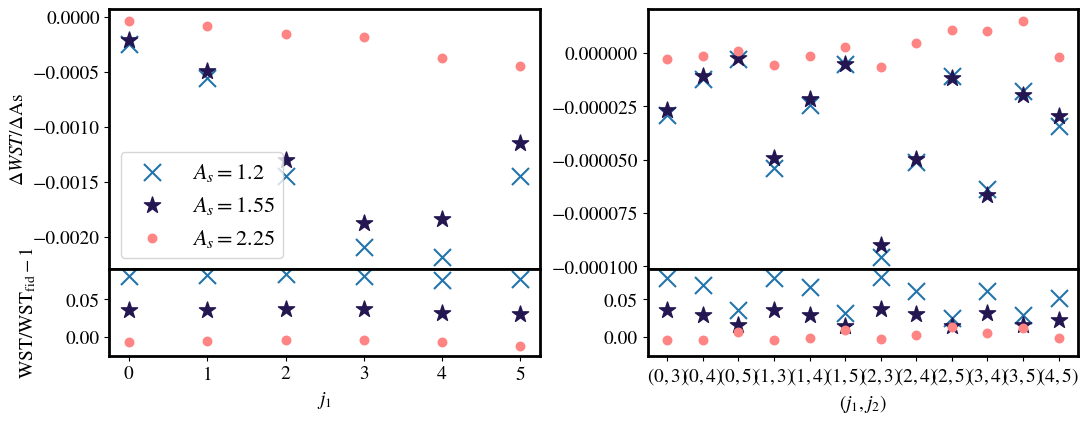

In [94]:
coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$', r'$5$']


fig = plt.figure(figsize=(12.5,9))
grid = plt.GridSpec(4, 2, hspace=0, wspace=0.25, height_ratios=[3, 1, 3, 1])


coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$',r'$5$']
big_ax = fig.add_subplot(grid[0:1, 0])
big_ax.scatter(coeff , (ord_1_as[0]-ord_1_fid)/(1.2-1.9), marker = 'x',color='#2374AB', s= 150, label =r'$A_s = 1.2$')
big_ax.scatter(coeff , (ord_1_as[1]-ord_1_fid)/(1.55-1.9), marker='*', s=150, color='#231651', label =r'$A_s = 1.55$')
big_ax.scatter(coeff , (ord_1_as[2]-ord_1_fid)/(2.25-1.9), marker = '.',color='#FF8484', s= 150, label =r'$A_s = 2.25$')

big_ax.legend(loc='lower left', fontsize=16)
big_ax.set_ylabel('WST')
big_ax.set_ylabel('$\Delta WST/ \Delta \mathrm{As}$')
big_ax.xaxis.set_tick_params(labelbottom=False)

small_ax = fig.add_subplot(grid[1, 0], sharex=big_ax)

small_ax.scatter(coeff , [ord_1_as[0][0]/ord_1_fid[0]-1 ,ord_1_as[0][1]/ord_1_fid[1]-1 , ord_1_as[0][2]/ord_1_fid[2]-1, ord_1_as[0][3]/ord_1_fid[3]-1 ,ord_1_as[0][4]/ord_1_fid[4]-1,ord_1_as[0][5]/ord_1_fid[5]-1], marker = 'x',color='#2374AB', s= 150, label =r'$A_s = 1.2$')
small_ax.scatter(coeff , [ord_1_as[1][0]/ord_1_fid[0]-1 ,ord_1_as[1][1]/ord_1_fid[1]-1 , ord_1_as[1][2]/ord_1_fid[2]-1, ord_1_as[1][3]/ord_1_fid[3]-1 ,ord_1_as[1][4]/ord_1_fid[4]-1,ord_1_as[1][5]/ord_1_fid[5]-1], marker='*', s=150, color='#231651', label =r'$A_s = 1.55$')
small_ax.scatter(coeff , [ord_1_as[2][0]/ord_1_fid[0]-1 ,ord_1_as[2][1]/ord_1_fid[1]-1 , ord_1_as[2][2]/ord_1_fid[2]-1, ord_1_as[2][3]/ord_1_fid[3]-1 ,ord_1_as[2][4]/ord_1_fid[4]-1,ord_1_as[2][5]/ord_1_fid[5]-1], marker = '.',color='#FF8484', s= 150, label =r'$A_s = 2.25$')
small_ax.set_ylim([-0.025,0.09])
small_ax.set_xlabel(r'$j_1$')
small_ax.set_ylabel(r'WST/WST$_{\mathrm{fid}}-1$', labelpad=20)


coeff=[r'$(0,3)$',r'$(0,4)$',r'$(0,5)$',r'$(1,3)$',r'$(1,4)$',r'$(1,5)$',r'$(2,3)$',r'$(2,4)$',r'$(2,5)$',r'$(3,4)$',r'$(3,5)$',r'$(4,5)$']

big_ax = fig.add_subplot(grid[0:1, 1])
big_ax.scatter(coeff , (ord_2_as[0]-ord_2_fid)/(1.2-1.9), marker = 'x',color='#2374AB', s= 150, label ='ns = 0.8')
big_ax.scatter(coeff , (ord_2_as[1]-ord_2_fid)/(1.55-1.9), marker = '*',color='#231651', s= 150, label ='ns = 0.849')
big_ax.scatter(coeff , (ord_2_as[2]-ord_2_fid)/(2.25-1.9), marker='.', s=150, color='#FF8484', label ='ns = 0.897')


big_ax.xaxis.set_tick_params(labelbottom=False)
    
small_ax = fig.add_subplot(grid[1, 1], sharex=big_ax)
small_ax.scatter(coeff , [ord_2_as[0][0]/ord_2_fid[0]-1 ,ord_2_as[0][1]/ord_2_fid[1]-1 , ord_2_as[0][2]/ord_2_fid[2]-1, ord_2_as[0][3]/ord_2_fid[3]-1 ,ord_2_as[0][4]/ord_2_fid[4]-1,ord_2_as[0][5]/ord_2_fid[5]-1,ord_2_as[0][6]/ord_2_fid[6]-1,ord_2_as[0][7]/ord_2_fid[7]-1,ord_2_as[0][8]/ord_2_fid[8]-1,ord_2_as[0][9]/ord_2_fid[9]-1,ord_2_as[0][10]/ord_2_fid[10]-1,ord_2_as[0][11]/ord_2_fid[11]-1], marker = 'x',color='#2374AB', s= 150, label =r'$A_s = 1.2$')
small_ax.scatter(coeff , [ord_2_as[1][0]/ord_2_fid[0]-1 ,ord_2_as[1][1]/ord_2_fid[1]-1 , ord_2_as[1][2]/ord_2_fid[2]-1, ord_2_as[1][3]/ord_2_fid[3]-1 ,ord_2_as[1][4]/ord_2_fid[4]-1,ord_2_as[1][5]/ord_2_fid[5]-1,ord_2_as[1][6]/ord_2_fid[6]-1,ord_2_as[1][7]/ord_2_fid[7]-1,ord_2_as[1][8]/ord_2_fid[8]-1,ord_2_as[1][9]/ord_2_fid[9]-1,ord_2_as[1][10]/ord_2_fid[10]-1,ord_2_as[1][11]/ord_2_fid[11]-1], marker='*', s=150, color='#231651', label =r'$A_s = 1.55$')
small_ax.scatter(coeff , [ord_2_as[2][0]/ord_2_fid[0]-1 ,ord_2_as[2][1]/ord_2_fid[1]-1 , ord_2_as[2][2]/ord_2_fid[2]-1, ord_2_as[2][3]/ord_2_fid[3]-1 ,ord_2_as[2][4]/ord_2_fid[4]-1,ord_2_as[2][5]/ord_2_fid[5]-1,ord_2_as[2][6]/ord_2_fid[6]-1,ord_2_as[2][7]/ord_2_fid[7]-1,ord_2_as[2][8]/ord_2_fid[8]-1,ord_2_as[2][9]/ord_2_fid[9]-1,ord_2_as[2][10]/ord_2_fid[10]-1,ord_2_as[2][11]/ord_2_fid[11]-1], marker = '.',color='#FF8484', s= 150, label =r'$A_s = 2.25$')
small_ax.set_xlabel(r'$(j_1,j_2)$')
small_ax.set_ylim([-0.025,0.09])


plt.tight_layout()
plt.savefig('As_1d_.pdf')
#plt.savefig('ns_as_with_zoom_in.pdf')
plt.show()

/Users/Hurum/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


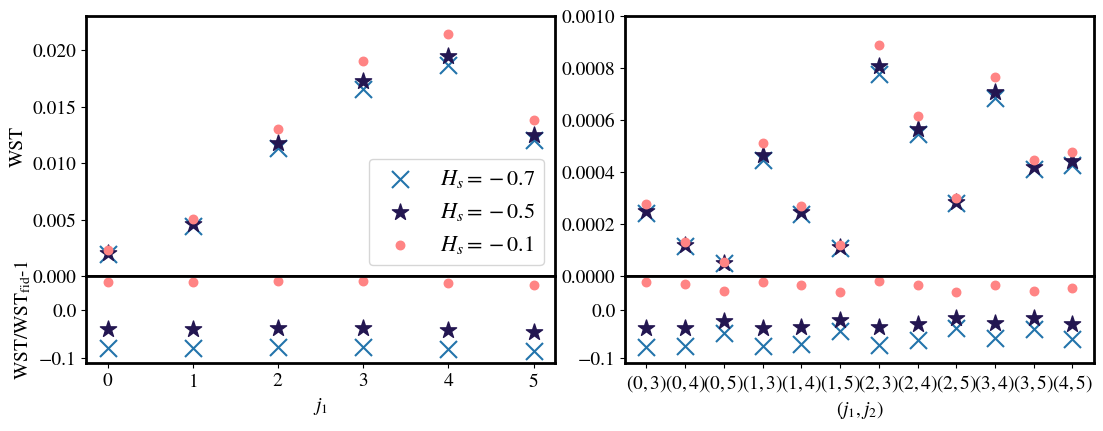

In [122]:
coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$', r'$5$']


fig = plt.figure(figsize=(13,9))
grid = plt.GridSpec(4, 2, hspace=0, wspace=0.15, height_ratios=[3, 1, 3, 1])



coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$',r'$5$']
big_ax = fig.add_subplot(grid[0:1, 0])
big_ax.scatter(coeff , ord_1_hs[0], marker = 'x',color='#2374AB', s= 150, label =r'$H_s = -0.7$')
big_ax.scatter(coeff , ord_1_hs[1], marker='*', s=150, color='#231651', label =r'$H_s = -0.5$')
big_ax.scatter(coeff , ord_1_hs[2], marker = '.',color='#FF8484', s= 150, label =r'$H_s = -0.1$')
big_ax.set_ylim([0,0.023])
big_ax.set_ylabel('WST')
big_ax.legend(loc='lower right', fontsize=16)
big_ax.xaxis.set_tick_params(labelbottom=False)

small_ax = fig.add_subplot(grid[1, 0], sharex=big_ax)

small_ax.scatter(coeff , [ord_1_hs[0][0]/ord_1_fid[0]-1 ,ord_1_hs[0][1]/ord_1_fid[1]-1 , ord_1_hs[0][2]/ord_1_fid[2]-1, ord_1_hs[0][3]/ord_1_fid[3]-1 ,ord_1_hs[0][4]/ord_1_fid[4]-1,ord_1_hs[0][5]/ord_1_fid[5]-1], marker = 'x',color='#2374AB', s= 150, label =r'$A_s = 1.2$')
small_ax.scatter(coeff , [ord_1_hs[1][0]/ord_1_fid[0]-1 ,ord_1_hs[1][1]/ord_1_fid[1]-1 , ord_1_hs[1][2]/ord_1_fid[2]-1, ord_1_hs[1][3]/ord_1_fid[3]-1 ,ord_1_hs[1][4]/ord_1_fid[4]-1,ord_1_hs[1][5]/ord_1_fid[5]-1], marker='*', s=150, color='#231651', label =r'$A_s = 1.55$')
small_ax.scatter(coeff , [ord_1_hs[2][0]/ord_1_fid[0]-1 ,ord_1_hs[2][1]/ord_1_fid[1]-1 , ord_1_hs[2][2]/ord_1_fid[2]-1, ord_1_hs[2][3]/ord_1_fid[3]-1 ,ord_1_hs[2][4]/ord_1_fid[4]-1,ord_1_hs[2][5]/ord_1_fid[5]-1], marker = '.',color='#FF8484', s= 150, label =r'$A_s = 2.25$')
small_ax.set_ylim([-0.11,0.07])
small_ax.set_xlabel(r'$j_1$')
small_ax.set_ylabel(r'WST/WST$_{\mathrm{fid}}$-1')

coeff=[r'$(0,3)$',r'$(0,4)$',r'$(0,5)$',r'$(1,3)$',r'$(1,4)$',r'$(1,5)$',r'$(2,3)$',r'$(2,4)$',r'$(2,5)$',r'$(3,4)$',r'$(3,5)$',r'$(4,5)$']

big_ax = fig.add_subplot(grid[0:1, 1])
big_ax.scatter(coeff , ord_2_hs[0], marker = 'x',color='#2374AB', s= 150, label ='ns = 0.8')
big_ax.scatter(coeff , ord_2_hs[1], marker = '*',color='#231651', s= 150, label ='ns = 0.849')
big_ax.scatter(coeff , ord_2_hs[2], marker='.', s=150, color='#FF8484', label ='ns = 0.897')
big_ax.set_ylim([0,0.001])

big_ax.xaxis.set_tick_params(labelbottom=False)
    
small_ax = fig.add_subplot(grid[1, 1], sharex=big_ax)
small_ax.scatter(coeff , [ord_2_hs[0][0]/ord_2_fid[0]-1 ,ord_2_hs[0][1]/ord_2_fid[1]-1 , ord_2_hs[0][2]/ord_2_fid[2]-1, ord_2_hs[0][3]/ord_2_fid[3]-1 ,ord_2_hs[0][4]/ord_2_fid[4]-1,ord_2_hs[0][5]/ord_2_fid[5]-1,ord_2_hs[0][6]/ord_2_fid[6]-1,ord_2_hs[0][7]/ord_2_fid[7]-1,ord_2_hs[0][8]/ord_2_fid[8]-1,ord_2_hs[0][9]/ord_2_fid[9]-1,ord_2_hs[0][10]/ord_2_fid[10]-1,ord_2_hs[0][11]/ord_2_fid[11]-1], marker = 'x',color='#2374AB', s= 150, label =r'$A_s = 1.2$')
small_ax.scatter(coeff , [ord_2_hs[1][0]/ord_2_fid[0]-1 ,ord_2_hs[1][1]/ord_2_fid[1]-1 , ord_2_hs[1][2]/ord_2_fid[2]-1, ord_2_hs[1][3]/ord_2_fid[3]-1 ,ord_2_hs[1][4]/ord_2_fid[4]-1,ord_2_hs[1][5]/ord_2_fid[5]-1,ord_2_hs[1][6]/ord_2_fid[6]-1,ord_2_hs[1][7]/ord_2_fid[7]-1,ord_2_hs[1][8]/ord_2_fid[8]-1,ord_2_hs[1][9]/ord_2_fid[9]-1,ord_2_hs[1][10]/ord_2_fid[10]-1,ord_2_hs[1][11]/ord_2_fid[11]-1], marker='*', s=150, color='#231651', label =r'$A_s = 1.55$')
small_ax.scatter(coeff , [ord_2_hs[2][0]/ord_2_fid[0]-1 ,ord_2_hs[2][1]/ord_2_fid[1]-1 , ord_2_hs[2][2]/ord_2_fid[2]-1, ord_2_hs[2][3]/ord_2_fid[3]-1 ,ord_2_hs[2][4]/ord_2_fid[4]-1,ord_2_hs[2][5]/ord_2_fid[5]-1,ord_2_hs[2][6]/ord_2_fid[6]-1,ord_2_hs[2][7]/ord_2_fid[7]-1,ord_2_hs[2][8]/ord_2_fid[8]-1,ord_2_hs[2][9]/ord_2_fid[9]-1,ord_2_hs[2][10]/ord_2_fid[10]-1,ord_2_hs[2][11]/ord_2_fid[11]-1], marker = '.',color='#FF8484', s= 150, label =r'$A_s = 2.25$')
small_ax.set_xlabel(r'$(j_1,j_2)$')
small_ax.set_ylim([-0.11,0.07])


plt.tight_layout()
plt.savefig('Hs_1d_.pdf')
#plt.savefig('ns_as_with_zoom_in.pdf')
plt.show()

/Users/Hurum/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


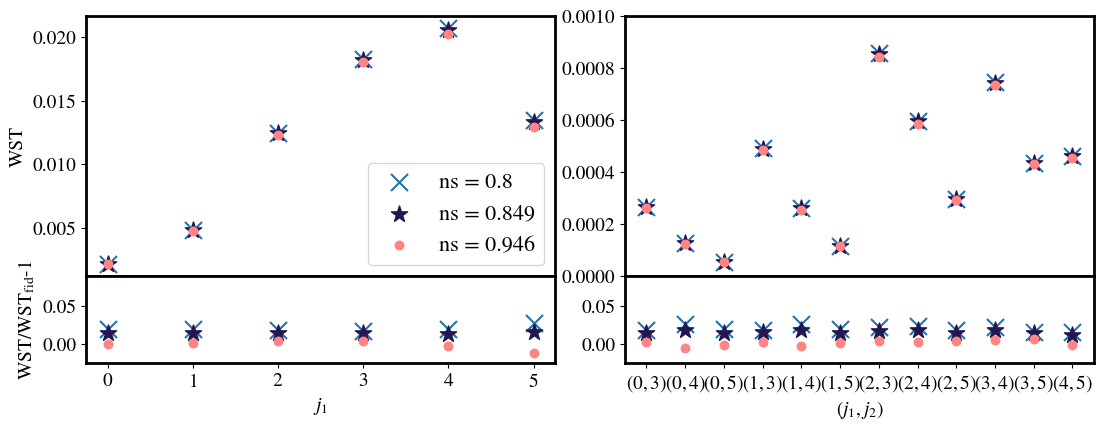

In [86]:
coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$', r'$5$']


fig = plt.figure(figsize=(13,9))
grid = plt.GridSpec(4, 2, hspace=0, wspace=0.15, height_ratios=[3, 1, 3, 1])


big_ax = fig.add_subplot(grid[0:1, 0])
big_ax.scatter(coeff , (ord_1_ns[0]) , marker = 'x',color='#2374AB', s= 150, label ='ns = 0.8')
big_ax.scatter(coeff , (ord_1_ns[1]), marker = '*',color='#231651', s= 150, label ='ns = 0.849')
big_ax.scatter(coeff , (ord_1_ns[2]), marker='.', s=150, color='#FF8484', label ='ns = 0.946')
#big_ax.set_ylim([0,0.023])
big_ax.legend(loc='lower right', fontsize=16)
big_ax.xaxis.set_tick_params(labelbottom=False)
big_ax.set_ylabel('WST')

small_ax = fig.add_subplot(grid[1, 0], sharex=big_ax)
small_ax.scatter(coeff , [ord_1_ns[0][0]/ord_1_fid[0]-1 ,ord_1_ns[0][1]/ord_1_fid[1]-1 , ord_1_ns[0][2]/ord_1_fid[2]-1, ord_1_ns[0][3]/ord_1_fid[3]-1 ,ord_1_ns[0][4]/ord_1_fid[4]-1 ,ord_1_ns[0][5]/ord_1_fid[5]-1], marker = 'x',color='#2374AB', s= 150, label ='ns = 0.8')
small_ax.scatter(coeff , [ord_1_ns[1][0]/ord_1_fid[0]-1 ,ord_1_ns[1][1]/ord_1_fid[1]-1 , ord_1_ns[1][2]/ord_1_fid[2]-1, ord_1_ns[1][3]/ord_1_fid[3]-1 ,ord_1_ns[1][4]/ord_1_fid[4]-1 ,ord_1_ns[1][5]/ord_1_fid[5]-1], marker = '*',color='#231651', s= 150, label ='ns = 0.849')
small_ax.scatter(coeff , [ord_1_ns[2][0]/ord_1_fid[0]-1 ,ord_1_ns[2][1]/ord_1_fid[1]-1 , ord_1_ns[2][2]/ord_1_fid[2]-1, ord_1_ns[2][3]/ord_1_fid[3]-1 ,ord_1_ns[2][4]/ord_1_fid[4]-1 ,ord_1_ns[2][5]/ord_1_fid[5]-1], marker='.', s=150, color='#FF8484', label ='ns = 0.897')

small_ax.set_xlabel(r'$j_1$')
small_ax.set_ylim([-0.025,0.09])
small_ax.set_ylabel(r'WST/WST$_{\mathrm{fid}}$-1')

coeff=[r'$(0,3)$',r'$(0,4)$',r'$(0,5)$',r'$(1,3)$',r'$(1,4)$',r'$(1,5)$',r'$(2,3)$',r'$(2,4)$',r'$(2,5)$',r'$(3,4)$',r'$(3,5)$',r'$(4,5)$']


big_ax = fig.add_subplot(grid[0:1, 1])
big_ax.scatter(coeff , ord_2_ns[0], marker = 'x',color='#2374AB', s= 150, label ='ns = 0.8')
big_ax.scatter(coeff , ord_2_ns[1], marker = '*',color='#231651', s= 150, label ='ns = 0.849')
big_ax.scatter(coeff , ord_2_ns[2], marker='.', s=150, color='#FF8484', label ='ns = 0.946')
big_ax.set_ylim([0,0.001])
big_ax.xaxis.set_tick_params(labelbottom=False)
    
small_ax = fig.add_subplot(grid[1, 1], sharex=big_ax)
small_ax.scatter(coeff , [ord_2_ns[0][0]/ord_2_fid[0]-1 ,ord_2_ns[0][1]/ord_2_fid[1]-1 , ord_2_ns[0][2]/ord_2_fid[2]-1, ord_2_ns[0][3]/ord_2_fid[3]-1 ,ord_2_ns[0][4]/ord_2_fid[4]-1,ord_2_ns[0][5]/ord_2_fid[5]-1,ord_2_ns[0][6]/ord_2_fid[6]-1,ord_2_ns[0][7]/ord_2_fid[7]-1,ord_2_ns[0][8]/ord_2_fid[8]-1,ord_2_ns[0][9]/ord_2_fid[9]-1,ord_2_ns[0][10]/ord_2_fid[10]-1,ord_2_ns[0][11]/ord_2_fid[11]-1], marker = 'x',color='#2374AB', s= 150, label ='ns = 0.8')
small_ax.scatter(coeff , [ord_2_ns[1][0]/ord_2_fid[0]-1 ,ord_2_ns[1][1]/ord_2_fid[1]-1 , ord_2_ns[1][2]/ord_2_fid[2]-1, ord_2_ns[1][3]/ord_2_fid[3]-1 ,ord_2_ns[1][4]/ord_2_fid[4]-1,ord_2_ns[1][5]/ord_2_fid[5]-1,ord_2_ns[1][6]/ord_2_fid[6]-1,ord_2_ns[1][7]/ord_2_fid[7]-1,ord_2_ns[1][8]/ord_2_fid[8]-1,ord_2_ns[1][9]/ord_2_fid[9]-1,ord_2_ns[1][10]/ord_2_fid[10]-1,ord_2_ns[1][11]/ord_2_fid[11]-1], marker = '*',color='#231651', s= 150, label ='ns = 0.849')
small_ax.scatter(coeff , [ord_2_ns[2][0]/ord_2_fid[0]-1 ,ord_2_ns[2][1]/ord_2_fid[1]-1 , ord_2_ns[2][2]/ord_2_fid[2]-1, ord_2_ns[2][3]/ord_2_fid[3]-1 ,ord_2_ns[2][4]/ord_2_fid[4]-1,ord_2_ns[2][5]/ord_2_fid[5]-1,ord_2_ns[2][6]/ord_2_fid[6]-1,ord_2_ns[2][7]/ord_2_fid[7]-1,ord_2_ns[2][8]/ord_2_fid[8]-1,ord_2_ns[2][9]/ord_2_fid[9]-1,ord_2_ns[2][10]/ord_2_fid[10]-1,ord_2_ns[2][11]/ord_2_fid[11]-1], marker='.', s=150, color='#FF8484', label ='ns = 0.897')
small_ax.set_ylim([-0.025,0.09])
small_ax.set_xlabel(r'$(j_1,j_2)$')
plt.tight_layout()
plt.savefig('ns_1d.pdf')

/Users/Hurum/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


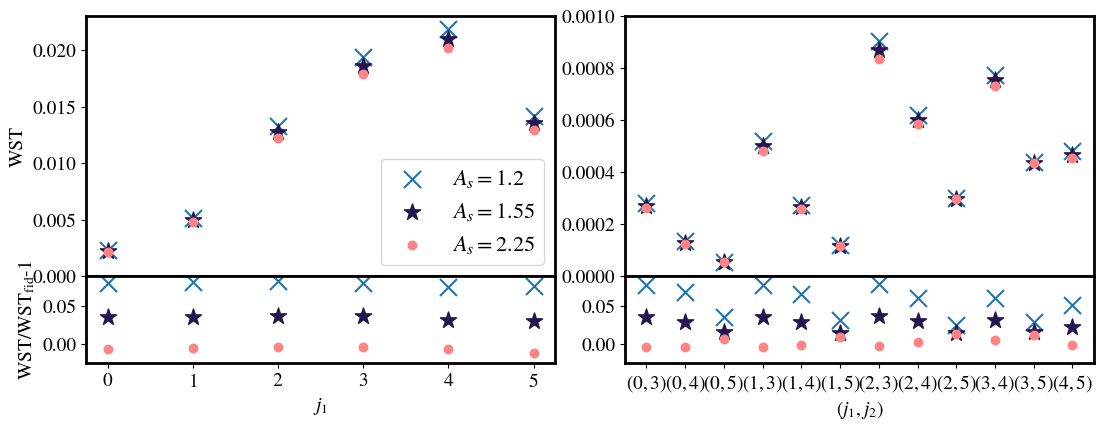

In [73]:
coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$', r'$5$']


fig = plt.figure(figsize=(13,9))
grid = plt.GridSpec(4, 2, hspace=0, wspace=0.15, height_ratios=[3, 1, 3, 1])


coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$',r'$5$']
big_ax = fig.add_subplot(grid[0:1, 0])
big_ax.scatter(coeff , ord_1_as[0], marker = 'x',color='#2374AB', s= 150, label =r'$A_s = 1.2$')
big_ax.scatter(coeff , ord_1_as[1], marker='*', s=150, color='#231651', label =r'$A_s = 1.55$')
big_ax.scatter(coeff , ord_1_as[2], marker = '.',color='#FF8484', s= 150, label =r'$A_s = 2.25$')
big_ax.set_ylim([0,0.023])
big_ax.legend(loc='lower right', fontsize=16)
big_ax.set_ylabel('WST')
big_ax.xaxis.set_tick_params(labelbottom=False)

small_ax = fig.add_subplot(grid[1, 0], sharex=big_ax)

small_ax.scatter(coeff , [ord_1_as[0][0]/ord_1_fid[0]-1 ,ord_1_as[0][1]/ord_1_fid[1]-1 , ord_1_as[0][2]/ord_1_fid[2]-1, ord_1_as[0][3]/ord_1_fid[3]-1 ,ord_1_as[0][4]/ord_1_fid[4]-1,ord_1_as[0][5]/ord_1_fid[5]-1], marker = 'x',color='#2374AB', s= 150, label =r'$A_s = 1.2$')
small_ax.scatter(coeff , [ord_1_as[1][0]/ord_1_fid[0]-1 ,ord_1_as[1][1]/ord_1_fid[1]-1 , ord_1_as[1][2]/ord_1_fid[2]-1, ord_1_as[1][3]/ord_1_fid[3]-1 ,ord_1_as[1][4]/ord_1_fid[4]-1,ord_1_as[1][5]/ord_1_fid[5]-1], marker='*', s=150, color='#231651', label =r'$A_s = 1.55$')
small_ax.scatter(coeff , [ord_1_as[2][0]/ord_1_fid[0]-1 ,ord_1_as[2][1]/ord_1_fid[1]-1 , ord_1_as[2][2]/ord_1_fid[2]-1, ord_1_as[2][3]/ord_1_fid[3]-1 ,ord_1_as[2][4]/ord_1_fid[4]-1,ord_1_as[2][5]/ord_1_fid[5]-1], marker = '.',color='#FF8484', s= 150, label =r'$A_s = 2.25$')
small_ax.set_ylim([-0.025,0.09])
small_ax.set_xlabel(r'$j_1$')
small_ax.set_ylabel(r'WST/WST$_{\mathrm{fid}}$-1')


coeff=[r'$(0,3)$',r'$(0,4)$',r'$(0,5)$',r'$(1,3)$',r'$(1,4)$',r'$(1,5)$',r'$(2,3)$',r'$(2,4)$',r'$(2,5)$',r'$(3,4)$',r'$(3,5)$',r'$(4,5)$']

big_ax = fig.add_subplot(grid[0:1, 1])
big_ax.scatter(coeff , ord_2_as[0], marker = 'x',color='#2374AB', s= 150, label ='ns = 0.8')
big_ax.scatter(coeff , ord_2_as[1], marker = '*',color='#231651', s= 150, label ='ns = 0.849')
big_ax.scatter(coeff , ord_2_as[2], marker='.', s=150, color='#FF8484', label ='ns = 0.897')
big_ax.set_ylim([0,0.001])

big_ax.xaxis.set_tick_params(labelbottom=False)
    
small_ax = fig.add_subplot(grid[1, 1], sharex=big_ax)
small_ax.scatter(coeff , [ord_2_as[0][0]/ord_2_fid[0]-1 ,ord_2_as[0][1]/ord_2_fid[1]-1 , ord_2_as[0][2]/ord_2_fid[2]-1, ord_2_as[0][3]/ord_2_fid[3]-1 ,ord_2_as[0][4]/ord_2_fid[4]-1,ord_2_as[0][5]/ord_2_fid[5]-1,ord_2_as[0][6]/ord_2_fid[6]-1,ord_2_as[0][7]/ord_2_fid[7]-1,ord_2_as[0][8]/ord_2_fid[8]-1,ord_2_as[0][9]/ord_2_fid[9]-1,ord_2_as[0][10]/ord_2_fid[10]-1,ord_2_as[0][11]/ord_2_fid[11]-1], marker = 'x',color='#2374AB', s= 150, label =r'$A_s = 1.2$')
small_ax.scatter(coeff , [ord_2_as[1][0]/ord_2_fid[0]-1 ,ord_2_as[1][1]/ord_2_fid[1]-1 , ord_2_as[1][2]/ord_2_fid[2]-1, ord_2_as[1][3]/ord_2_fid[3]-1 ,ord_2_as[1][4]/ord_2_fid[4]-1,ord_2_as[1][5]/ord_2_fid[5]-1,ord_2_as[1][6]/ord_2_fid[6]-1,ord_2_as[1][7]/ord_2_fid[7]-1,ord_2_as[1][8]/ord_2_fid[8]-1,ord_2_as[1][9]/ord_2_fid[9]-1,ord_2_as[1][10]/ord_2_fid[10]-1,ord_2_as[1][11]/ord_2_fid[11]-1], marker='*', s=150, color='#231651', label =r'$A_s = 1.55$')
small_ax.scatter(coeff , [ord_2_as[2][0]/ord_2_fid[0]-1 ,ord_2_as[2][1]/ord_2_fid[1]-1 , ord_2_as[2][2]/ord_2_fid[2]-1, ord_2_as[2][3]/ord_2_fid[3]-1 ,ord_2_as[2][4]/ord_2_fid[4]-1,ord_2_as[2][5]/ord_2_fid[5]-1,ord_2_as[2][6]/ord_2_fid[6]-1,ord_2_as[2][7]/ord_2_fid[7]-1,ord_2_as[2][8]/ord_2_fid[8]-1,ord_2_as[2][9]/ord_2_fid[9]-1,ord_2_as[2][10]/ord_2_fid[10]-1,ord_2_as[2][11]/ord_2_fid[11]-1], marker = '.',color='#FF8484', s= 150, label =r'$A_s = 2.25$')
small_ax.set_xlabel(r'$(j_1,j_2)$')
small_ax.set_ylim([-0.025,0.09])


plt.tight_layout()
plt.savefig('As_1d.pdf')
#plt.savefig('ns_as_with_zoom_in.pdf')
plt.show()

/Users/Hurum/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


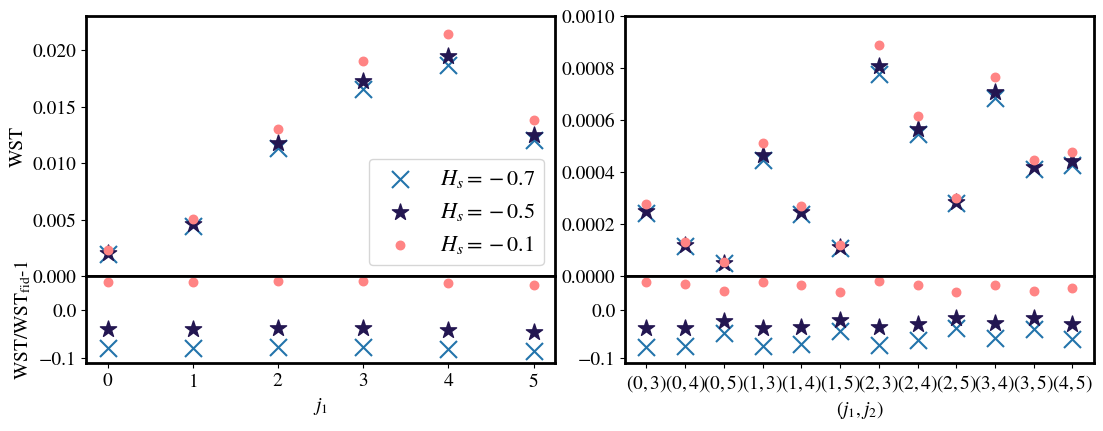

In [72]:
coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$', r'$5$']


fig = plt.figure(figsize=(13,9))
grid = plt.GridSpec(4, 2, hspace=0, wspace=0.15, height_ratios=[3, 1, 3, 1])



coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$',r'$5$']
big_ax = fig.add_subplot(grid[0:1, 0])
big_ax.scatter(coeff , ord_1_hs[0], marker = 'x',color='#2374AB', s= 150, label =r'$H_s = -0.7$')
big_ax.scatter(coeff , ord_1_hs[1], marker='*', s=150, color='#231651', label =r'$H_s = -0.5$')
big_ax.scatter(coeff , ord_1_hs[2], marker = '.',color='#FF8484', s= 150, label =r'$H_s = -0.1$')
big_ax.set_ylim([0,0.023])
big_ax.set_ylabel('WST')
big_ax.legend(loc='lower right', fontsize=16)
big_ax.xaxis.set_tick_params(labelbottom=False)

small_ax = fig.add_subplot(grid[1, 0], sharex=big_ax)

small_ax.scatter(coeff , [ord_1_hs[0][0]/ord_1_fid[0]-1 ,ord_1_hs[0][1]/ord_1_fid[1]-1 , ord_1_hs[0][2]/ord_1_fid[2]-1, ord_1_hs[0][3]/ord_1_fid[3]-1 ,ord_1_hs[0][4]/ord_1_fid[4]-1,ord_1_hs[0][5]/ord_1_fid[5]-1], marker = 'x',color='#2374AB', s= 150, label =r'$A_s = 1.2$')
small_ax.scatter(coeff , [ord_1_hs[1][0]/ord_1_fid[0]-1 ,ord_1_hs[1][1]/ord_1_fid[1]-1 , ord_1_hs[1][2]/ord_1_fid[2]-1, ord_1_hs[1][3]/ord_1_fid[3]-1 ,ord_1_hs[1][4]/ord_1_fid[4]-1,ord_1_hs[1][5]/ord_1_fid[5]-1], marker='*', s=150, color='#231651', label =r'$A_s = 1.55$')
small_ax.scatter(coeff , [ord_1_hs[2][0]/ord_1_fid[0]-1 ,ord_1_hs[2][1]/ord_1_fid[1]-1 , ord_1_hs[2][2]/ord_1_fid[2]-1, ord_1_hs[2][3]/ord_1_fid[3]-1 ,ord_1_hs[2][4]/ord_1_fid[4]-1,ord_1_hs[2][5]/ord_1_fid[5]-1], marker = '.',color='#FF8484', s= 150, label =r'$A_s = 2.25$')
small_ax.set_ylim([-0.11,0.07])
small_ax.set_xlabel(r'$j_1$')
small_ax.set_ylabel(r'WST/WST$_{\mathrm{fid}}$-1')

coeff=[r'$(0,3)$',r'$(0,4)$',r'$(0,5)$',r'$(1,3)$',r'$(1,4)$',r'$(1,5)$',r'$(2,3)$',r'$(2,4)$',r'$(2,5)$',r'$(3,4)$',r'$(3,5)$',r'$(4,5)$']

big_ax = fig.add_subplot(grid[0:1, 1])
big_ax.scatter(coeff , ord_2_hs[0], marker = 'x',color='#2374AB', s= 150, label ='ns = 0.8')
big_ax.scatter(coeff , ord_2_hs[1], marker = '*',color='#231651', s= 150, label ='ns = 0.849')
big_ax.scatter(coeff , ord_2_hs[2], marker='.', s=150, color='#FF8484', label ='ns = 0.897')
big_ax.set_ylim([0,0.001])

big_ax.xaxis.set_tick_params(labelbottom=False)
    
small_ax = fig.add_subplot(grid[1, 1], sharex=big_ax)
small_ax.scatter(coeff , [ord_2_hs[0][0]/ord_2_fid[0]-1 ,ord_2_hs[0][1]/ord_2_fid[1]-1 , ord_2_hs[0][2]/ord_2_fid[2]-1, ord_2_hs[0][3]/ord_2_fid[3]-1 ,ord_2_hs[0][4]/ord_2_fid[4]-1,ord_2_hs[0][5]/ord_2_fid[5]-1,ord_2_hs[0][6]/ord_2_fid[6]-1,ord_2_hs[0][7]/ord_2_fid[7]-1,ord_2_hs[0][8]/ord_2_fid[8]-1,ord_2_hs[0][9]/ord_2_fid[9]-1,ord_2_hs[0][10]/ord_2_fid[10]-1,ord_2_hs[0][11]/ord_2_fid[11]-1], marker = 'x',color='#2374AB', s= 150, label =r'$A_s = 1.2$')
small_ax.scatter(coeff , [ord_2_hs[1][0]/ord_2_fid[0]-1 ,ord_2_hs[1][1]/ord_2_fid[1]-1 , ord_2_hs[1][2]/ord_2_fid[2]-1, ord_2_hs[1][3]/ord_2_fid[3]-1 ,ord_2_hs[1][4]/ord_2_fid[4]-1,ord_2_hs[1][5]/ord_2_fid[5]-1,ord_2_hs[1][6]/ord_2_fid[6]-1,ord_2_hs[1][7]/ord_2_fid[7]-1,ord_2_hs[1][8]/ord_2_fid[8]-1,ord_2_hs[1][9]/ord_2_fid[9]-1,ord_2_hs[1][10]/ord_2_fid[10]-1,ord_2_hs[1][11]/ord_2_fid[11]-1], marker='*', s=150, color='#231651', label =r'$A_s = 1.55$')
small_ax.scatter(coeff , [ord_2_hs[2][0]/ord_2_fid[0]-1 ,ord_2_hs[2][1]/ord_2_fid[1]-1 , ord_2_hs[2][2]/ord_2_fid[2]-1, ord_2_hs[2][3]/ord_2_fid[3]-1 ,ord_2_hs[2][4]/ord_2_fid[4]-1,ord_2_hs[2][5]/ord_2_fid[5]-1,ord_2_hs[2][6]/ord_2_fid[6]-1,ord_2_hs[2][7]/ord_2_fid[7]-1,ord_2_hs[2][8]/ord_2_fid[8]-1,ord_2_hs[2][9]/ord_2_fid[9]-1,ord_2_hs[2][10]/ord_2_fid[10]-1,ord_2_hs[2][11]/ord_2_fid[11]-1], marker = '.',color='#FF8484', s= 150, label =r'$A_s = 2.25$')
small_ax.set_xlabel(r'$(j_1,j_2)$')
small_ax.set_ylim([-0.11,0.07])


plt.tight_layout()
plt.savefig('Hs_1d.pdf')
#plt.savefig('ns_as_with_zoom_in.pdf')
plt.show()

/Users/Hurum/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


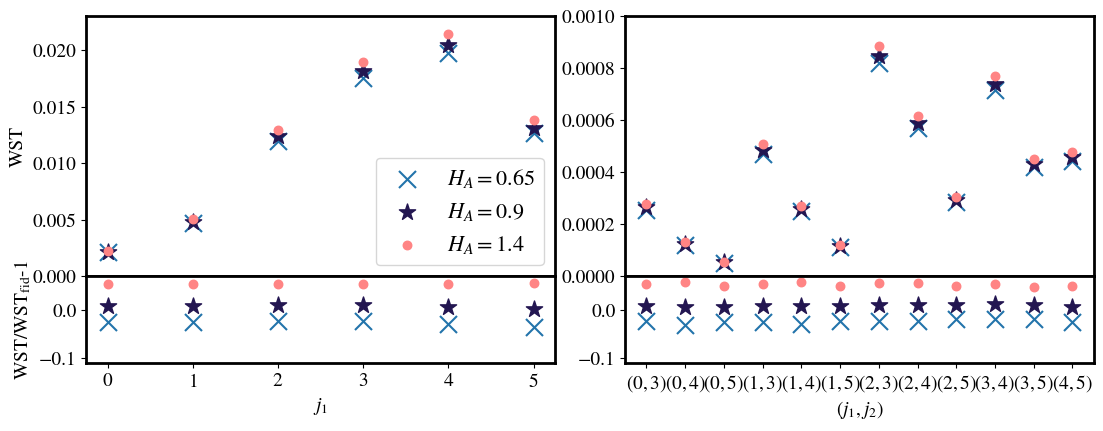

In [71]:
coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$', r'$5$']


fig = plt.figure(figsize=(13,9))
grid = plt.GridSpec(4, 2, hspace=0, wspace=0.15, height_ratios=[3, 1, 3, 1])



coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$',r'$5$']
big_ax = fig.add_subplot(grid[0:1, 0])
big_ax.scatter(coeff , ord_1_ha[0], marker = 'x',color='#2374AB', s= 150, label =r'$H_A = 0.65$')
big_ax.scatter(coeff , ord_1_ha[1], marker='*', s=150, color='#231651', label =r'$H_A = 0.9$')
big_ax.scatter(coeff , ord_1_ha[2], marker = '.',color='#FF8484', s= 150, label =r'$H_A = 1.4$')
big_ax.set_ylim([0,0.023])
big_ax.set_ylabel('WST')
big_ax.legend(loc='lower right', fontsize=16)
big_ax.xaxis.set_tick_params(labelbottom=False)

small_ax = fig.add_subplot(grid[1, 0], sharex=big_ax)

small_ax.scatter(coeff , [ord_1_ha[0][0]/ord_1_fid[0]-1 ,ord_1_ha[0][1]/ord_1_fid[1]-1 , ord_1_ha[0][2]/ord_1_fid[2]-1, ord_1_ha[0][3]/ord_1_fid[3]-1 ,ord_1_ha[0][4]/ord_1_fid[4]-1,ord_1_ha[0][5]/ord_1_fid[5]-1], marker = 'x',color='#2374AB', s= 150, label =r'$A_s = 1.2$')
small_ax.scatter(coeff , [ord_1_ha[1][0]/ord_1_fid[0]-1 ,ord_1_ha[1][1]/ord_1_fid[1]-1 , ord_1_ha[1][2]/ord_1_fid[2]-1, ord_1_ha[1][3]/ord_1_fid[3]-1 ,ord_1_ha[1][4]/ord_1_fid[4]-1,ord_1_ha[1][5]/ord_1_fid[5]-1], marker='*', s=150, color='#231651', label =r'$A_s = 1.55$')
small_ax.scatter(coeff , [ord_1_ha[2][0]/ord_1_fid[0]-1 ,ord_1_ha[2][1]/ord_1_fid[1]-1 , ord_1_ha[2][2]/ord_1_fid[2]-1, ord_1_ha[2][3]/ord_1_fid[3]-1 ,ord_1_ha[2][4]/ord_1_fid[4]-1,ord_1_ha[2][5]/ord_1_fid[5]-1], marker = '.',color='#FF8484', s= 150, label =r'$A_s = 2.25$')
small_ax.set_ylim([-0.11,0.07])
small_ax.set_xlabel(r'$j_1$')
small_ax.set_ylabel(r'WST/WST$_{\mathrm{fid}}$-1')


coeff=[r'$(0,3)$',r'$(0,4)$',r'$(0,5)$',r'$(1,3)$',r'$(1,4)$',r'$(1,5)$',r'$(2,3)$',r'$(2,4)$',r'$(2,5)$',r'$(3,4)$',r'$(3,5)$',r'$(4,5)$']

big_ax = fig.add_subplot(grid[0:1, 1])
big_ax.scatter(coeff , ord_2_ha[0], marker = 'x',color='#2374AB', s= 150, label ='ns = 0.8')
big_ax.scatter(coeff , ord_2_ha[1], marker = '*',color='#231651', s= 150, label ='ns = 0.849')
big_ax.scatter(coeff , ord_2_ha[2], marker='.', s=150, color='#FF8484', label ='ns = 0.897')
big_ax.set_ylim([0,0.001])

big_ax.xaxis.set_tick_params(labelbottom=False)
    
small_ax = fig.add_subplot(grid[1, 1], sharex=big_ax)
small_ax.scatter(coeff , [ord_2_ha[0][0]/ord_2_fid[0]-1 ,ord_2_ha[0][1]/ord_2_fid[1]-1 , ord_2_ha[0][2]/ord_2_fid[2]-1, ord_2_ha[0][3]/ord_2_fid[3]-1 ,ord_2_ha[0][4]/ord_2_fid[4]-1,ord_2_ha[0][5]/ord_2_fid[5]-1,ord_2_ha[0][6]/ord_2_fid[6]-1,ord_2_ha[0][7]/ord_2_fid[7]-1,ord_2_ha[0][8]/ord_2_fid[8]-1,ord_2_ha[0][9]/ord_2_fid[9]-1,ord_2_ha[0][10]/ord_2_fid[10]-1,ord_2_ha[0][11]/ord_2_fid[11]-1], marker = 'x',color='#2374AB', s= 150, label =r'$A_s = 1.2$')
small_ax.scatter(coeff , [ord_2_ha[1][0]/ord_2_fid[0]-1 ,ord_2_ha[1][1]/ord_2_fid[1]-1 , ord_2_ha[1][2]/ord_2_fid[2]-1, ord_2_ha[1][3]/ord_2_fid[3]-1 ,ord_2_ha[1][4]/ord_2_fid[4]-1,ord_2_ha[1][5]/ord_2_fid[5]-1,ord_2_ha[1][6]/ord_2_fid[6]-1,ord_2_ha[1][7]/ord_2_fid[7]-1,ord_2_ha[1][8]/ord_2_fid[8]-1,ord_2_ha[1][9]/ord_2_fid[9]-1,ord_2_ha[1][10]/ord_2_fid[10]-1,ord_2_ha[1][11]/ord_2_fid[11]-1], marker='*', s=150, color='#231651', label =r'$A_s = 1.55$')
small_ax.scatter(coeff , [ord_2_ha[2][0]/ord_2_fid[0]-1 ,ord_2_ha[2][1]/ord_2_fid[1]-1 , ord_2_ha[2][2]/ord_2_fid[2]-1, ord_2_ha[2][3]/ord_2_fid[3]-1 ,ord_2_ha[2][4]/ord_2_fid[4]-1,ord_2_ha[2][5]/ord_2_fid[5]-1,ord_2_ha[2][6]/ord_2_fid[6]-1,ord_2_ha[2][7]/ord_2_fid[7]-1,ord_2_ha[2][8]/ord_2_fid[8]-1,ord_2_ha[2][9]/ord_2_fid[9]-1,ord_2_ha[2][10]/ord_2_fid[10]-1,ord_2_ha[2][11]/ord_2_fid[11]-1], marker = '.',color='#FF8484', s= 150, label =r'$A_s = 2.25$')
small_ax.set_xlabel(r'$(j_1,j_2)$')
small_ax.set_ylim([-0.11,0.07])


plt.tight_layout()
plt.savefig('Ha_1d.pdf')
#plt.savefig('ns_as_with_zoom_in.pdf')
plt.show()

/Users/Hurum/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


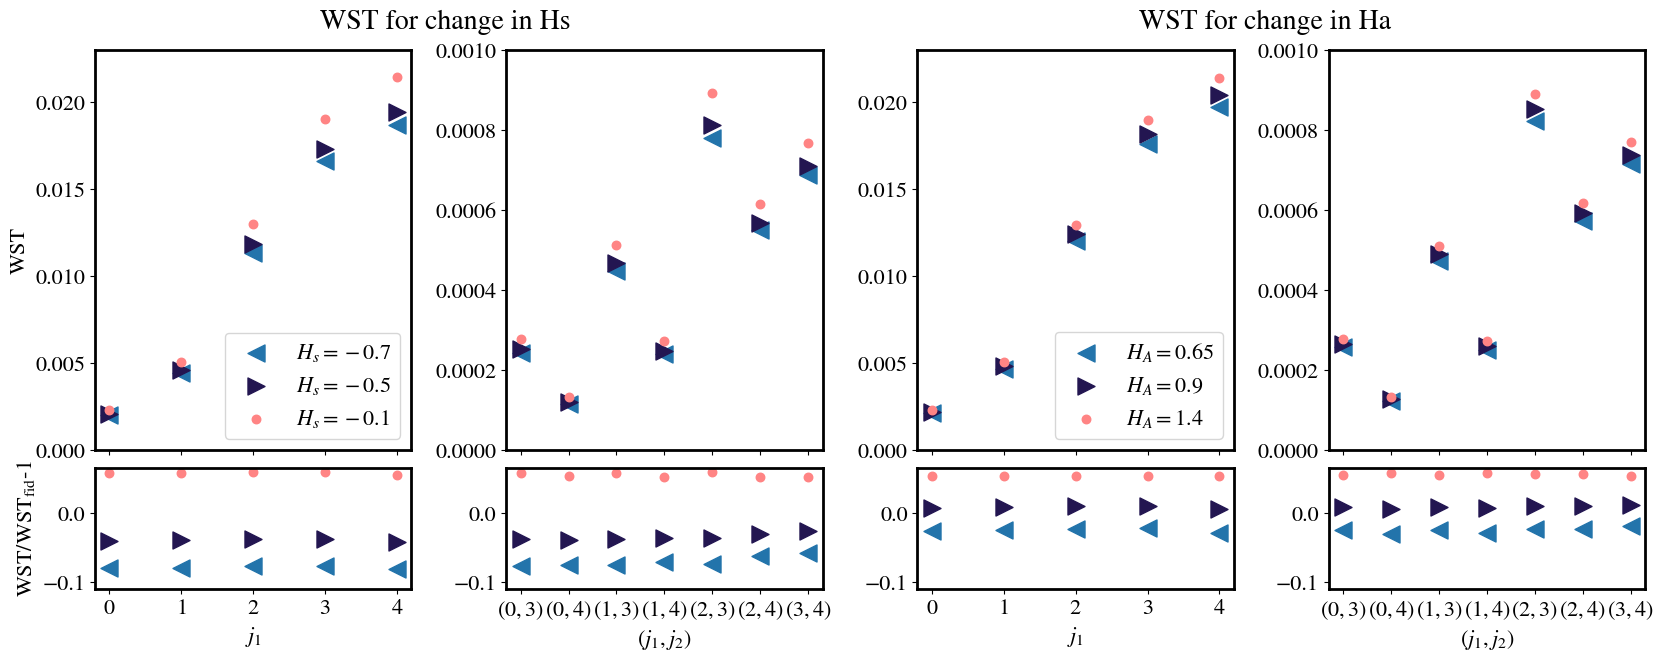

In [26]:
coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$']


fig = plt.figure(figsize=(20, 7))
grid = plt.GridSpec(4, 4, hspace=0.15, wspace=0.3)


big_ax = fig.add_subplot(grid[0:3, 0])
big_ax.scatter(coeff , ord_1_hs[0], marker='x', s=150, color='#2374AB', label =r'$H_s = -0.7$')
big_ax.scatter(coeff , ord_1_hs[1], marker = '*',color='#231651', s= 150, label =r'$H_s = -0.5$')
big_ax.scatter(coeff , ord_1_hs[2], marker = '.',color='#FF8484', s= 150, label =r'$H_s = -0.1$')
big_ax.set_ylim([0,0.023])
big_ax.legend(loc='lower right', fontsize=16)
big_ax.set_ylabel('WST')
big_ax.xaxis.set_tick_params(labelbottom=False)

small_ax = fig.add_subplot(grid[3, 0], sharex=big_ax)
small_ax.scatter(coeff , [ord_1_hs[0][0]/ord_1_fid[0]-1 ,ord_1_hs[0][1]/ord_1_fid[1]-1 , ord_1_hs[0][2]/ord_1_fid[2]-1, ord_1_hs[0][3]/ord_1_fid[3]-1 ,ord_1_hs[0][4]/ord_1_fid[4]-1], marker = 'x',color='#2374AB', s= 150, label ='ns = 0.8')
small_ax.scatter(coeff , [ord_1_hs[1][0]/ord_1_fid[0]-1 ,ord_1_hs[1][1]/ord_1_fid[1]-1 , ord_1_hs[1][2]/ord_1_fid[2]-1, ord_1_hs[1][3]/ord_1_fid[3]-1 ,ord_1_hs[1][4]/ord_1_fid[4]-1], marker = '*',color='#231651', s= 150, label ='ns = 0.849')
small_ax.scatter(coeff , [ord_1_hs[2][0]/ord_1_fid[0]-1 ,ord_1_hs[2][1]/ord_1_fid[1]-1 , ord_1_hs[2][2]/ord_1_fid[2]-1, ord_1_hs[2][3]/ord_1_fid[3]-1 ,ord_1_hs[2][4]/ord_1_fid[4]-1], marker='.', s=150, color='#FF8484', label ='ns = 0.897')

small_ax.set_xlabel(r'$j_1$')
small_ax.set_ylabel(r'WST/WST$_{\mathrm{fid}}$-1')
small_ax.set_ylim([-0.11,0.065])


coeff=[r'$(0,3)$',r'$(0,4)$',r'$(1,3)$',r'$(1,4)$',r'$(2,3)$',r'$(2,4)$',r'$(3,4)$']

big_ax = fig.add_subplot(grid[0:3, 1])
big_ax.scatter(coeff , ord_2_hs[0], marker = 'x',color='#2374AB', s= 150, label ='ns = 0.8')
big_ax.scatter(coeff , ord_2_hs[1], marker = '*',color='#231651', s= 150, label ='ns = 0.849')
big_ax.scatter(coeff , ord_2_hs[2], marker='.', s=150, color='#FF8484', label ='ns = 0.897')
big_ax.set_ylim([0,0.001])
big_ax.xaxis.set_tick_params(labelbottom=False)
    
small_ax = fig.add_subplot(grid[3, 1], sharex=big_ax)
small_ax.scatter(coeff , [ord_2_hs[0][0]/ord_2_fid[0]-1 ,ord_2_hs[0][1]/ord_2_fid[1]-1 , ord_2_hs[0][2]/ord_2_fid[2]-1, ord_2_hs[0][3]/ord_2_fid[3]-1 ,ord_2_hs[0][4]/ord_2_fid[4]-1,ord_2_hs[0][5]/ord_2_fid[5]-1,ord_2_hs[0][6]/ord_2_fid[6]-1], marker = 'x',color='#2374AB', s= 150, label ='ns = 0.8')
small_ax.scatter(coeff , [ord_2_hs[1][0]/ord_2_fid[0]-1 ,ord_2_hs[1][1]/ord_2_fid[1]-1 , ord_2_hs[1][2]/ord_2_fid[2]-1, ord_2_hs[1][3]/ord_2_fid[3]-1 ,ord_2_hs[1][4]/ord_2_fid[4]-1,ord_2_hs[1][5]/ord_2_fid[5]-1,ord_2_hs[1][6]/ord_2_fid[6]-1], marker = '*',color='#231651', s= 150, label ='ns = 0.849')
small_ax.scatter(coeff , [ord_2_hs[2][0]/ord_2_fid[0]-1 ,ord_2_hs[2][1]/ord_2_fid[1]-1 , ord_2_hs[2][2]/ord_2_fid[2]-1, ord_2_hs[2][3]/ord_2_fid[3]-1 ,ord_2_hs[2][4]/ord_2_fid[4]-1,ord_2_hs[2][5]/ord_2_fid[5]-1,ord_2_hs[2][6]/ord_2_fid[6]-1], marker='.', s=150, color='#FF8484', label ='ns = 0.897')
small_ax.set_ylim([-0.11,0.065])

small_ax.set_xlabel(r'$(j_1,j_2)$')


coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$']
big_ax = fig.add_subplot(grid[0:3, 2])
big_ax.scatter(coeff , ord_1_ha[0], marker = 'x',color='#2374AB', s= 150, label =r'$H_A = 0.65$')
big_ax.scatter(coeff , ord_1_ha[1], marker = '*',color='#231651', s= 150, label =r'$H_A = 0.9$')
big_ax.scatter(coeff , ord_1_ha[2], marker='.', s=150, color='#FF8484', label =r'$H_A = 1.4$')
big_ax.set_ylim([0,0.023])
big_ax.legend(loc='lower right', fontsize=16)
big_ax.xaxis.set_tick_params(labelbottom=False)

small_ax = fig.add_subplot(grid[3, 2], sharex=big_ax)

small_ax.scatter(coeff , [ord_1_ha[0][0]/ord_1_fid[0]-1 ,ord_1_ha[0][1]/ord_1_fid[1]-1 , ord_1_ha[0][2]/ord_1_fid[2]-1, ord_1_ha[0][3]/ord_1_fid[3]-1 ,ord_1_ha[0][4]/ord_1_fid[4]-1], marker = 'x',color='#2374AB', s= 150, label =r'$A_s = 1.2$')
small_ax.scatter(coeff , [ord_1_ha[1][0]/ord_1_fid[0]-1 ,ord_1_ha[1][1]/ord_1_fid[1]-1 , ord_1_ha[1][2]/ord_1_fid[2]-1, ord_1_ha[1][3]/ord_1_fid[3]-1 ,ord_1_ha[1][4]/ord_1_fid[4]-1], marker='*', s=150, color='#231651', label =r'$A_s = 1.55$')
small_ax.scatter(coeff , [ord_1_ha[2][0]/ord_1_fid[0]-1 ,ord_1_ha[2][1]/ord_1_fid[1]-1 , ord_1_ha[2][2]/ord_1_fid[2]-1, ord_1_ha[2][3]/ord_1_fid[3]-1 ,ord_1_ha[2][4]/ord_1_fid[4]-1], marker = '.',color='#FF8484', s= 150, label =r'$A_s = 2.25$')
small_ax.set_ylim([-0.11,0.065])
small_ax.set_xlabel(r'$j_1$')

coeff=[r'$(0,3)$',r'$(0,4)$',r'$(1,3)$',r'$(1,4)$',r'$(2,3)$',r'$(2,4)$',r'$(3,4)$']

big_ax = fig.add_subplot(grid[0:3, 3])
big_ax.scatter(coeff , ord_2_ha[0], marker = 'x',color='#2374AB', s= 150, label ='ns = 0.8')
big_ax.scatter(coeff , ord_2_ha[1], marker = '*',color='#231651', s= 150, label ='ns = 0.849')
big_ax.scatter(coeff , ord_2_ha[2], marker='.', s=150, color='#FF8484', label ='ns = 0.897')
big_ax.set_ylim([0,0.001])

big_ax.xaxis.set_tick_params(labelbottom=False)
    
small_ax = fig.add_subplot(grid[3, 3], sharex=big_ax)
small_ax.scatter(coeff , [ord_2_ha[0][0]/ord_2_fid[0]-1 ,ord_2_ha[0][1]/ord_2_fid[1]-1 , ord_2_ha[0][2]/ord_2_fid[2]-1, ord_2_ha[0][3]/ord_2_fid[3]-1 ,ord_2_ha[0][4]/ord_2_fid[4]-1,ord_2_ha[0][5]/ord_2_fid[5]-1,ord_2_ha[0][6]/ord_2_fid[6]-1], marker = 'x',color='#2374AB', s= 150, label =r'$A_s = 1.2$')
small_ax.scatter(coeff , [ord_2_ha[1][0]/ord_2_fid[0]-1 ,ord_2_ha[1][1]/ord_2_fid[1]-1 , ord_2_ha[1][2]/ord_2_fid[2]-1, ord_2_ha[1][3]/ord_2_fid[3]-1 ,ord_2_ha[1][4]/ord_2_fid[4]-1,ord_2_ha[1][5]/ord_2_fid[5]-1,ord_2_ha[1][6]/ord_2_fid[6]-1], marker='*', s=150, color='#231651', label =r'$A_s = 1.55$')
small_ax.scatter(coeff , [ord_2_ha[2][0]/ord_2_fid[0]-1 ,ord_2_ha[2][1]/ord_2_fid[1]-1 , ord_2_ha[2][2]/ord_2_fid[2]-1, ord_2_ha[2][3]/ord_2_fid[3]-1 ,ord_2_ha[2][4]/ord_2_fid[4]-1,ord_2_ha[2][5]/ord_2_fid[5]-1,ord_2_ha[2][6]/ord_2_fid[6]-1], marker = '.',color='#FF8484', s= 150, label =r'$A_s = 2.25$')
small_ax.set_xlabel(r'$(j_1,j_2)$')
small_ax.set_ylim([-0.11,0.065])



    
fig.text(0.3, 0.92, "WST for change in Hs", ha='center', va='center', fontsize=20)
fig.text(0.71, 0.92, "WST for change in Ha", ha='center', va='center', fontsize=20)

plt.tight_layout()
plt.savefig('hs_ha_with_zoom_in.pdf')
plt.show()


In [46]:
lya_file = h5py.File('/Users/Hurum/Documents/z=2/ns0.897As1.9e-09heat_slope-0.3heat_amp0.9hub0.7/lya_forest_spectra.hdf5', 'r')
all_tau = lya_file['tau']['H']['1']['1215'][:]
rescale_factor = get_mean_flux_scale(all_tau, obs_mean_tau( scale_factor_to_redshift(.29)),all_tau.shape[1], 10**(-10))


mean_flux_list = [rescale_factor -rescale_factor*.1, rescale_factor , rescale_factor + rescale_factor*.1  ]

scat_21=[]
for i in range(0,3):
    
    rescaled_tau = mean_flux_list[i]*all_tau
    all_flux = np.exp(-rescaled_tau)
    boxsize = lya_file['Header'].attrs['box']/1000
    z= 2.4
    res_in_cmp = (100 /cosmo.H(z).value)*(1+z) * cosmo.h
    num_pix = res_in_cmp / (boxsize/all_flux.shape[1])
    coarse_flux = scipy.ndimage.gaussian_filter1d(all_flux , sigma=num_pix, axis=1, mode='wrap')
    all_flux= coarse_flux
    all_flux= coarse_flux/np.mean(all_flux)

    
    scat=[]
    for i in range(0,32000):
        Sx = scattering(all_flux[i])
        Sx = Sx.mean(axis=1)
        scat.append(Sx)

    print(np.shape(scat))
    scat_21.append(scat)

scat_21 = np.array(scat_21)
scat_21 = scat_21.mean(axis=1)    
    
print(np.shape(scat_21))
first_ord= [scat_21[0][1:7],scat_21[1][1:7],scat_21[2][1:7]]
print(np.shape(first_ord))

sec_ord= [scat_21[0][7:19],scat_21[1][7:19],scat_21[2][7:19]]
print(np.shape(sec_ord))



(32000, 19)
(32000, 19)
(32000, 19)
(3, 19)
(3, 6)
(3, 12)


/Users/Hurum/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


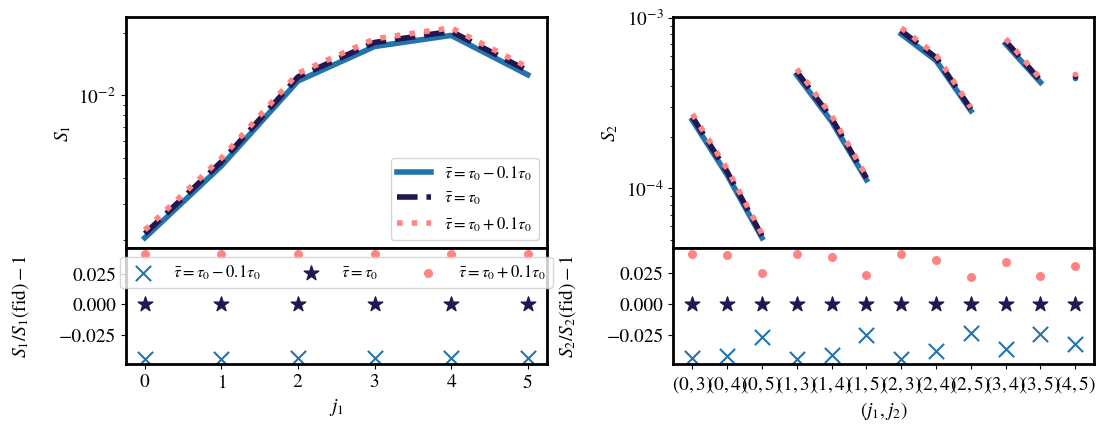

In [47]:
coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$', r'$5$']


fig = plt.figure(figsize=(12.5,9))
grid = plt.GridSpec(4, 2, hspace=0, wspace=0.3, height_ratios=[2, 1, 2, 1])
ord_1= np.array(first_ord)

big_ax = fig.add_subplot(grid[0:1, 0])
big_ax.plot(coeff , ord_1[0] , color='#2374AB', label=r'$\bar{\tau} = \tau_0- 0.1 \tau_0$', linewidth =4)
big_ax.plot(coeff , ord_1[1], color='#231651', linestyle='dashed', label=r'$\bar{\tau} = \tau_0$', linewidth =4)
big_ax.plot(coeff , ord_1[2],   color='#FF8484',  linestyle='dotted', label=r'$\bar{\tau} = \tau_0+ 0.1 \tau_0$', linewidth =4)
#big_ax.set_ylim([0,0.023])
big_ax.set_yscale('log')
big_ax.legend(loc='lower right', fontsize=12)
big_ax.xaxis.set_tick_params(labelbottom=False)
big_ax.set_ylabel('WST')
big_ax.set_ylabel(r'$S_1$') 

small_ax = fig.add_subplot(grid[1, 0], sharex=big_ax)
small_ax.scatter(coeff , [ord_1[0][0]/ord_1_fid[0]-1 ,ord_1[0][1]/ord_1_fid[1]-1 , ord_1[0][2]/ord_1_fid[2]-1, ord_1[0][3]/ord_1_fid[3]-1 ,ord_1[0][4]/ord_1_fid[4]-1 ,ord_1[0][5]/ord_1_fid[5]-1], marker = 'x',color='#2374AB', s= 120, label=r'$\bar{\tau} = \tau_0- 0.1 \tau_0$')
small_ax.scatter(coeff , [ord_1[1][0]/ord_1_fid[0]-1 ,ord_1[1][1]/ord_1_fid[1]-1 , ord_1[1][2]/ord_1_fid[2]-1, ord_1[1][3]/ord_1_fid[3]-1 ,ord_1[1][4]/ord_1_fid[4]-1 ,ord_1[1][5]/ord_1_fid[5]-1], marker = '*',color='#231651', s= 120, label=r'$\bar{\tau} = \tau_0$')
small_ax.scatter(coeff , [ord_1[2][0]/ord_1_fid[0]-1 ,ord_1[2][1]/ord_1_fid[1]-1 , ord_1[2][2]/ord_1_fid[2]-1, ord_1[2][3]/ord_1_fid[3]-1 ,ord_1[2][4]/ord_1_fid[4]-1 ,ord_1[2][5]/ord_1_fid[5]-1], marker='.', s=120, color='#FF8484', label=r'$\bar{\tau} = \tau_0+ 0.1 \tau_0$')

small_ax.set_xlabel(r'$j_1$')
small_ax.legend( ncol=3, loc='upper center', fontsize=12)
small_ax.set_ylabel(r'$S_1$/${S_1}{\mathrm{(fid)}}-1$', labelpad=20)

coeff=[r'$(0,3)$',r'$(0,4)$',r'$(0,5)$',r'$(1,3)$',r'$(1,4)$',r'$(1,5)$',r'$(2,3)$',r'$(2,4)$',r'$(2,5)$',r'$(3,4)$',r'$(3,5)$',r'$(4,5)$']
ord_2= np.array(sec_ord)

big_ax = fig.add_subplot(grid[0:1, 1])
big_ax.plot([coeff[0],coeff[1],coeff[2]] , [ord_2[0][0],ord_2[0][1],ord_2[0][2]],color='#2374AB', label ='$n_s = 0.8$', linewidth =4)
big_ax.plot([coeff[3],coeff[4],coeff[5]] , [ord_2[0][3],ord_2[0][4],ord_2[0][5]],color='#2374AB',  label ='$n_s = 0.8$', linewidth =4)
big_ax.plot([coeff[6],coeff[7],coeff[8]] , [ord_2[0][6],ord_2[0][7],ord_2[0][8]],color='#2374AB', label ='$n_s = 0.8$', linewidth =4)
big_ax.plot([coeff[9],coeff[10]] , [ord_2[0][9],ord_2[0][10]],color='#2374AB', label ='$n_s = 0.8$', linewidth =4)
big_ax.scatter([coeff[11]] , [ord_2[0][11]],color='#2374AB', marker='.', label ='$n_s = 0.8$')


big_ax.plot([coeff[0],coeff[1],coeff[2]], [ord_2[1][0],ord_2[1][1],ord_2[1][2]],color='#231651',linestyle='dashed', label ='$n_s = 0.849$', linewidth =4)
big_ax.plot([coeff[3],coeff[4],coeff[5]], [ord_2[1][3],ord_2[1][4],ord_2[1][5]],color='#231651', linestyle='dashed', label ='$n_s = 0.849$', linewidth =4)
big_ax.plot([coeff[6],coeff[7],coeff[8]], [ord_2[1][6],ord_2[1][7],ord_2[1][8]],color='#231651', linestyle='dashed', label ='$n_s = 0.849$', linewidth =4)
big_ax.plot([coeff[9],coeff[10]] ,  [ord_2[1][9],ord_2[1][10]],color='#231651',linestyle='dashed', label ='$n_s = 0.849$', linewidth =4)
big_ax.scatter([coeff[11]] ,[ord_2[1][11]],color='#231651',marker='.', label ='$n_s = 0.849$')

big_ax.plot([coeff[0],coeff[1],coeff[2]] , [ord_2[2][0],ord_2[2][1],ord_2[2][2]], color='#FF8484', linestyle='dotted',label ='$n_s = 0.946$', linewidth =4)
big_ax.plot([coeff[3],coeff[4],coeff[5]], [ord_2[2][3],ord_2[2][4],ord_2[2][5]], color='#FF8484', linestyle='dotted', label ='$n_s = 0.946$', linewidth =4)
big_ax.plot([coeff[6],coeff[7],coeff[8]] ,[ord_2[2][6],ord_2[2][7],ord_2[2][8]], color='#FF8484',linestyle='dotted', label ='$n_s = 0.946$', linewidth =4)                          
big_ax.plot([coeff[9],coeff[10]], [ord_2[2][9],ord_2[2][10]], color='#FF8484', linestyle='dotted', label ='$n_s = 0.946$', linewidth =4)
big_ax.scatter([coeff[11]] ,[ord_2[2][11]], color='#FF8484',marker='.', label ='$n_s = 0.946$')
big_ax.set_ylabel(r'$S_2$')                          
                          
big_ax.set_yscale('log')

big_ax.xaxis.set_tick_params(labelbottom=False)
    
small_ax = fig.add_subplot(grid[1, 1], sharex=big_ax)
small_ax.scatter(coeff , [ord_2[0][0]/ord_2_fid[0]-1 ,ord_2[0][1]/ord_2_fid[1]-1 , ord_2[0][2]/ord_2_fid[2]-1, ord_2[0][3]/ord_2_fid[3]-1 ,ord_2[0][4]/ord_2_fid[4]-1,ord_2[0][5]/ord_2_fid[5]-1,ord_2[0][6]/ord_2_fid[6]-1,ord_2[0][7]/ord_2_fid[7]-1,ord_2[0][8]/ord_2_fid[8]-1,ord_2[0][9]/ord_2_fid[9]-1,ord_2[0][10]/ord_2_fid[10]-1,ord_2[0][11]/ord_2_fid[11]-1], marker = 'x',color='#2374AB', s= 120, label ='ns = 0.8')
small_ax.scatter(coeff , [ord_2[1][0]/ord_2_fid[0]-1 ,ord_2[1][1]/ord_2_fid[1]-1 , ord_2[1][2]/ord_2_fid[2]-1, ord_2[1][3]/ord_2_fid[3]-1 ,ord_2[1][4]/ord_2_fid[4]-1,ord_2[1][5]/ord_2_fid[5]-1,ord_2[1][6]/ord_2_fid[6]-1,ord_2[1][7]/ord_2_fid[7]-1,ord_2[1][8]/ord_2_fid[8]-1,ord_2[1][9]/ord_2_fid[9]-1,ord_2[1][10]/ord_2_fid[10]-1,ord_2[1][11]/ord_2_fid[11]-1], marker = '*',color='#231651', s= 120, label ='ns = 0.849')
small_ax.scatter(coeff , [ord_2[2][0]/ord_2_fid[0]-1 ,ord_2[2][1]/ord_2_fid[1]-1 , ord_2[2][2]/ord_2_fid[2]-1, ord_2[2][3]/ord_2_fid[3]-1 ,ord_2[2][4]/ord_2_fid[4]-1,ord_2[2][5]/ord_2_fid[5]-1,ord_2[2][6]/ord_2_fid[6]-1,ord_2[2][7]/ord_2_fid[7]-1,ord_2[2][8]/ord_2_fid[8]-1,ord_2[2][9]/ord_2_fid[9]-1,ord_2[2][10]/ord_2_fid[10]-1,ord_2[2][11]/ord_2_fid[11]-1], marker='.', s=120, color='#FF8484', label ='ns = 0.897')
small_ax.set_ylabel(r'$S_2$/${S_2}{\mathrm{(fid)}}-1$', labelpad=20)
small_ax.set_xlabel(r'$(j_1,j_2)$')
plt.tight_layout()
plt.savefig('mf_1d_.pdf',bbox_inches='tight')

In [25]:
%matplotlib inline
import matplotlib

matplotlib.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["figure.figsize"] = [10.0,8.0]
axislabelfontsize= 20

#matplotlib.mathtext.rcParams['legend.fontsize']=20


matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'


plt.rc("axes", linewidth=2.0)
plt.rc("lines", markeredgewidth=3)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize = 14)
plt.rc('ytick', labelsize = 14)

fig_width_pt = 1000 #513.17           # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean=0.9
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]
#
params = {'backend': 'pdf',
             'axes.labelsize': 14,
             'lines.markersize': 4,
             'font.size': 14,
             'xtick.major.size':6,
             'xtick.minor.size':3,
             'ytick.major.size':6,
             'ytick.minor.size':3,
             'xtick.major.width':0.5,
             'ytick.major.width':0.5,
             'xtick.minor.width':0.5,
             'ytick.minor.width':0.5,
             'lines.markeredgewidth':1,
             'axes.linewidth':1.2,
             'xtick.labelsize': 14,
             'ytick.labelsize': 14,
             'savefig.dpi':2000,
   #      'path.simplify':True,
         'font.family': 'serif',
         'font.serif':'Times',
             'text.usetex':True,
             'text.latex.preamble': [r'\usepackage{amsmath}'],
             'figure.figsize': fig_size}



/Users/Hurum/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


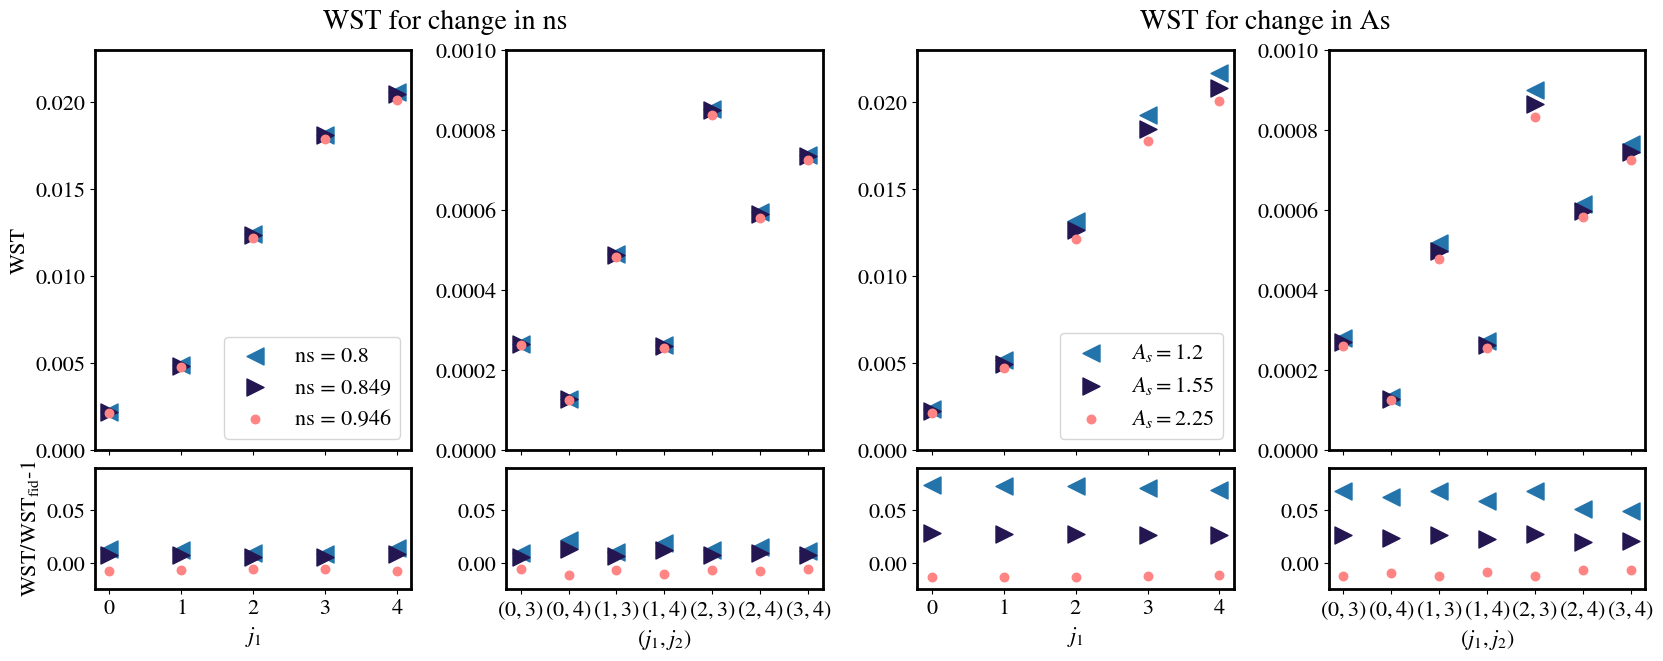

In [178]:
coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$']


fig = plt.figure(figsize=(20, 7))
grid = plt.GridSpec(4, 4, hspace=0.15, wspace=0.3)


big_ax = fig.add_subplot(grid[0:3, 0])
big_ax.scatter(coeff , ord_1_ns[0], marker = '<',color='#2374AB', s= 150, label ='ns = 0.8')
big_ax.scatter(coeff , ord_1_ns[1], marker = '>',color='#231651', s= 150, label ='ns = 0.849')
big_ax.scatter(coeff , ord_1_ns[2], marker='.', s=150, color='#FF8484', label ='ns = 0.946')
big_ax.set_ylim([0,0.023])
big_ax.legend(loc='lower right', fontsize=16)
big_ax.xaxis.set_tick_params(labelbottom=False)
big_ax.set_ylabel('WST')

small_ax = fig.add_subplot(grid[3, 0], sharex=big_ax)
small_ax.scatter(coeff , [ord_1_ns[0][0]/ord_1_fid[0]-1 ,ord_1_ns[0][1]/ord_1_fid[1]-1 , ord_1_ns[0][2]/ord_1_fid[2]-1, ord_1_ns[0][3]/ord_1_fid[3]-1 ,ord_1_ns[0][4]/ord_1_fid[4]-1], marker = '<',color='#2374AB', s= 150, label ='ns = 0.8')
small_ax.scatter(coeff , [ord_1_ns[1][0]/ord_1_fid[0]-1 ,ord_1_ns[1][1]/ord_1_fid[1]-1 , ord_1_ns[1][2]/ord_1_fid[2]-1, ord_1_ns[1][3]/ord_1_fid[3]-1 ,ord_1_ns[1][4]/ord_1_fid[4]-1], marker = '>',color='#231651', s= 150, label ='ns = 0.849')
small_ax.scatter(coeff , [ord_1_ns[2][0]/ord_1_fid[0]-1 ,ord_1_ns[2][1]/ord_1_fid[1]-1 , ord_1_ns[2][2]/ord_1_fid[2]-1, ord_1_ns[2][3]/ord_1_fid[3]-1 ,ord_1_ns[2][4]/ord_1_fid[4]-1], marker='.', s=150, color='#FF8484', label ='ns = 0.897')

small_ax.set_xlabel(r'$j_1$')
small_ax.set_ylim([-0.025,0.09])
small_ax.set_ylabel(r'WST/WST$_{\mathrm{fid}}$-1')

coeff=[r'$(0,3)$',r'$(0,4)$',r'$(1,3)$',r'$(1,4)$',r'$(2,3)$',r'$(2,4)$',r'$(3,4)$']

big_ax = fig.add_subplot(grid[0:3, 1])
big_ax.scatter(coeff , ord_2_ns[0], marker = '<',color='#2374AB', s= 150, label ='ns = 0.8')
big_ax.scatter(coeff , ord_2_ns[1], marker = '>',color='#231651', s= 150, label ='ns = 0.849')
big_ax.scatter(coeff , ord_2_ns[2], marker='.', s=150, color='#FF8484', label ='ns = 0.946')
big_ax.set_ylim([0,0.001])
big_ax.xaxis.set_tick_params(labelbottom=False)
    
small_ax = fig.add_subplot(grid[3, 1], sharex=big_ax)
small_ax.scatter(coeff , [ord_2_ns[0][0]/ord_2_fid[0]-1 ,ord_2_ns[0][1]/ord_2_fid[1]-1 , ord_2_ns[0][2]/ord_2_fid[2]-1, ord_2_ns[0][3]/ord_2_fid[3]-1 ,ord_2_ns[0][4]/ord_2_fid[4]-1,ord_2_ns[0][5]/ord_2_fid[5]-1,ord_2_ns[0][6]/ord_2_fid[6]-1], marker = '<',color='#2374AB', s= 150, label ='ns = 0.8')
small_ax.scatter(coeff , [ord_2_ns[1][0]/ord_2_fid[0]-1 ,ord_2_ns[1][1]/ord_2_fid[1]-1 , ord_2_ns[1][2]/ord_2_fid[2]-1, ord_2_ns[1][3]/ord_2_fid[3]-1 ,ord_2_ns[1][4]/ord_2_fid[4]-1,ord_2_ns[1][5]/ord_2_fid[5]-1,ord_2_ns[1][6]/ord_2_fid[6]-1], marker = '>',color='#231651', s= 150, label ='ns = 0.849')
small_ax.scatter(coeff , [ord_2_ns[2][0]/ord_2_fid[0]-1 ,ord_2_ns[2][1]/ord_2_fid[1]-1 , ord_2_ns[2][2]/ord_2_fid[2]-1, ord_2_ns[2][3]/ord_2_fid[3]-1 ,ord_2_ns[2][4]/ord_2_fid[4]-1,ord_2_ns[2][5]/ord_2_fid[5]-1,ord_2_ns[2][6]/ord_2_fid[6]-1], marker='.', s=150, color='#FF8484', label ='ns = 0.897')
small_ax.set_ylim([-0.025,0.09])
small_ax.set_xlabel(r'$(j_1,j_2)$')


coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$']
big_ax = fig.add_subplot(grid[0:3, 2])
big_ax.scatter(coeff , ord_1_as[0], marker = '<',color='#2374AB', s= 150, label =r'$A_s = 1.2$')
big_ax.scatter(coeff , ord_1_as[1], marker='>', s=150, color='#231651', label =r'$A_s = 1.55$')
big_ax.scatter(coeff , ord_1_as[2], marker = '.',color='#FF8484', s= 150, label =r'$A_s = 2.25$')
big_ax.set_ylim([0,0.023])
big_ax.legend(loc='lower right', fontsize=16)
big_ax.xaxis.set_tick_params(labelbottom=False)

small_ax = fig.add_subplot(grid[3, 2], sharex=big_ax)

small_ax.scatter(coeff , [ord_1_as[0][0]/ord_1_fid[0]-1 ,ord_1_as[0][1]/ord_1_fid[1]-1 , ord_1_as[0][2]/ord_1_fid[2]-1, ord_1_as[0][3]/ord_1_fid[3]-1 ,ord_1_as[0][4]/ord_1_fid[4]-1], marker = '<',color='#2374AB', s= 150, label =r'$A_s = 1.2$')
small_ax.scatter(coeff , [ord_1_as[1][0]/ord_1_fid[0]-1 ,ord_1_as[1][1]/ord_1_fid[1]-1 , ord_1_as[1][2]/ord_1_fid[2]-1, ord_1_as[1][3]/ord_1_fid[3]-1 ,ord_1_as[1][4]/ord_1_fid[4]-1], marker='>', s=150, color='#231651', label =r'$A_s = 1.55$')
small_ax.scatter(coeff , [ord_1_as[2][0]/ord_1_fid[0]-1 ,ord_1_as[2][1]/ord_1_fid[1]-1 , ord_1_as[2][2]/ord_1_fid[2]-1, ord_1_as[2][3]/ord_1_fid[3]-1 ,ord_1_as[2][4]/ord_1_fid[4]-1], marker = '.',color='#FF8484', s= 150, label =r'$A_s = 2.25$')
small_ax.set_ylim([-0.025,0.09])
small_ax.set_xlabel(r'$j_1$')

coeff=[r'$(0,3)$',r'$(0,4)$',r'$(1,3)$',r'$(1,4)$',r'$(2,3)$',r'$(2,4)$',r'$(3,4)$']

big_ax = fig.add_subplot(grid[0:3, 3])
big_ax.scatter(coeff , ord_2_as[0], marker = '<',color='#2374AB', s= 150, label ='ns = 0.8')
big_ax.scatter(coeff , ord_2_as[1], marker = '>',color='#231651', s= 150, label ='ns = 0.849')
big_ax.scatter(coeff , ord_2_as[2], marker='.', s=150, color='#FF8484', label ='ns = 0.897')
big_ax.set_ylim([0,0.001])

big_ax.xaxis.set_tick_params(labelbottom=False)
    
small_ax = fig.add_subplot(grid[3, 3], sharex=big_ax)
small_ax.scatter(coeff , [ord_2_as[0][0]/ord_2_fid[0]-1 ,ord_2_as[0][1]/ord_2_fid[1]-1 , ord_2_as[0][2]/ord_2_fid[2]-1, ord_2_as[0][3]/ord_2_fid[3]-1 ,ord_2_as[0][4]/ord_2_fid[4]-1,ord_2_as[0][5]/ord_2_fid[5]-1,ord_2_as[0][6]/ord_2_fid[6]-1], marker = '<',color='#2374AB', s= 150, label =r'$A_s = 1.2$')
small_ax.scatter(coeff , [ord_2_as[1][0]/ord_2_fid[0]-1 ,ord_2_as[1][1]/ord_2_fid[1]-1 , ord_2_as[1][2]/ord_2_fid[2]-1, ord_2_as[1][3]/ord_2_fid[3]-1 ,ord_2_as[1][4]/ord_2_fid[4]-1,ord_2_as[1][5]/ord_2_fid[5]-1,ord_2_as[1][6]/ord_2_fid[6]-1], marker='>', s=150, color='#231651', label =r'$A_s = 1.55$')
small_ax.scatter(coeff , [ord_2_as[2][0]/ord_2_fid[0]-1 ,ord_2_as[2][1]/ord_2_fid[1]-1 , ord_2_as[2][2]/ord_2_fid[2]-1, ord_2_as[2][3]/ord_2_fid[3]-1 ,ord_2_as[2][4]/ord_2_fid[4]-1,ord_2_as[2][5]/ord_2_fid[5]-1,ord_2_as[2][6]/ord_2_fid[6]-1], marker = '.',color='#FF8484', s= 150, label =r'$A_s = 2.25$')
small_ax.set_xlabel(r'$(j_1,j_2)$')
small_ax.set_ylim([-0.025,0.09])



    
fig.text(0.3, 0.92, "WST for change in ns", ha='center', va='center', fontsize=20)
fig.text(0.71, 0.92, "WST for change in As", ha='center', va='center', fontsize=20)

plt.tight_layout()
plt.savefig('ns_as_with_zoom_in.pdf')
plt.show()


/Users/Hurum/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


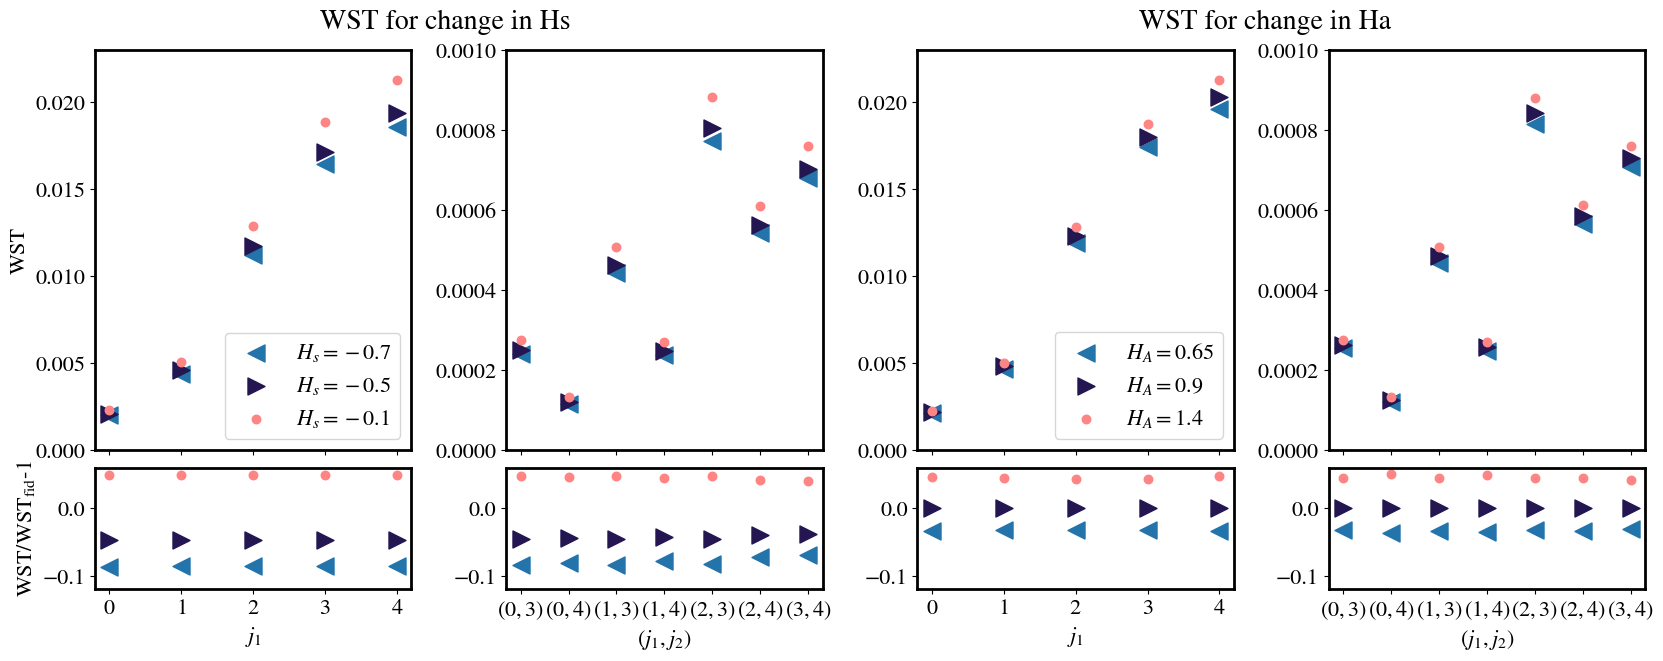

In [169]:
coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$']


fig = plt.figure(figsize=(20, 7))
grid = plt.GridSpec(4, 4, hspace=0.15, wspace=0.3)


big_ax = fig.add_subplot(grid[0:3, 0])
big_ax.scatter(coeff , ord_1_hs[0], marker='<', s=150, color='#2374AB', label =r'$H_s = -0.7$')
big_ax.scatter(coeff , ord_1_hs[1], marker = '>',color='#231651', s= 150, label =r'$H_s = -0.5$')
big_ax.scatter(coeff , ord_1_hs[2], marker = '.',color='#FF8484', s= 150, label =r'$H_s = -0.1$')
big_ax.set_ylim([0,0.023])
big_ax.legend(loc='lower right', fontsize=16)
big_ax.set_ylabel('WST')
big_ax.xaxis.set_tick_params(labelbottom=False)

small_ax = fig.add_subplot(grid[3, 0], sharex=big_ax)
small_ax.scatter(coeff , [ord_1_hs[0][0]/ord_1_fid[0]-1 ,ord_1_hs[0][1]/ord_1_fid[1]-1 , ord_1_hs[0][2]/ord_1_fid[2]-1, ord_1_hs[0][3]/ord_1_fid[3]-1 ,ord_1_hs[0][4]/ord_1_fid[4]-1], marker = '<',color='#2374AB', s= 150, label ='ns = 0.8')
small_ax.scatter(coeff , [ord_1_hs[1][0]/ord_1_fid[0]-1 ,ord_1_hs[1][1]/ord_1_fid[1]-1 , ord_1_hs[1][2]/ord_1_fid[2]-1, ord_1_hs[1][3]/ord_1_fid[3]-1 ,ord_1_hs[1][4]/ord_1_fid[4]-1], marker = '>',color='#231651', s= 150, label ='ns = 0.849')
small_ax.scatter(coeff , [ord_1_hs[2][0]/ord_1_fid[0]-1 ,ord_1_hs[2][1]/ord_1_fid[1]-1 , ord_1_hs[2][2]/ord_1_fid[2]-1, ord_1_hs[2][3]/ord_1_fid[3]-1 ,ord_1_hs[2][4]/ord_1_fid[4]-1], marker='.', s=150, color='#FF8484', label ='ns = 0.897')

small_ax.set_xlabel(r'$j_1$')
small_ax.set_ylabel(r'WST/WST$_{\mathrm{fid}}$-1')
small_ax.set_ylim([-0.12,0.06])


coeff=[r'$(0,3)$',r'$(0,4)$',r'$(1,3)$',r'$(1,4)$',r'$(2,3)$',r'$(2,4)$',r'$(3,4)$']

big_ax = fig.add_subplot(grid[0:3, 1])
big_ax.scatter(coeff , ord_2_hs[0], marker = '<',color='#2374AB', s= 150, label ='ns = 0.8')
big_ax.scatter(coeff , ord_2_hs[1], marker = '>',color='#231651', s= 150, label ='ns = 0.849')
big_ax.scatter(coeff , ord_2_hs[2], marker='.', s=150, color='#FF8484', label ='ns = 0.897')
big_ax.set_ylim([0,0.001])
big_ax.xaxis.set_tick_params(labelbottom=False)
    
small_ax = fig.add_subplot(grid[3, 1], sharex=big_ax)
small_ax.scatter(coeff , [ord_2_hs[0][0]/ord_2_fid[0]-1 ,ord_2_hs[0][1]/ord_2_fid[1]-1 , ord_2_hs[0][2]/ord_2_fid[2]-1, ord_2_hs[0][3]/ord_2_fid[3]-1 ,ord_2_hs[0][4]/ord_2_fid[4]-1,ord_2_hs[0][5]/ord_2_fid[5]-1,ord_2_hs[0][6]/ord_2_fid[6]-1], marker = '<',color='#2374AB', s= 150, label ='ns = 0.8')
small_ax.scatter(coeff , [ord_2_hs[1][0]/ord_2_fid[0]-1 ,ord_2_hs[1][1]/ord_2_fid[1]-1 , ord_2_hs[1][2]/ord_2_fid[2]-1, ord_2_hs[1][3]/ord_2_fid[3]-1 ,ord_2_hs[1][4]/ord_2_fid[4]-1,ord_2_hs[1][5]/ord_2_fid[5]-1,ord_2_hs[1][6]/ord_2_fid[6]-1], marker = '>',color='#231651', s= 150, label ='ns = 0.849')
small_ax.scatter(coeff , [ord_2_hs[2][0]/ord_2_fid[0]-1 ,ord_2_hs[2][1]/ord_2_fid[1]-1 , ord_2_hs[2][2]/ord_2_fid[2]-1, ord_2_hs[2][3]/ord_2_fid[3]-1 ,ord_2_hs[2][4]/ord_2_fid[4]-1,ord_2_hs[2][5]/ord_2_fid[5]-1,ord_2_hs[2][6]/ord_2_fid[6]-1], marker='.', s=150, color='#FF8484', label ='ns = 0.897')
small_ax.set_ylim([-0.12,0.06])

small_ax.set_xlabel(r'$(j_1,j_2)$')


coeff=[r'$0$',r'$1$',r'$2$',r'$3$',r'$4$']
big_ax = fig.add_subplot(grid[0:3, 2])
big_ax.scatter(coeff , ord_1_ha[0], marker = '<',color='#2374AB', s= 150, label =r'$H_A = 0.65$')
big_ax.scatter(coeff , ord_1_ha[1], marker = '>',color='#231651', s= 150, label =r'$H_A = 0.9$')
big_ax.scatter(coeff , ord_1_ha[2], marker='.', s=150, color='#FF8484', label =r'$H_A = 1.4$')
big_ax.set_ylim([0,0.023])
big_ax.legend(loc='lower right', fontsize=16)
big_ax.xaxis.set_tick_params(labelbottom=False)

small_ax = fig.add_subplot(grid[3, 2], sharex=big_ax)

small_ax.scatter(coeff , [ord_1_ha[0][0]/ord_1_fid[0]-1 ,ord_1_ha[0][1]/ord_1_fid[1]-1 , ord_1_ha[0][2]/ord_1_fid[2]-1, ord_1_ha[0][3]/ord_1_fid[3]-1 ,ord_1_ha[0][4]/ord_1_fid[4]-1], marker = '<',color='#2374AB', s= 150, label =r'$A_s = 1.2$')
small_ax.scatter(coeff , [ord_1_ha[1][0]/ord_1_fid[0]-1 ,ord_1_ha[1][1]/ord_1_fid[1]-1 , ord_1_ha[1][2]/ord_1_fid[2]-1, ord_1_ha[1][3]/ord_1_fid[3]-1 ,ord_1_ha[1][4]/ord_1_fid[4]-1], marker='>', s=150, color='#231651', label =r'$A_s = 1.55$')
small_ax.scatter(coeff , [ord_1_ha[2][0]/ord_1_fid[0]-1 ,ord_1_ha[2][1]/ord_1_fid[1]-1 , ord_1_ha[2][2]/ord_1_fid[2]-1, ord_1_ha[2][3]/ord_1_fid[3]-1 ,ord_1_ha[2][4]/ord_1_fid[4]-1], marker = '.',color='#FF8484', s= 150, label =r'$A_s = 2.25$')
small_ax.set_ylim([-0.12,0.06])
small_ax.set_xlabel(r'$j_1$')

coeff=[r'$(0,3)$',r'$(0,4)$',r'$(1,3)$',r'$(1,4)$',r'$(2,3)$',r'$(2,4)$',r'$(3,4)$']

big_ax = fig.add_subplot(grid[0:3, 3])
big_ax.scatter(coeff , ord_2_ha[0], marker = '<',color='#2374AB', s= 150, label ='ns = 0.8')
big_ax.scatter(coeff , ord_2_ha[1], marker = '>',color='#231651', s= 150, label ='ns = 0.849')
big_ax.scatter(coeff , ord_2_ha[2], marker='.', s=150, color='#FF8484', label ='ns = 0.897')
big_ax.set_ylim([0,0.001])

big_ax.xaxis.set_tick_params(labelbottom=False)
    
small_ax = fig.add_subplot(grid[3, 3], sharex=big_ax)
small_ax.scatter(coeff , [ord_2_ha[0][0]/ord_2_fid[0]-1 ,ord_2_ha[0][1]/ord_2_fid[1]-1 , ord_2_ha[0][2]/ord_2_fid[2]-1, ord_2_ha[0][3]/ord_2_fid[3]-1 ,ord_2_ha[0][4]/ord_2_fid[4]-1,ord_2_ha[0][5]/ord_2_fid[5]-1,ord_2_ha[0][6]/ord_2_fid[6]-1], marker = '<',color='#2374AB', s= 150, label =r'$A_s = 1.2$')
small_ax.scatter(coeff , [ord_2_ha[1][0]/ord_2_fid[0]-1 ,ord_2_ha[1][1]/ord_2_fid[1]-1 , ord_2_ha[1][2]/ord_2_fid[2]-1, ord_2_ha[1][3]/ord_2_fid[3]-1 ,ord_2_ha[1][4]/ord_2_fid[4]-1,ord_2_ha[1][5]/ord_2_fid[5]-1,ord_2_ha[1][6]/ord_2_fid[6]-1], marker='>', s=150, color='#231651', label =r'$A_s = 1.55$')
small_ax.scatter(coeff , [ord_2_ha[2][0]/ord_2_fid[0]-1 ,ord_2_ha[2][1]/ord_2_fid[1]-1 , ord_2_ha[2][2]/ord_2_fid[2]-1, ord_2_ha[2][3]/ord_2_fid[3]-1 ,ord_2_ha[2][4]/ord_2_fid[4]-1,ord_2_ha[2][5]/ord_2_fid[5]-1,ord_2_ha[2][6]/ord_2_fid[6]-1], marker = '.',color='#FF8484', s= 150, label =r'$A_s = 2.25$')
small_ax.set_xlabel(r'$(j_1,j_2)$')
small_ax.set_ylim([-0.12,0.06])



    
fig.text(0.3, 0.92, "WST for change in Hs", ha='center', va='center', fontsize=20)
fig.text(0.71, 0.92, "WST for change in Ha", ha='center', va='center', fontsize=20)

plt.tight_layout()
plt.savefig('hs_ha_with_zoom_in.pdf')
plt.show()
